In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import random
import os

def sample_classes(num_classes:int, rootdir:str) -> list:
    """
    Function to sample classes from the dataset.
    Args:
        num_classes (int): Number of classes to sample.
        rootdir (str): Root directory of the dataset.
    Returns:
        list: List of sampled classes.
    """
    filenames = [filename for filename in os.listdir(os.path.join(rootdir, "train/")) if filename.startswith("n")]
    if num_classes > len(filenames):
        raise ValueError(f"Number of classes requested is greater than the total classes(={len(filenames)}) available in the dataset!")

    return random.sample(filenames, num_classes)


### Hyperparameters ####

ROOT_DIR = '/content/drive/MyDrive/Colab Notebooks/tiny-imagenet-200/'
SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks'
NUM_CLASSES = 5
BATCH_SIZE = 64
NUM_EPOCHS = 60

random.seed(10)
CLASS_LIST = sample_classes(NUM_CLASSES, ROOT_DIR)
print(f"Sampled classes(class, label): {dict( zip(CLASS_LIST, range(len(CLASS_LIST))) )}\n")

PTH_PATHS = [SAVE_PATH+f'/{NUM_CLASSES}M1none.pth',
            SAVE_PATH+f'/{NUM_CLASSES}M2acuity_1_3_5_48.pth',
            SAVE_PATH+f'/{NUM_CLASSES}M3cs_1_3_8_48.pth',
            SAVE_PATH+f'/{NUM_CLASSES}M4acuity_cs_1_3_48.pth',]

# number of images to capture the RDM
NUM_IMGS = 60

Sampled classes(class, label): {'n01983481': 0, 'n01629819': 1, 'n01910747': 2, 'n01944390': 3, 'n01443537': 4}



In [5]:
import wandb
import torch
from math import ceil
from timeit import default_timer as timer
# import custom modules
from DataLoader import dataloader
from model import engine

def train_model(modelName:str, rootdir:str,
                num_classes:int, batch_size:int,
                num_epochs:int, transforms:list,
                ages:list=[48], class_list:list=None, Model_info=None) -> tuple:
    """
    Function to train the model with different transformations and ages.
    Args:
        modelName (str): Name of the model.
        rootdir (str): Root directory of the dataset.
        num_classes (int): Number of classes in the dataset.
        batch_size (int): Batch size for training.
        num_epochs (int): Total number of epochs for training.
        transforms (list): List of transformations to apply.
        ages (list, optional): List of ages for curriculum learning. Defaults to None.
        class_list (list, optional): List of classes to sample. Defaults to None.
        Model_info (tuple, optional): Tuple containing model and evaluation metrics. Defaults to None.
    Returns:
        tuple: Tuple containing model evaluation metrics and the trained model.
    """

    print(f"Training initiated for {modelName} with {num_classes} classes")
    print("wandb initialised!\n")
    # wandb is used for logging and tracking experiments
    wandb.login()
    wandb.init(project="CVP_Project", name=f"{modelName}")

    start_epoch = 1
    EpochsPerDataset = int(ceil(num_epochs/(len(transforms)*len(ages))))


    for age in ages:
        for transform in transforms:
            # Check if the number of epochs exceeds the total number of epochs
            if start_epoch+EpochsPerDataset > num_epochs+1:
                EpochsPerDataset = num_epochs - start_epoch + 1

            start = timer()
            print(f"Dataset: applied transform = {transform}, age = {age} month(s)\n")
            trainData = dataloader(rootdir, num_classes, transform, age, mode='train', classlist=class_list, batch_size=batch_size)
            valData = dataloader(rootdir, num_classes, transform, age, mode='val', classlist=class_list, batch_size=batch_size)
            print("Datasets are loaded to the engine!")
            print(f"Time taken to load the dataset: {timer()-start:.2f}s\n")

            Model_info = engine(train_data=trainData, val_data=valData,
                                    Num_classes=num_classes, Batchsize=batch_size,
                                    StartEpoch=int(start_epoch), Num_epochs=int(EpochsPerDataset),
                                    model_info=Model_info, model_name=modelName)
            print(f"Model finished training with Dataset: {transform} ~ {age} month(s)\n\n")

            start_epoch += EpochsPerDataset

    model_eval, model = Model_info
    torch.save({'model_state_dict': model.state_dict(), 'metrics': model_eval}, SAVE_PATH+f"/{num_classes}{modelName}.pth")
    print(f"Model saved as {num_classes}{modelName}.pth.\n")
    wandb.finish()

    return Model_info

In [6]:
# training with no transforms and no curriculum
M1 = train_model('M1none', ROOT_DIR, NUM_CLASSES, BATCH_SIZE, NUM_EPOCHS, ["none"], class_list=CLASS_LIST)

Training initiated for M1none with 5 classes
wandb initialised!



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rvvoffl (rvvoffl-fau-erlangen-n-rnberg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Dataset: applied transform = none, age = 48 month(s)

Sampled classes(class, label): {'n01983481': 0, 'n01629819': 1, 'n01910747': 2, 'n01944390': 3, 'n01443537': 4}

trainDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of train data: 2500
none transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
none transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

Datasets are loaded to the engine!
Time taken to load the dataset: 1846.41s


Training M1none for 1:60 epochs



train epoch 1: 40it [00:05,  7.35it/s, loss=1.82, accuracy=0.282]
val epoch 1: 4it [00:00,  7.16it/s, loss=1.65, accuracy=0.208]


Epoch 1 runtime: 6.01s



train epoch 2: 40it [00:03, 13.04it/s, loss=1.64, accuracy=0.354]
val epoch 2: 4it [00:00, 12.89it/s, loss=1.7, accuracy=0.32]


Epoch 2 runtime: 3.39s



train epoch 3: 40it [00:03, 13.11it/s, loss=1.33, accuracy=0.404]
val epoch 3: 4it [00:00, 13.92it/s, loss=2.45, accuracy=0.292]


Epoch 3 runtime: 3.35s



train epoch 4: 40it [00:03, 13.28it/s, loss=1.24, accuracy=0.49]
val epoch 4: 4it [00:00, 12.68it/s, loss=1.2, accuracy=0.492]


Epoch 4 runtime: 3.34s



train epoch 5: 40it [00:04,  9.64it/s, loss=1.22, accuracy=0.498]
val epoch 5: 4it [00:00, 14.19it/s, loss=1.44, accuracy=0.464]


Epoch 5 runtime: 4.44s



train epoch 6: 40it [00:03, 12.67it/s, loss=1.18, accuracy=0.539]
val epoch 6: 4it [00:00, 12.95it/s, loss=1.3, accuracy=0.492]


Epoch 6 runtime: 3.47s



train epoch 7: 40it [00:04,  8.05it/s, loss=1.11, accuracy=0.547]
val epoch 7: 4it [00:00, 13.22it/s, loss=1.04, accuracy=0.592]


Epoch 7 runtime: 5.28s



train epoch 8: 40it [00:03, 10.08it/s, loss=1.11, accuracy=0.568]
val epoch 8: 4it [00:00,  8.58it/s, loss=0.985, accuracy=0.58]


Epoch 8 runtime: 4.44s



train epoch 9: 40it [00:03, 12.95it/s, loss=1.16, accuracy=0.538]
val epoch 9: 4it [00:00, 13.35it/s, loss=1.02, accuracy=0.528]


Epoch 9 runtime: 3.40s



train epoch 10: 40it [00:03, 13.00it/s, loss=0.981, accuracy=0.594]
val epoch 10: 4it [00:00, 13.99it/s, loss=0.873, accuracy=0.612]


Epoch 10 runtime: 3.37s



train epoch 11: 40it [00:03, 12.99it/s, loss=0.951, accuracy=0.608]
val epoch 11: 4it [00:00,  9.53it/s, loss=1.34, accuracy=0.656]


Epoch 11 runtime: 3.51s



train epoch 12: 40it [00:04,  9.82it/s, loss=0.956, accuracy=0.618]
val epoch 12: 4it [00:00, 13.00it/s, loss=0.983, accuracy=0.628]


Epoch 12 runtime: 4.39s



train epoch 13: 40it [00:03, 12.61it/s, loss=1.15, accuracy=0.618]
val epoch 13: 4it [00:00, 13.36it/s, loss=4.93, accuracy=0.34]


Epoch 13 runtime: 3.48s



train epoch 14: 40it [00:03, 12.79it/s, loss=1.75, accuracy=0.327]
val epoch 14: 4it [00:00, 13.24it/s, loss=2.05, accuracy=0.204]


Epoch 14 runtime: 3.44s



train epoch 15: 40it [00:03, 11.63it/s, loss=1.71, accuracy=0.244]
val epoch 15: 4it [00:00,  6.46it/s, loss=1.77, accuracy=0.28]


Epoch 15 runtime: 4.07s



train epoch 16: 40it [00:03, 10.63it/s, loss=1.84, accuracy=0.248]
val epoch 16: 4it [00:00, 13.72it/s, loss=6.44, accuracy=0.236]


Epoch 16 runtime: 4.06s



train epoch 17: 40it [00:03, 12.85it/s, loss=1.69, accuracy=0.232]
val epoch 17: 4it [00:00, 13.58it/s, loss=1.54, accuracy=0.244]


Epoch 17 runtime: 3.42s



train epoch 18: 40it [00:03, 12.72it/s, loss=1.49, accuracy=0.323]
val epoch 18: 4it [00:00, 12.96it/s, loss=1.54, accuracy=0.316]


Epoch 18 runtime: 3.46s



train epoch 19: 40it [00:03, 10.82it/s, loss=1.44, accuracy=0.351]
val epoch 19: 4it [00:00,  8.29it/s, loss=1.31, accuracy=0.424]


Epoch 19 runtime: 4.19s



train epoch 20: 40it [00:03, 11.55it/s, loss=1.32, accuracy=0.412]
val epoch 20: 4it [00:00, 13.60it/s, loss=1.22, accuracy=0.448]


Epoch 20 runtime: 3.77s



train epoch 21: 40it [00:03, 12.70it/s, loss=1.27, accuracy=0.429]
val epoch 21: 4it [00:00, 13.08it/s, loss=1.11, accuracy=0.504]


Epoch 21 runtime: 3.47s



train epoch 22: 40it [00:03, 12.74it/s, loss=1.21, accuracy=0.453]
val epoch 22: 4it [00:00, 13.27it/s, loss=1.14, accuracy=0.46]


Epoch 22 runtime: 3.45s



train epoch 23: 40it [00:04,  8.38it/s, loss=1.2, accuracy=0.458]
val epoch 23: 4it [00:00, 13.07it/s, loss=1.07, accuracy=0.504]


Epoch 23 runtime: 5.09s



train epoch 24: 40it [00:03, 12.62it/s, loss=1.16, accuracy=0.474]
val epoch 24: 4it [00:00, 13.57it/s, loss=1.14, accuracy=0.488]


Epoch 24 runtime: 3.47s



train epoch 25: 40it [00:03, 12.32it/s, loss=1.35, accuracy=0.398]
val epoch 25: 4it [00:00, 13.20it/s, loss=1.23, accuracy=0.452]


Epoch 25 runtime: 3.56s



train epoch 26: 40it [00:03, 11.77it/s, loss=1.18, accuracy=0.482]
val epoch 26: 4it [00:00,  8.74it/s, loss=1.07, accuracy=0.52]


Epoch 26 runtime: 3.86s



train epoch 27: 40it [00:03, 10.50it/s, loss=1.12, accuracy=0.52]
val epoch 27: 4it [00:00, 13.49it/s, loss=1.08, accuracy=0.52]


Epoch 27 runtime: 4.12s



train epoch 28: 40it [00:03, 12.71it/s, loss=1.07, accuracy=0.562]
val epoch 28: 4it [00:00, 13.29it/s, loss=1.08, accuracy=0.556]


Epoch 28 runtime: 3.46s



train epoch 29: 40it [00:03, 12.57it/s, loss=1.04, accuracy=0.561]
val epoch 29: 4it [00:00, 12.73it/s, loss=1.01, accuracy=0.536]


Epoch 29 runtime: 3.51s



train epoch 30: 40it [00:03, 10.56it/s, loss=0.948, accuracy=0.616]
val epoch 30: 4it [00:00,  8.73it/s, loss=1.02, accuracy=0.604]


Epoch 30 runtime: 4.26s



train epoch 31: 40it [00:03, 11.58it/s, loss=1.01, accuracy=0.594]
val epoch 31: 4it [00:00, 13.01it/s, loss=0.955, accuracy=0.648]


Epoch 31 runtime: 3.77s



train epoch 32: 40it [00:03, 12.46it/s, loss=0.921, accuracy=0.642]
val epoch 32: 4it [00:00, 12.68it/s, loss=0.995, accuracy=0.616]


Epoch 32 runtime: 3.54s



train epoch 33: 40it [00:03, 12.58it/s, loss=0.886, accuracy=0.676]
val epoch 33: 4it [00:00, 13.07it/s, loss=0.905, accuracy=0.652]


Epoch 33 runtime: 3.50s



train epoch 34: 40it [00:04,  9.24it/s, loss=0.846, accuracy=0.69]
val epoch 34: 4it [00:00, 12.77it/s, loss=0.882, accuracy=0.696]


Epoch 34 runtime: 4.65s



train epoch 35: 40it [00:03, 12.63it/s, loss=0.792, accuracy=0.712]
val epoch 35: 4it [00:00, 13.11it/s, loss=0.862, accuracy=0.668]


Epoch 35 runtime: 3.48s



train epoch 36: 40it [00:03, 12.62it/s, loss=0.895, accuracy=0.668]
val epoch 36: 4it [00:00, 13.24it/s, loss=0.794, accuracy=0.688]


Epoch 36 runtime: 3.48s



train epoch 37: 40it [00:03, 11.99it/s, loss=0.791, accuracy=0.709]
val epoch 37: 4it [00:00,  8.80it/s, loss=0.73, accuracy=0.72]


Epoch 37 runtime: 3.81s



train epoch 38: 40it [00:03, 10.15it/s, loss=0.744, accuracy=0.733]
val epoch 38: 4it [00:00, 13.08it/s, loss=0.707, accuracy=0.724]


Epoch 38 runtime: 4.25s



train epoch 39: 40it [00:03, 12.70it/s, loss=0.798, accuracy=0.71]
val epoch 39: 4it [00:00, 13.06it/s, loss=0.64, accuracy=0.768]


Epoch 39 runtime: 3.47s



train epoch 40: 40it [00:03, 12.38it/s, loss=0.709, accuracy=0.748]
val epoch 40: 4it [00:00, 12.41it/s, loss=0.631, accuracy=0.768]


Epoch 40 runtime: 3.56s



train epoch 41: 40it [00:03, 10.58it/s, loss=0.663, accuracy=0.759]
val epoch 41: 4it [00:00,  8.92it/s, loss=1.01, accuracy=0.64]


Epoch 41 runtime: 4.24s



train epoch 42: 40it [00:03, 11.42it/s, loss=0.659, accuracy=0.762]
val epoch 42: 4it [00:00, 12.74it/s, loss=0.775, accuracy=0.676]


Epoch 42 runtime: 3.83s



train epoch 43: 40it [00:03, 12.62it/s, loss=0.618, accuracy=0.775]
val epoch 43: 4it [00:00, 12.47it/s, loss=0.576, accuracy=0.788]


Epoch 43 runtime: 3.50s



train epoch 44: 40it [00:03, 12.25it/s, loss=0.623, accuracy=0.772]
val epoch 44: 4it [00:00, 13.22it/s, loss=0.59, accuracy=0.784]


Epoch 44 runtime: 3.58s



train epoch 45: 40it [00:04,  9.24it/s, loss=0.571, accuracy=0.8]
val epoch 45: 4it [00:00, 13.23it/s, loss=0.631, accuracy=0.78]


Epoch 45 runtime: 4.64s



train epoch 46: 40it [00:03, 12.64it/s, loss=0.566, accuracy=0.788]
val epoch 46: 4it [00:00, 12.02it/s, loss=0.566, accuracy=0.812]


Epoch 46 runtime: 3.51s



train epoch 47: 40it [00:03, 12.51it/s, loss=0.638, accuracy=0.765]
val epoch 47: 4it [00:00, 13.39it/s, loss=0.658, accuracy=0.756]


Epoch 47 runtime: 3.50s



train epoch 48: 40it [00:03, 11.40it/s, loss=0.627, accuracy=0.776]
val epoch 48: 4it [00:00,  8.45it/s, loss=0.538, accuracy=0.812]


Epoch 48 runtime: 3.99s



train epoch 49: 40it [00:03, 10.45it/s, loss=0.555, accuracy=0.807]
val epoch 49: 4it [00:00, 12.47it/s, loss=0.597, accuracy=0.78]


Epoch 49 runtime: 4.16s



train epoch 50: 40it [00:03, 12.55it/s, loss=0.59, accuracy=0.795]
val epoch 50: 4it [00:00, 12.25it/s, loss=0.609, accuracy=0.796]


Epoch 50 runtime: 3.52s



train epoch 51: 40it [00:03, 12.52it/s, loss=0.537, accuracy=0.805]
val epoch 51: 4it [00:00, 13.19it/s, loss=0.799, accuracy=0.708]


Epoch 51 runtime: 3.51s



train epoch 52: 40it [00:03, 10.16it/s, loss=0.583, accuracy=0.786]
val epoch 52: 4it [00:00,  7.93it/s, loss=0.572, accuracy=0.796]


Epoch 52 runtime: 4.45s



train epoch 53: 40it [00:03, 11.69it/s, loss=0.5, accuracy=0.824]
val epoch 53: 4it [00:00, 12.90it/s, loss=0.765, accuracy=0.72]


Epoch 53 runtime: 3.74s



train epoch 54: 40it [00:03, 12.66it/s, loss=0.657, accuracy=0.762]
val epoch 54: 4it [00:00, 12.70it/s, loss=0.609, accuracy=0.772]


Epoch 54 runtime: 3.49s



train epoch 55: 40it [00:03, 12.64it/s, loss=0.54, accuracy=0.803]
val epoch 55: 4it [00:00,  9.17it/s, loss=0.535, accuracy=0.816]


Epoch 55 runtime: 3.62s



train epoch 56: 40it [00:04,  9.44it/s, loss=0.51, accuracy=0.818]
val epoch 56: 4it [00:00, 12.95it/s, loss=0.513, accuracy=0.804]


Epoch 56 runtime: 4.56s



train epoch 57: 40it [00:03, 12.36it/s, loss=0.485, accuracy=0.836]
val epoch 57: 4it [00:00, 12.58it/s, loss=0.675, accuracy=0.768]


Epoch 57 runtime: 3.56s



train epoch 58: 40it [00:03, 12.61it/s, loss=0.543, accuracy=0.807]
val epoch 58: 4it [00:00, 12.54it/s, loss=0.594, accuracy=0.776]


Epoch 58 runtime: 3.50s



train epoch 59: 40it [00:03, 11.11it/s, loss=0.451, accuracy=0.848]
val epoch 59: 4it [00:00,  9.11it/s, loss=0.589, accuracy=0.788]


Epoch 59 runtime: 4.05s



train epoch 60: 40it [00:03, 10.79it/s, loss=0.492, accuracy=0.828]
val epoch 60: 4it [00:00, 12.79it/s, loss=0.676, accuracy=0.784]


Epoch 60 runtime: 4.03s


Training completed!
Total runtime(60 epochs): 231.02s
Model finished training with Dataset: none ~ 48 month(s)


Model saved as 5M1none.pth.



In [7]:
# developmental curriculum with acuity transform
M2 = train_model('M2acuity_1_3_5_48', ROOT_DIR, NUM_CLASSES, BATCH_SIZE, NUM_EPOCHS, ["acuity"], [1.0, 3.0, 5.0, 48.0], CLASS_LIST)

Training initiated for M2acuity_1_3_5_48 with 5 classes
wandb initialised!



Dataset: applied transform = acuity, age = 1.0 month(s)

Sampled classes(class, label): {'n01983481': 0, 'n01629819': 1, 'n01910747': 2, 'n01944390': 3, 'n01443537': 4}

trainDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of train data: 2500
acuity transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
acuity transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

Datasets are loaded to the engine!
Time taken to load the dataset: 7.64s


Training M2acuity_1_3_5_48 for 1:15 epochs



train epoch 1: 40it [00:04,  8.65it/s, loss=1.73, accuracy=0.312]
val epoch 1: 4it [00:00,  8.48it/s, loss=1.68, accuracy=0.26]


Epoch 1 runtime: 5.10s



train epoch 2: 40it [00:06,  6.34it/s, loss=1.33, accuracy=0.424]
val epoch 2: 4it [00:00,  7.50it/s, loss=1.18, accuracy=0.484]


Epoch 2 runtime: 6.86s



train epoch 3: 40it [00:04,  8.54it/s, loss=1.25, accuracy=0.466]
val epoch 3: 4it [00:00,  7.73it/s, loss=1.39, accuracy=0.408]


Epoch 3 runtime: 5.21s



train epoch 4: 40it [00:05,  6.78it/s, loss=1.5, accuracy=0.428]
val epoch 4: 4it [00:00,  4.95it/s, loss=1.18, accuracy=0.472]


Epoch 4 runtime: 6.72s



train epoch 5: 40it [00:04,  8.54it/s, loss=1.42, accuracy=0.428]
val epoch 5: 4it [00:00,  7.92it/s, loss=46.1, accuracy=0.212]


Epoch 5 runtime: 5.20s



train epoch 6: 40it [00:04,  8.64it/s, loss=1.7, accuracy=0.226]
val epoch 6: 4it [00:00,  6.22it/s, loss=1.54, accuracy=0.28]


Epoch 6 runtime: 5.28s



train epoch 7: 40it [00:06,  6.64it/s, loss=1.44, accuracy=0.348]
val epoch 7: 4it [00:00,  8.00it/s, loss=1.26, accuracy=0.428]


Epoch 7 runtime: 6.53s



train epoch 8: 40it [00:04,  8.53it/s, loss=1.25, accuracy=0.467]
val epoch 8: 4it [00:00,  8.22it/s, loss=1.15, accuracy=0.532]


Epoch 8 runtime: 5.18s



train epoch 9: 40it [00:06,  6.46it/s, loss=1.3, accuracy=0.482]
val epoch 9: 4it [00:00,  7.22it/s, loss=2.15, accuracy=0.388]


Epoch 9 runtime: 6.75s



train epoch 10: 40it [00:04,  8.31it/s, loss=1.29, accuracy=0.43]
val epoch 10: 4it [00:00,  7.92it/s, loss=1.14, accuracy=0.492]


Epoch 10 runtime: 5.33s



train epoch 11: 40it [00:04,  8.36it/s, loss=1.23, accuracy=0.496]
val epoch 11: 4it [00:00,  5.14it/s, loss=1.12, accuracy=0.572]


Epoch 11 runtime: 5.58s



train epoch 12: 40it [00:05,  6.95it/s, loss=1.1, accuracy=0.532]
val epoch 12: 4it [00:00,  7.87it/s, loss=0.979, accuracy=0.596]


Epoch 12 runtime: 6.27s



train epoch 13: 40it [00:04,  8.67it/s, loss=1.08, accuracy=0.575]
val epoch 13: 4it [00:00,  7.75it/s, loss=1.11, accuracy=0.524]


Epoch 13 runtime: 5.14s



train epoch 14: 40it [00:06,  6.44it/s, loss=1.05, accuracy=0.568]
val epoch 14: 4it [00:00,  7.95it/s, loss=0.96, accuracy=0.604]


Epoch 14 runtime: 6.73s



train epoch 15: 40it [00:04,  8.61it/s, loss=1.01, accuracy=0.606]
val epoch 15: 4it [00:00,  7.80it/s, loss=0.884, accuracy=0.684]


Epoch 15 runtime: 5.17s


Training completed!
Total runtime(15 epochs): 87.06s
Model finished training with Dataset: acuity ~ 1.0 month(s)


Dataset: applied transform = acuity, age = 3.0 month(s)

Sampled classes(class, label): {'n01983481': 0, 'n01629819': 1, 'n01910747': 2, 'n01944390': 3, 'n01443537': 4}

trainDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of train data: 2500
acuity transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
acuity transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

Datasets are loaded to the engine!
Time taken to load the dataset: 5.60s


Training M2acuity_1_3_5_48 for 16:30 epochs



train epoch 16: 40it [00:05,  7.22it/s, loss=1.27, accuracy=0.496]
val epoch 16: 4it [00:00,  8.04it/s, loss=1.31, accuracy=0.456]


Epoch 16 runtime: 6.05s



train epoch 17: 40it [00:04,  8.27it/s, loss=1.27, accuracy=0.497]
val epoch 17: 4it [00:00,  7.93it/s, loss=1.68, accuracy=0.488]


Epoch 17 runtime: 5.35s



train epoch 18: 40it [00:06,  6.29it/s, loss=1.14, accuracy=0.54]
val epoch 18: 4it [00:00,  7.78it/s, loss=0.972, accuracy=0.62]


Epoch 18 runtime: 6.88s



train epoch 19: 40it [00:04,  8.52it/s, loss=1.12, accuracy=0.582]
val epoch 19: 4it [00:00,  7.85it/s, loss=1.07, accuracy=0.556]


Epoch 19 runtime: 5.21s



train epoch 20: 40it [00:05,  7.27it/s, loss=1.04, accuracy=0.585]
val epoch 20: 4it [00:00,  5.03it/s, loss=0.99, accuracy=0.616]


Epoch 20 runtime: 6.30s



train epoch 21: 40it [00:05,  7.78it/s, loss=1.05, accuracy=0.576]
val epoch 21: 4it [00:00,  7.69it/s, loss=0.914, accuracy=0.636]


Epoch 21 runtime: 5.67s



train epoch 22: 40it [00:04,  8.57it/s, loss=1.02, accuracy=0.645]
val epoch 22: 4it [00:00,  7.86it/s, loss=1.04, accuracy=0.592]


Epoch 22 runtime: 5.19s



train epoch 23: 40it [00:06,  6.32it/s, loss=0.982, accuracy=0.624]
val epoch 23: 4it [00:00,  7.75it/s, loss=0.96, accuracy=0.644]


Epoch 23 runtime: 6.86s



train epoch 24: 40it [00:04,  8.42it/s, loss=0.934, accuracy=0.643]
val epoch 24: 4it [00:00,  8.18it/s, loss=0.887, accuracy=0.644]


Epoch 24 runtime: 5.24s



train epoch 25: 40it [00:06,  6.63it/s, loss=0.875, accuracy=0.675]
val epoch 25: 4it [00:00,  4.91it/s, loss=0.864, accuracy=0.648]


Epoch 25 runtime: 6.86s



train epoch 26: 40it [00:04,  8.25it/s, loss=0.835, accuracy=0.686]
val epoch 26: 4it [00:00,  7.86it/s, loss=0.843, accuracy=0.668]


Epoch 26 runtime: 5.37s



train epoch 27: 40it [00:04,  8.55it/s, loss=0.928, accuracy=0.658]
val epoch 27: 4it [00:00,  5.01it/s, loss=1.16, accuracy=0.588]


Epoch 27 runtime: 5.49s



train epoch 28: 40it [00:06,  6.64it/s, loss=0.88, accuracy=0.678]
val epoch 28: 4it [00:00,  8.08it/s, loss=0.783, accuracy=0.684]


Epoch 28 runtime: 6.53s



train epoch 29: 40it [00:04,  8.40it/s, loss=0.833, accuracy=0.682]
val epoch 29: 4it [00:00,  7.70it/s, loss=0.795, accuracy=0.72]


Epoch 29 runtime: 5.29s



train epoch 30: 40it [00:06,  6.38it/s, loss=0.779, accuracy=0.71]
val epoch 30: 4it [00:00,  6.65it/s, loss=1.02, accuracy=0.608]


Epoch 30 runtime: 6.88s


Training completed!
Total runtime(15 epochs): 89.18s
Model finished training with Dataset: acuity ~ 3.0 month(s)


Dataset: applied transform = acuity, age = 5.0 month(s)

Sampled classes(class, label): {'n01983481': 0, 'n01629819': 1, 'n01910747': 2, 'n01944390': 3, 'n01443537': 4}

trainDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of train data: 2500
acuity transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
acuity transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

Datasets are loaded to the engine!
Time taken to load the dataset: 5.86s


Training M2acuity_1_3_5_48 for 31:45 epochs



train epoch 31: 40it [00:05,  7.55it/s, loss=0.779, accuracy=0.714]
val epoch 31: 4it [00:00,  5.04it/s, loss=0.736, accuracy=0.716]


Epoch 31 runtime: 6.11s



train epoch 32: 40it [00:05,  7.50it/s, loss=0.735, accuracy=0.737]
val epoch 32: 4it [00:00,  7.77it/s, loss=0.739, accuracy=0.696]


Epoch 32 runtime: 5.86s



train epoch 33: 40it [00:04,  8.29it/s, loss=0.697, accuracy=0.756]
val epoch 33: 4it [00:00,  7.77it/s, loss=0.77, accuracy=0.72]


Epoch 33 runtime: 5.35s



train epoch 34: 40it [00:06,  6.28it/s, loss=0.72, accuracy=0.748]
val epoch 34: 4it [00:00,  8.08it/s, loss=0.804, accuracy=0.708]


Epoch 34 runtime: 6.88s



train epoch 35: 40it [00:04,  8.36it/s, loss=0.659, accuracy=0.757]
val epoch 35: 4it [00:00,  7.76it/s, loss=0.739, accuracy=0.72]


Epoch 35 runtime: 5.31s



train epoch 36: 40it [00:05,  6.98it/s, loss=0.659, accuracy=0.764]
val epoch 36: 4it [00:00,  4.82it/s, loss=0.644, accuracy=0.748]


Epoch 36 runtime: 6.57s



train epoch 37: 40it [00:04,  8.17it/s, loss=0.717, accuracy=0.748]
val epoch 37: 4it [00:00,  7.77it/s, loss=0.78, accuracy=0.7]


Epoch 37 runtime: 5.42s



train epoch 38: 40it [00:04,  8.55it/s, loss=0.668, accuracy=0.758]
val epoch 38: 4it [00:00,  6.60it/s, loss=5.27, accuracy=0.484]


Epoch 38 runtime: 5.29s



train epoch 39: 40it [00:06,  6.48it/s, loss=0.749, accuracy=0.729]
val epoch 39: 4it [00:00,  8.00it/s, loss=0.657, accuracy=0.764]


Epoch 39 runtime: 6.68s



train epoch 40: 40it [00:04,  8.41it/s, loss=0.624, accuracy=0.775]
val epoch 40: 4it [00:00,  8.08it/s, loss=0.653, accuracy=0.764]


Epoch 40 runtime: 5.26s



train epoch 41: 40it [00:06,  6.63it/s, loss=0.548, accuracy=0.808]
val epoch 41: 4it [00:00,  5.60it/s, loss=0.608, accuracy=0.772]


Epoch 41 runtime: 6.76s



train epoch 42: 40it [00:04,  8.46it/s, loss=0.594, accuracy=0.787]
val epoch 42: 4it [00:00,  8.11it/s, loss=0.773, accuracy=0.72]


Epoch 42 runtime: 5.23s



train epoch 43: 40it [00:04,  8.39it/s, loss=0.578, accuracy=0.788]
val epoch 43: 4it [00:00,  5.03it/s, loss=0.616, accuracy=0.752]


Epoch 43 runtime: 5.57s



train epoch 44: 40it [00:05,  6.85it/s, loss=0.537, accuracy=0.801]
val epoch 44: 4it [00:00,  7.64it/s, loss=0.89, accuracy=0.676]


Epoch 44 runtime: 6.37s



train epoch 45: 40it [00:04,  8.42it/s, loss=0.533, accuracy=0.81]
val epoch 45: 4it [00:00,  7.49it/s, loss=0.806, accuracy=0.736]


Epoch 45 runtime: 5.29s


Training completed!
Total runtime(15 epochs): 87.96s
Model finished training with Dataset: acuity ~ 5.0 month(s)


Dataset: applied transform = acuity, age = 48.0 month(s)

Sampled classes(class, label): {'n01983481': 0, 'n01629819': 1, 'n01910747': 2, 'n01944390': 3, 'n01443537': 4}

trainDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of train data: 2500
acuity transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
acuity transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

Datasets are loaded to the engine!
Time taken to load the dataset: 6.11s


Training M2acuity_1_3_5_48 for 46:60 epochs



train epoch 46: 40it [00:03, 12.62it/s, loss=0.539, accuracy=0.802]
val epoch 46: 4it [00:00, 13.48it/s, loss=0.723, accuracy=0.76]


Epoch 46 runtime: 3.48s



train epoch 47: 40it [00:03, 13.04it/s, loss=0.502, accuracy=0.827]
val epoch 47: 4it [00:00, 12.38it/s, loss=0.681, accuracy=0.748]


Epoch 47 runtime: 3.40s



train epoch 48: 40it [00:03, 11.79it/s, loss=0.501, accuracy=0.83]
val epoch 48: 4it [00:00,  8.57it/s, loss=1.5, accuracy=0.6]


Epoch 48 runtime: 3.88s



train epoch 49: 40it [00:03, 10.26it/s, loss=0.643, accuracy=0.781]
val epoch 49: 4it [00:00, 13.56it/s, loss=0.649, accuracy=0.768]


Epoch 49 runtime: 4.21s



train epoch 50: 40it [00:03, 12.88it/s, loss=0.511, accuracy=0.824]
val epoch 50: 4it [00:00, 13.34it/s, loss=0.648, accuracy=0.76]


Epoch 50 runtime: 3.41s



train epoch 51: 40it [00:03, 12.99it/s, loss=0.562, accuracy=0.802]
val epoch 51: 4it [00:00, 13.29it/s, loss=0.698, accuracy=0.772]


Epoch 51 runtime: 3.39s



train epoch 52: 40it [00:03, 10.33it/s, loss=0.459, accuracy=0.848]
val epoch 52: 4it [00:00,  8.31it/s, loss=0.626, accuracy=0.768]


Epoch 52 runtime: 4.36s



train epoch 53: 40it [00:03, 12.06it/s, loss=0.406, accuracy=0.858]
val epoch 53: 4it [00:00, 13.25it/s, loss=0.634, accuracy=0.764]


Epoch 53 runtime: 3.63s



train epoch 54: 40it [00:03, 12.94it/s, loss=0.48, accuracy=0.831]
val epoch 54: 4it [00:00, 13.41it/s, loss=0.662, accuracy=0.76]


Epoch 54 runtime: 3.40s



train epoch 55: 40it [00:03, 12.91it/s, loss=0.331, accuracy=0.88]
val epoch 55: 4it [00:00, 12.26it/s, loss=0.587, accuracy=0.792]


Epoch 55 runtime: 3.43s



train epoch 56: 40it [00:04,  9.65it/s, loss=0.295, accuracy=0.898]
val epoch 56: 4it [00:00, 12.54it/s, loss=0.749, accuracy=0.752]


Epoch 56 runtime: 4.47s



train epoch 57: 40it [00:03, 12.89it/s, loss=0.65, accuracy=0.768]
val epoch 57: 4it [00:00, 13.16it/s, loss=0.725, accuracy=0.736]


Epoch 57 runtime: 3.41s



train epoch 58: 40it [00:03, 12.79it/s, loss=0.475, accuracy=0.829]
val epoch 58: 4it [00:00,  9.82it/s, loss=0.593, accuracy=0.792]


Epoch 58 runtime: 3.54s



train epoch 59: 40it [00:03, 12.30it/s, loss=0.404, accuracy=0.858]
val epoch 59: 4it [00:00,  8.53it/s, loss=0.631, accuracy=0.788]


Epoch 59 runtime: 3.73s



train epoch 60: 40it [00:04,  9.87it/s, loss=0.484, accuracy=0.829]
val epoch 60: 4it [00:00, 13.10it/s, loss=0.656, accuracy=0.78]


Epoch 60 runtime: 4.36s


Training completed!
Total runtime(15 epochs): 56.12s
Model finished training with Dataset: acuity ~ 48.0 month(s)


Model saved as 5M2acuity_1_3_5_48.pth.



In [8]:
# developmental curriculum with cs transform
M3 = train_model('M3cs_1_3_8_48', ROOT_DIR, NUM_CLASSES, BATCH_SIZE, NUM_EPOCHS, ["cs"], [1.0, 3.0, 8.0, 48.0], CLASS_LIST)

Training initiated for M3cs_1_3_8_48 with 5 classes
wandb initialised!



Dataset: applied transform = cs, age = 1.0 month(s)

Sampled classes(class, label): {'n01983481': 0, 'n01629819': 1, 'n01910747': 2, 'n01944390': 3, 'n01443537': 4}

trainDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of train data: 2500
cs transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
cs transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

Datasets are loaded to the engine!
Time taken to load the dataset: 7.23s


Training M3cs_1_3_8_48 for 1:15 epochs



train epoch 1: 40it [00:06,  6.48it/s, loss=1.72, accuracy=0.276]
val epoch 1: 4it [00:00,  4.89it/s, loss=1.76, accuracy=0.184]


Epoch 1 runtime: 7.00s



train epoch 2: 40it [00:07,  5.22it/s, loss=1.59, accuracy=0.329]
val epoch 2: 4it [00:00,  6.15it/s, loss=5.58, accuracy=0.348]


Epoch 2 runtime: 8.33s



train epoch 3: 40it [00:06,  6.33it/s, loss=1.53, accuracy=0.337]
val epoch 3: 4it [00:01,  4.00it/s, loss=1.38, accuracy=0.36]


Epoch 3 runtime: 7.33s



train epoch 4: 40it [00:07,  5.71it/s, loss=1.53, accuracy=0.331]
val epoch 4: 4it [00:00,  6.22it/s, loss=1.6, accuracy=0.408]


Epoch 4 runtime: 7.66s



train epoch 5: 40it [00:07,  5.67it/s, loss=1.4, accuracy=0.416]
val epoch 5: 4it [00:00,  4.10it/s, loss=1.29, accuracy=0.436]


Epoch 5 runtime: 8.05s



train epoch 6: 40it [00:06,  6.16it/s, loss=1.4, accuracy=0.436]
val epoch 6: 4it [00:00,  6.50it/s, loss=1.12, accuracy=0.48]


Epoch 6 runtime: 7.12s



train epoch 7: 40it [00:07,  5.24it/s, loss=1.2, accuracy=0.474]
val epoch 7: 4it [00:00,  5.30it/s, loss=1.03, accuracy=0.56]


Epoch 7 runtime: 8.40s



train epoch 8: 40it [00:06,  6.61it/s, loss=1.14, accuracy=0.52]
val epoch 8: 4it [00:00,  6.21it/s, loss=1.07, accuracy=0.592]


Epoch 8 runtime: 6.70s



train epoch 9: 40it [00:07,  5.15it/s, loss=1.51, accuracy=0.457]
val epoch 9: 4it [00:00,  6.25it/s, loss=2.01, accuracy=0.44]


Epoch 9 runtime: 8.42s



train epoch 10: 40it [00:06,  6.43it/s, loss=1.41, accuracy=0.494]
val epoch 10: 4it [00:00,  6.42it/s, loss=1.34, accuracy=0.46]


Epoch 10 runtime: 6.85s



train epoch 11: 40it [00:07,  5.16it/s, loss=1.38, accuracy=0.449]
val epoch 11: 4it [00:00,  6.27it/s, loss=1.19, accuracy=0.492]


Epoch 11 runtime: 8.40s



train epoch 12: 40it [00:06,  6.60it/s, loss=1.16, accuracy=0.525]
val epoch 12: 4it [00:00,  6.40it/s, loss=1.06, accuracy=0.544]


Epoch 12 runtime: 6.70s



train epoch 13: 40it [00:07,  5.10it/s, loss=1.08, accuracy=0.584]
val epoch 13: 4it [00:00,  6.26it/s, loss=1.22, accuracy=0.476]


Epoch 13 runtime: 8.50s



train epoch 14: 40it [00:06,  6.36it/s, loss=1.15, accuracy=0.504]
val epoch 14: 4it [00:00,  6.48it/s, loss=1.59, accuracy=0.384]


Epoch 14 runtime: 6.92s



train epoch 15: 40it [00:07,  5.09it/s, loss=1.45, accuracy=0.34]
val epoch 15: 4it [00:00,  6.51it/s, loss=1.23, accuracy=0.44]


Epoch 15 runtime: 8.48s


Training completed!
Total runtime(15 epochs): 114.85s
Model finished training with Dataset: cs ~ 1.0 month(s)


Dataset: applied transform = cs, age = 3.0 month(s)

Sampled classes(class, label): {'n01983481': 0, 'n01629819': 1, 'n01910747': 2, 'n01944390': 3, 'n01443537': 4}

trainDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of train data: 2500
cs transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
cs transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

Datasets are loaded to the engine!
Time taken to load the dataset: 6.10s


Training M3cs_1_3_8_48 for 16:30 epochs



train epoch 16: 40it [00:07,  5.21it/s, loss=1.21, accuracy=0.506]
val epoch 16: 4it [00:00,  6.16it/s, loss=1.05, accuracy=0.576]


Epoch 16 runtime: 8.34s



train epoch 17: 40it [00:06,  6.21it/s, loss=1.1, accuracy=0.561]
val epoch 17: 4it [00:01,  3.93it/s, loss=1.23, accuracy=0.432]


Epoch 17 runtime: 7.47s



train epoch 18: 40it [00:07,  5.54it/s, loss=1.48, accuracy=0.456]
val epoch 18: 4it [00:00,  6.40it/s, loss=22.8, accuracy=0.304]


Epoch 18 runtime: 7.85s



train epoch 19: 40it [00:06,  5.76it/s, loss=1.46, accuracy=0.425]
val epoch 19: 4it [00:01,  3.96it/s, loss=4.06, accuracy=0.272]


Epoch 19 runtime: 7.97s



train epoch 20: 40it [00:06,  6.09it/s, loss=1.42, accuracy=0.408]
val epoch 20: 4it [00:00,  6.16it/s, loss=1.16, accuracy=0.464]


Epoch 20 runtime: 7.23s



train epoch 21: 40it [00:07,  5.30it/s, loss=1.21, accuracy=0.48]
val epoch 21: 4it [00:00,  4.02it/s, loss=1.1, accuracy=0.52]


Epoch 21 runtime: 8.56s



train epoch 22: 40it [00:06,  6.52it/s, loss=1.17, accuracy=0.486]
val epoch 22: 4it [00:00,  6.52it/s, loss=1.07, accuracy=0.544]


Epoch 22 runtime: 6.75s



train epoch 23: 40it [00:07,  5.13it/s, loss=1.22, accuracy=0.483]
val epoch 23: 4it [00:00,  6.51it/s, loss=1.04, accuracy=0.552]


Epoch 23 runtime: 8.42s



train epoch 24: 40it [00:06,  6.60it/s, loss=1.2, accuracy=0.509]
val epoch 24: 4it [00:00,  6.34it/s, loss=1.05, accuracy=0.564]


Epoch 24 runtime: 6.71s



train epoch 25: 40it [00:07,  5.08it/s, loss=1.06, accuracy=0.548]
val epoch 25: 4it [00:00,  6.27it/s, loss=1.03, accuracy=0.624]


Epoch 25 runtime: 8.52s



train epoch 26: 40it [00:06,  6.56it/s, loss=1.02, accuracy=0.584]
val epoch 26: 4it [00:00,  6.38it/s, loss=0.848, accuracy=0.608]


Epoch 26 runtime: 6.74s



train epoch 27: 40it [00:07,  5.16it/s, loss=0.987, accuracy=0.586]
val epoch 27: 4it [00:00,  6.28it/s, loss=0.934, accuracy=0.624]


Epoch 27 runtime: 8.39s



train epoch 28: 40it [00:06,  6.46it/s, loss=0.932, accuracy=0.618]
val epoch 28: 4it [00:00,  6.33it/s, loss=0.793, accuracy=0.656]


Epoch 28 runtime: 6.84s



train epoch 29: 40it [00:07,  5.06it/s, loss=0.874, accuracy=0.646]
val epoch 29: 4it [00:00,  6.17it/s, loss=0.783, accuracy=0.692]


Epoch 29 runtime: 8.57s



train epoch 30: 40it [00:06,  6.36it/s, loss=0.852, accuracy=0.679]
val epoch 30: 4it [00:00,  4.70it/s, loss=0.773, accuracy=0.692]


Epoch 30 runtime: 7.15s


Training completed!
Total runtime(15 epochs): 115.52s
Model finished training with Dataset: cs ~ 3.0 month(s)


Dataset: applied transform = cs, age = 8.0 month(s)

Sampled classes(class, label): {'n01983481': 0, 'n01629819': 1, 'n01910747': 2, 'n01944390': 3, 'n01443537': 4}

trainDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of train data: 2500
cs transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
cs transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

Datasets are loaded to the engine!
Time taken to load the dataset: 6.82s


Training M3cs_1_3_8_48 for 31:45 epochs



train epoch 31: 40it [00:06,  6.59it/s, loss=0.846, accuracy=0.685]
val epoch 31: 4it [00:00,  4.49it/s, loss=0.775, accuracy=0.7]


Epoch 31 runtime: 6.97s



train epoch 32: 40it [00:07,  5.22it/s, loss=0.801, accuracy=0.704]
val epoch 32: 4it [00:00,  6.30it/s, loss=0.732, accuracy=0.724]


Epoch 32 runtime: 8.31s



train epoch 33: 40it [00:06,  6.03it/s, loss=0.706, accuracy=0.742]
val epoch 33: 4it [00:01,  3.72it/s, loss=0.692, accuracy=0.756]


Epoch 33 runtime: 7.72s



train epoch 34: 40it [00:06,  5.80it/s, loss=0.703, accuracy=0.742]
val epoch 34: 4it [00:00,  6.06it/s, loss=1.14, accuracy=0.724]


Epoch 34 runtime: 7.56s



train epoch 35: 40it [00:07,  5.40it/s, loss=0.66, accuracy=0.77]
val epoch 35: 4it [00:01,  3.92it/s, loss=0.642, accuracy=0.776]


Epoch 35 runtime: 8.43s



train epoch 36: 40it [00:06,  6.24it/s, loss=0.642, accuracy=0.77]
val epoch 36: 4it [00:00,  5.77it/s, loss=0.546, accuracy=0.824]


Epoch 36 runtime: 7.11s



train epoch 37: 40it [00:08,  4.89it/s, loss=0.618, accuracy=0.776]
val epoch 37: 4it [00:00,  6.23it/s, loss=0.704, accuracy=0.76]


Epoch 37 runtime: 8.83s



train epoch 38: 40it [00:06,  6.50it/s, loss=0.561, accuracy=0.806]
val epoch 38: 4it [00:00,  6.46it/s, loss=0.556, accuracy=0.784]


Epoch 38 runtime: 6.79s



train epoch 39: 40it [00:07,  5.13it/s, loss=0.611, accuracy=0.785]
val epoch 39: 4it [00:00,  6.44it/s, loss=0.57, accuracy=0.816]


Epoch 39 runtime: 8.43s



train epoch 40: 40it [00:06,  6.45it/s, loss=0.514, accuracy=0.814]
val epoch 40: 4it [00:00,  6.27it/s, loss=0.479, accuracy=0.824]


Epoch 40 runtime: 6.84s



train epoch 41: 40it [00:07,  5.10it/s, loss=0.464, accuracy=0.835]
val epoch 41: 4it [00:00,  6.18it/s, loss=0.604, accuracy=0.768]


Epoch 41 runtime: 8.50s



train epoch 42: 40it [00:06,  6.53it/s, loss=0.528, accuracy=0.818]
val epoch 42: 4it [00:00,  6.49it/s, loss=0.607, accuracy=0.784]


Epoch 42 runtime: 6.75s



train epoch 43: 40it [00:08,  4.96it/s, loss=0.45, accuracy=0.838]
val epoch 43: 4it [00:00,  6.23it/s, loss=0.487, accuracy=0.812]


Epoch 43 runtime: 8.71s



train epoch 44: 40it [00:06,  6.35it/s, loss=0.451, accuracy=0.846]
val epoch 44: 4it [00:01,  3.87it/s, loss=0.632, accuracy=0.788]


Epoch 44 runtime: 7.34s



train epoch 45: 40it [00:07,  5.41it/s, loss=0.587, accuracy=0.8]
val epoch 45: 4it [00:00,  6.32it/s, loss=0.68, accuracy=0.764]


Epoch 45 runtime: 8.04s


Training completed!
Total runtime(15 epochs): 116.34s
Model finished training with Dataset: cs ~ 8.0 month(s)


Dataset: applied transform = cs, age = 48.0 month(s)

Sampled classes(class, label): {'n01983481': 0, 'n01629819': 1, 'n01910747': 2, 'n01944390': 3, 'n01443537': 4}

trainDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of train data: 2500
cs transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
cs transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

Datasets are loaded to the engine!
Time taken to load the dataset: 6.28s


Training M3cs_1_3_8_48 for 46:60 epochs



train epoch 46: 40it [00:07,  5.53it/s, loss=0.535, accuracy=0.808]
val epoch 46: 4it [00:00,  6.14it/s, loss=0.617, accuracy=0.776]


Epoch 46 runtime: 7.90s



train epoch 47: 40it [00:06,  5.78it/s, loss=0.488, accuracy=0.826]
val epoch 47: 4it [00:01,  3.82it/s, loss=0.579, accuracy=0.808]


Epoch 47 runtime: 7.97s



train epoch 48: 40it [00:06,  5.98it/s, loss=0.477, accuracy=0.836]
val epoch 48: 4it [00:00,  6.03it/s, loss=0.503, accuracy=0.808]


Epoch 48 runtime: 7.35s



train epoch 49: 40it [00:07,  5.29it/s, loss=0.425, accuracy=0.861]
val epoch 49: 4it [00:01,  3.97it/s, loss=0.652, accuracy=0.764]


Epoch 49 runtime: 8.58s



train epoch 50: 40it [00:06,  6.31it/s, loss=0.413, accuracy=0.859]
val epoch 50: 4it [00:00,  6.25it/s, loss=0.718, accuracy=0.72]


Epoch 50 runtime: 6.99s



train epoch 51: 40it [00:08,  4.90it/s, loss=0.584, accuracy=0.802]
val epoch 51: 4it [00:00,  6.08it/s, loss=0.633, accuracy=0.8]


Epoch 51 runtime: 8.83s



train epoch 52: 40it [00:06,  6.33it/s, loss=0.635, accuracy=0.776]
val epoch 52: 4it [00:00,  5.99it/s, loss=0.765, accuracy=0.736]


Epoch 52 runtime: 7.00s



train epoch 53: 40it [00:08,  4.95it/s, loss=0.518, accuracy=0.812]
val epoch 53: 4it [00:00,  5.67it/s, loss=0.561, accuracy=0.812]


Epoch 53 runtime: 8.79s



train epoch 54: 40it [00:06,  6.34it/s, loss=0.515, accuracy=0.816]
val epoch 54: 4it [00:00,  6.18it/s, loss=0.538, accuracy=0.816]


Epoch 54 runtime: 6.98s



train epoch 55: 40it [00:08,  4.96it/s, loss=0.398, accuracy=0.858]
val epoch 55: 4it [00:00,  6.09it/s, loss=0.507, accuracy=0.812]


Epoch 55 runtime: 8.73s



train epoch 56: 40it [00:06,  6.32it/s, loss=0.326, accuracy=0.892]
val epoch 56: 4it [00:00,  4.15it/s, loss=0.643, accuracy=0.784]


Epoch 56 runtime: 7.31s



train epoch 57: 40it [00:07,  5.16it/s, loss=0.495, accuracy=0.829]
val epoch 57: 4it [00:00,  5.97it/s, loss=0.522, accuracy=0.816]


Epoch 57 runtime: 8.43s



train epoch 58: 40it [00:06,  5.80it/s, loss=0.32, accuracy=0.893]
val epoch 58: 4it [00:01,  3.88it/s, loss=0.599, accuracy=0.824]


Epoch 58 runtime: 7.94s



train epoch 59: 40it [00:06,  5.72it/s, loss=0.286, accuracy=0.904]
val epoch 59: 4it [00:00,  6.36it/s, loss=0.73, accuracy=0.772]


Epoch 59 runtime: 7.63s



train epoch 60: 40it [00:07,  5.33it/s, loss=0.383, accuracy=0.868]
val epoch 60: 4it [00:01,  3.94it/s, loss=0.796, accuracy=0.748]


Epoch 60 runtime: 8.54s


Training completed!
Total runtime(15 epochs): 118.97s
Model finished training with Dataset: cs ~ 48.0 month(s)


Model saved as 5M3cs_1_3_8_48.pth.



In [9]:
# developmental curriculum with both acuity and cs transform
M4 = train_model('M4acuity_cs_1_3_48', ROOT_DIR, NUM_CLASSES, BATCH_SIZE, NUM_EPOCHS, ["acuity", "cs"], [1.0, 3.0, 48.0], CLASS_LIST)

Training initiated for M4acuity_cs_1_3_48 with 5 classes
wandb initialised!



Dataset: applied transform = acuity, age = 1.0 month(s)

Sampled classes(class, label): {'n01983481': 0, 'n01629819': 1, 'n01910747': 2, 'n01944390': 3, 'n01443537': 4}

trainDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of train data: 2500
acuity transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
acuity transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

Datasets are loaded to the engine!
Time taken to load the dataset: 7.52s


Training M4acuity_cs_1_3_48 for 1:10 epochs



train epoch 1: 40it [00:04,  8.35it/s, loss=1.71, accuracy=0.314]
val epoch 1: 4it [00:00,  7.55it/s, loss=5.21, accuracy=0.236]


Epoch 1 runtime: 5.33s



train epoch 2: 40it [00:05,  7.43it/s, loss=2.29, accuracy=0.297]
val epoch 2: 4it [00:00,  4.92it/s, loss=66.1, accuracy=0.38]


Epoch 2 runtime: 6.20s



train epoch 3: 40it [00:05,  7.67it/s, loss=1.8, accuracy=0.313]
val epoch 3: 4it [00:00,  8.03it/s, loss=3.64, accuracy=0.372]


Epoch 3 runtime: 5.72s



train epoch 4: 40it [00:04,  8.42it/s, loss=1.56, accuracy=0.358]
val epoch 4: 4it [00:00,  7.90it/s, loss=1.59, accuracy=0.372]


Epoch 4 runtime: 5.26s



train epoch 5: 40it [00:06,  6.23it/s, loss=1.36, accuracy=0.431]
val epoch 5: 4it [00:00,  7.71it/s, loss=1.36, accuracy=0.408]


Epoch 5 runtime: 6.95s



train epoch 6: 40it [00:04,  8.41it/s, loss=1.31, accuracy=0.422]
val epoch 6: 4it [00:00,  6.81it/s, loss=1.21, accuracy=0.44]


Epoch 6 runtime: 5.35s



train epoch 7: 40it [00:05,  6.81it/s, loss=1.27, accuracy=0.458]
val epoch 7: 4it [00:00,  4.86it/s, loss=1.24, accuracy=0.5]


Epoch 7 runtime: 6.70s



train epoch 8: 40it [00:04,  8.48it/s, loss=1.31, accuracy=0.457]
val epoch 8: 4it [00:00,  7.49it/s, loss=1.22, accuracy=0.488]


Epoch 8 runtime: 5.26s



train epoch 9: 40it [00:04,  8.31it/s, loss=1.21, accuracy=0.528]
val epoch 9: 4it [00:00,  5.27it/s, loss=1.65, accuracy=0.348]


Epoch 9 runtime: 5.58s



train epoch 10: 40it [00:06,  6.54it/s, loss=1.39, accuracy=0.426]
val epoch 10: 4it [00:00,  8.12it/s, loss=1.87, accuracy=0.52]


Epoch 10 runtime: 6.61s


Training completed!
Total runtime(10 epochs): 58.98s
Model finished training with Dataset: acuity ~ 1.0 month(s)


Dataset: applied transform = cs, age = 1.0 month(s)

Sampled classes(class, label): {'n01983481': 0, 'n01629819': 1, 'n01910747': 2, 'n01944390': 3, 'n01443537': 4}

trainDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of train data: 2500
cs transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
cs transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

Datasets are loaded to the engine!
Time taken to load the dataset: 5.54s


Training M4acuity_cs_1_3_48 for 11:20 epochs



train epoch 11: 40it [00:08,  4.96it/s, loss=1.3, accuracy=0.449]
val epoch 11: 4it [00:00,  6.15it/s, loss=15.2, accuracy=0.42]


Epoch 11 runtime: 8.72s



train epoch 12: 40it [00:06,  6.41it/s, loss=1.26, accuracy=0.468]
val epoch 12: 4it [00:00,  6.21it/s, loss=1.35, accuracy=0.416]


Epoch 12 runtime: 6.90s



train epoch 13: 40it [00:08,  4.94it/s, loss=1.45, accuracy=0.377]
val epoch 13: 4it [00:00,  5.73it/s, loss=1.46, accuracy=0.444]


Epoch 13 runtime: 8.80s



train epoch 14: 40it [00:06,  6.30it/s, loss=1.21, accuracy=0.475]
val epoch 14: 4it [00:01,  3.52it/s, loss=1.2, accuracy=0.504]


Epoch 14 runtime: 7.50s



train epoch 15: 40it [00:07,  5.14it/s, loss=1.11, accuracy=0.523]
val epoch 15: 4it [00:00,  6.23it/s, loss=1.16, accuracy=0.532]


Epoch 15 runtime: 8.44s



train epoch 16: 40it [00:07,  5.60it/s, loss=1.09, accuracy=0.552]
val epoch 16: 4it [00:01,  3.63it/s, loss=1.21, accuracy=0.436]


Epoch 16 runtime: 8.26s



train epoch 17: 40it [00:06,  6.13it/s, loss=1.09, accuracy=0.554]
val epoch 17: 4it [00:00,  6.18it/s, loss=0.956, accuracy=0.656]


Epoch 17 runtime: 7.18s



train epoch 18: 40it [00:07,  5.15it/s, loss=0.991, accuracy=0.585]
val epoch 18: 4it [00:00,  5.04it/s, loss=0.981, accuracy=0.588]


Epoch 18 runtime: 8.57s



train epoch 19: 40it [00:06,  6.48it/s, loss=1.03, accuracy=0.59]
val epoch 19: 4it [00:00,  6.13it/s, loss=0.943, accuracy=0.628]


Epoch 19 runtime: 6.84s



train epoch 20: 40it [00:07,  5.01it/s, loss=0.945, accuracy=0.631]
val epoch 20: 4it [00:00,  6.32it/s, loss=0.875, accuracy=0.672]


Epoch 20 runtime: 8.63s


Training completed!
Total runtime(10 epochs): 79.83s
Model finished training with Dataset: cs ~ 1.0 month(s)


Dataset: applied transform = acuity, age = 3.0 month(s)

Sampled classes(class, label): {'n01983481': 0, 'n01629819': 1, 'n01910747': 2, 'n01944390': 3, 'n01443537': 4}

trainDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of train data: 2500
acuity transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
acuity transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

Datasets are loaded to the engine!
Time taken to load the dataset: 6.12s


Training M4acuity_cs_1_3_48 for 21:30 epochs



train epoch 21: 40it [00:05,  6.69it/s, loss=0.989, accuracy=0.607]
val epoch 21: 4it [00:00,  4.62it/s, loss=1.03, accuracy=0.52]


Epoch 21 runtime: 6.85s



train epoch 22: 40it [00:04,  8.46it/s, loss=0.935, accuracy=0.63]
val epoch 22: 4it [00:00,  7.64it/s, loss=0.81, accuracy=0.696]


Epoch 22 runtime: 5.26s



train epoch 23: 40it [00:04,  8.21it/s, loss=0.877, accuracy=0.68]
val epoch 23: 4it [00:00,  4.87it/s, loss=0.831, accuracy=0.708]


Epoch 23 runtime: 5.70s



train epoch 24: 40it [00:05,  6.88it/s, loss=0.818, accuracy=0.692]
val epoch 24: 4it [00:00,  7.82it/s, loss=1.14, accuracy=0.648]


Epoch 24 runtime: 6.34s



train epoch 25: 40it [00:04,  8.43it/s, loss=0.789, accuracy=0.7]
val epoch 25: 4it [00:00,  8.01it/s, loss=0.831, accuracy=0.692]


Epoch 25 runtime: 5.25s



train epoch 26: 40it [00:06,  6.28it/s, loss=0.836, accuracy=0.685]
val epoch 26: 4it [00:00,  7.54it/s, loss=1.09, accuracy=0.616]


Epoch 26 runtime: 6.90s



train epoch 27: 40it [00:04,  8.24it/s, loss=0.854, accuracy=0.678]
val epoch 27: 4it [00:00,  7.34it/s, loss=0.954, accuracy=0.604]


Epoch 27 runtime: 5.41s



train epoch 28: 40it [00:05,  7.38it/s, loss=0.833, accuracy=0.705]
val epoch 28: 4it [00:00,  4.92it/s, loss=0.775, accuracy=0.7]


Epoch 28 runtime: 6.24s



train epoch 29: 40it [00:05,  7.54it/s, loss=0.765, accuracy=0.727]
val epoch 29: 4it [00:00,  7.87it/s, loss=0.624, accuracy=0.788]


Epoch 29 runtime: 5.82s



train epoch 30: 40it [00:04,  8.37it/s, loss=0.696, accuracy=0.754]
val epoch 30: 4it [00:00,  7.67it/s, loss=0.659, accuracy=0.74]


Epoch 30 runtime: 5.31s


Training completed!
Total runtime(10 epochs): 59.10s
Model finished training with Dataset: acuity ~ 3.0 month(s)


Dataset: applied transform = cs, age = 3.0 month(s)

Sampled classes(class, label): {'n01983481': 0, 'n01629819': 1, 'n01910747': 2, 'n01944390': 3, 'n01443537': 4}

trainDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of train data: 2500
cs transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
cs transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

Datasets are loaded to the engine!
Time taken to load the dataset: 5.97s


Training M4acuity_cs_1_3_48 for 31:40 epochs



train epoch 31: 40it [00:06,  6.13it/s, loss=0.724, accuracy=0.736]
val epoch 31: 4it [00:00,  6.09it/s, loss=0.672, accuracy=0.744]


Epoch 31 runtime: 7.18s



train epoch 32: 40it [00:08,  5.00it/s, loss=0.694, accuracy=0.759]
val epoch 32: 4it [00:00,  6.18it/s, loss=0.978, accuracy=0.7]


Epoch 32 runtime: 8.66s



train epoch 33: 40it [00:06,  6.39it/s, loss=0.678, accuracy=0.762]
val epoch 33: 4it [00:00,  4.84it/s, loss=0.675, accuracy=0.744]


Epoch 33 runtime: 7.10s



train epoch 34: 40it [00:07,  5.14it/s, loss=0.629, accuracy=0.781]
val epoch 34: 4it [00:00,  6.21it/s, loss=0.638, accuracy=0.752]


Epoch 34 runtime: 8.44s



train epoch 35: 40it [00:06,  5.74it/s, loss=0.591, accuracy=0.794]
val epoch 35: 4it [00:01,  3.70it/s, loss=0.678, accuracy=0.752]


Epoch 35 runtime: 8.05s



train epoch 36: 40it [00:06,  5.78it/s, loss=0.713, accuracy=0.74]
val epoch 36: 4it [00:00,  6.31it/s, loss=0.871, accuracy=0.724]


Epoch 36 runtime: 7.57s



train epoch 37: 40it [00:07,  5.17it/s, loss=0.609, accuracy=0.776]
val epoch 37: 4it [00:00,  4.61it/s, loss=0.57, accuracy=0.784]


Epoch 37 runtime: 8.62s



train epoch 38: 40it [00:06,  6.39it/s, loss=0.532, accuracy=0.804]
val epoch 38: 4it [00:00,  6.29it/s, loss=0.627, accuracy=0.784]


Epoch 38 runtime: 6.91s



train epoch 39: 40it [00:08,  4.98it/s, loss=0.602, accuracy=0.791]
val epoch 39: 4it [00:00,  6.24it/s, loss=0.668, accuracy=0.732]


Epoch 39 runtime: 8.68s



train epoch 40: 40it [00:06,  6.26it/s, loss=0.534, accuracy=0.808]
val epoch 40: 4it [00:00,  6.11it/s, loss=0.583, accuracy=0.812]


Epoch 40 runtime: 7.05s


Training completed!
Total runtime(10 epochs): 78.27s
Model finished training with Dataset: cs ~ 3.0 month(s)


Dataset: applied transform = acuity, age = 48.0 month(s)

Sampled classes(class, label): {'n01983481': 0, 'n01629819': 1, 'n01910747': 2, 'n01944390': 3, 'n01443537': 4}

trainDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of train data: 2500
acuity transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
acuity transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

Datasets are loaded to the engine!
Time taken to load the dataset: 6.51s


Training M4acuity_cs_1_3_48 for 41:50 epochs



train epoch 41: 40it [00:03, 12.38it/s, loss=0.581, accuracy=0.793]
val epoch 41: 4it [00:00, 12.39it/s, loss=0.729, accuracy=0.748]


Epoch 41 runtime: 3.56s



train epoch 42: 40it [00:03, 12.61it/s, loss=0.524, accuracy=0.816]
val epoch 42: 4it [00:00, 12.59it/s, loss=0.706, accuracy=0.748]


Epoch 42 runtime: 3.50s



train epoch 43: 40it [00:03, 10.72it/s, loss=0.517, accuracy=0.813]
val epoch 43: 4it [00:00,  8.55it/s, loss=0.594, accuracy=0.784]


Epoch 43 runtime: 4.21s



train epoch 44: 40it [00:03, 11.71it/s, loss=0.499, accuracy=0.823]
val epoch 44: 4it [00:00, 12.63it/s, loss=0.717, accuracy=0.776]


Epoch 44 runtime: 3.74s



train epoch 45: 40it [00:03, 12.83it/s, loss=0.427, accuracy=0.852]
val epoch 45: 4it [00:00, 12.55it/s, loss=0.73, accuracy=0.756]


Epoch 45 runtime: 3.45s



train epoch 46: 40it [00:03, 12.85it/s, loss=0.582, accuracy=0.8]
val epoch 46: 4it [00:00, 12.77it/s, loss=0.765, accuracy=0.74]


Epoch 46 runtime: 3.44s



train epoch 47: 40it [00:04,  9.38it/s, loss=0.499, accuracy=0.824]
val epoch 47: 4it [00:00, 12.01it/s, loss=0.542, accuracy=0.812]


Epoch 47 runtime: 4.60s



train epoch 48: 40it [00:03, 12.51it/s, loss=0.393, accuracy=0.864]
val epoch 48: 4it [00:00, 12.69it/s, loss=0.676, accuracy=0.768]


Epoch 48 runtime: 3.52s



train epoch 49: 40it [00:03, 13.00it/s, loss=0.464, accuracy=0.836]
val epoch 49: 4it [00:00, 12.86it/s, loss=0.565, accuracy=0.792]


Epoch 49 runtime: 3.40s



train epoch 50: 40it [00:03, 12.55it/s, loss=0.355, accuracy=0.881]
val epoch 50: 4it [00:00,  8.04it/s, loss=0.676, accuracy=0.76]


Epoch 50 runtime: 3.70s


Training completed!
Total runtime(10 epochs): 37.12s
Model finished training with Dataset: acuity ~ 48.0 month(s)


Dataset: applied transform = cs, age = 48.0 month(s)

Sampled classes(class, label): {'n01983481': 0, 'n01629819': 1, 'n01910747': 2, 'n01944390': 3, 'n01443537': 4}

trainDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of train data: 2500
cs transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
cs transformation applied!
Image tensor shape: torch.Size([3, 64, 64])
Label tensor shape: torch.Size([])

Datasets are loaded to the engine!
Time taken to load the dataset: 6.03s


Training M4acuity_cs_1_3_48 for 51:60 epochs



train epoch 51: 40it [00:06,  6.56it/s, loss=0.367, accuracy=0.873]
val epoch 51: 4it [00:00,  5.88it/s, loss=0.766, accuracy=0.732]


Epoch 51 runtime: 6.79s



train epoch 52: 40it [00:07,  5.21it/s, loss=0.363, accuracy=0.876]
val epoch 52: 4it [00:00,  6.09it/s, loss=0.736, accuracy=0.756]


Epoch 52 runtime: 8.35s



train epoch 53: 40it [00:06,  6.47it/s, loss=0.332, accuracy=0.888]
val epoch 53: 4it [00:01,  3.77it/s, loss=0.692, accuracy=0.792]


Epoch 53 runtime: 7.25s



train epoch 54: 40it [00:07,  5.39it/s, loss=0.285, accuracy=0.907]
val epoch 54: 4it [00:00,  6.47it/s, loss=0.774, accuracy=0.776]


Epoch 54 runtime: 8.06s



train epoch 55: 40it [00:07,  5.66it/s, loss=0.474, accuracy=0.832]
val epoch 55: 4it [00:01,  3.69it/s, loss=0.783, accuracy=0.752]


Epoch 55 runtime: 8.15s



train epoch 56: 40it [00:06,  6.23it/s, loss=0.418, accuracy=0.856]
val epoch 56: 4it [00:00,  6.19it/s, loss=0.593, accuracy=0.796]


Epoch 56 runtime: 7.07s



train epoch 57: 40it [00:07,  5.26it/s, loss=0.305, accuracy=0.893]
val epoch 57: 4it [00:00,  5.07it/s, loss=0.645, accuracy=0.764]


Epoch 57 runtime: 8.40s



train epoch 58: 40it [00:06,  6.37it/s, loss=0.249, accuracy=0.917]
val epoch 58: 4it [00:00,  6.47it/s, loss=0.713, accuracy=0.784]


Epoch 58 runtime: 6.91s



train epoch 59: 40it [00:07,  5.13it/s, loss=0.308, accuracy=0.895]
val epoch 59: 4it [00:00,  6.31it/s, loss=0.98, accuracy=0.764]


Epoch 59 runtime: 8.44s



train epoch 60: 40it [00:06,  6.54it/s, loss=0.254, accuracy=0.913]
val epoch 60: 4it [00:00,  6.01it/s, loss=0.623, accuracy=0.784]


Epoch 60 runtime: 6.79s


Training completed!
Total runtime(10 epochs): 76.23s
Model finished training with Dataset: cs ~ 48.0 month(s)


Model saved as 5M4acuity_cs_1_3_48.pth.



In [20]:
import math
import random
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torchvision.models import efficientnet_b2
from torchvision import transforms
# import custom module
from CVPDataset import CVPdataset
from DataLoader import visual_acuity_transform, contrast_sensitivity_transform



def show_images(images:list, labels:list = None, save_path:str = None):
    """
    Display a grid of images.
    Args:
        images (list): List of images to display.
        labels (list): Optional list of labels for the images.
        save_path (str): Optional path to save the figure.
    """
    plt.ion()
    images_per_row = 5
    num_rows = math.ceil(len(images) / images_per_row)

    fig = plt.figure()
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, num_rows * 3))
    axes = axes.flatten()

    for idx, im in enumerate(images):
        axes[idx].imshow(im.permute(1, 2, 0))  # Permute to convert (C, H, W) to (H, W, C)
        axes[idx].axis('off')
        if labels is not None:
            axes[idx].set_title(f"Image {idx+1}, Label: {labels[idx]}")
        else:
            axes[idx].set_title(f"Image {idx+1}")

    for idx in range(len(images), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        print(f"Saved figure to: {save_path}")

    plt.show()
    plt.pause(0.001)


def load_images(num_imgs:int = 6, transform:str = "none", age:int = 3, mode:str = 'val') -> list:
    """
    Load images from the dataset and apply transformations.
    Args:
        num_imgs (int): Number of images to load.
        transform (str): Type of transformation to apply ('acuity', 'cs', or 'none').
        age (int): Age in months for the transformation.
        mode (str): Mode of the dataset ('train' or 'val').
    Returns:
        list: List of loaded images.
    """
    if transform == "acuity":
        # Visual acuity transformation
        dataset = CVPdataset(ROOT_DIR, NUM_CLASSES, visual_acuity_transform(age), mode, CLASS_LIST)
        print(f"{transform} transformation applied!")
    elif transform == "cs":
        # Contrast sensitivity transformation
        dataset = CVPdataset(ROOT_DIR, NUM_CLASSES, contrast_sensitivity_transform(age), mode, CLASS_LIST)
        print(f"{transform} transformation applied!")
    elif transform == "none":
        # No transformations
        dataset = CVPdataset(ROOT_DIR, NUM_CLASSES, transforms.ToTensor(), mode, CLASS_LIST)
        print(f"{transform} transformation applied!")
    else:
        raise ValueError("Invalid transform. Choose from 'acuity', 'cs', or 'none'.")

    print(f"Loading {num_imgs} images from {mode} set")

    images = []
    labels = []
    random.seed(7)
    # Randomly sample images from the dataset
    for idx in list(random.sample(range(len(dataset)), num_imgs)):
        img, label = dataset.__getitem__(idx)
        images.append(img)
        labels.append(label)

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    show_images(images, labels, save_path=SAVE_PATH+f"/images/{timestamp}_{transform}_images.png")

    return images


def get_activation(img:torch.tensor, layer_idx:str) -> tuple:
    """
    Get the activation of a specific layer in the model for a given image.
    Args:
        img (torch.tensor): Input image tensor.
        layer_idx (str): Index of the layer to get the activation from.
    Returns:
        tuple: Activation of the specified layer and the predicted class.

    # to get the architecture of the model
    print(model.features)

    # hooks the activation for the entire sequential layer (Sequential[1])
    model.features[1].register_forward_hook(hook)

    # hooks the activation for the entire submodule (MBConv2d)
    model.features[1][0].register_forward_hook(hook)

    # hooks the acivation of first conv layer in a submodule (Sequential[1]->MBConv2d->Conv2d)
    list(model.features[1][0].children())[0][0][0].register_forward_hook(hook)
    """

    activation = {}
    def hook(model, input, output):
        activation[layer_idx] = output.detach()

    if layer_idx == 'features0':
        model.features[1][0].register_forward_hook(hook)
    elif layer_idx == 'features1':
        list(model.features[2][0].children())[0].register_forward_hook(hook)
    elif layer_idx == 'features2':
        list(model.features[3][0].children())[0][0].register_forward_hook(hook)

    with torch.no_grad():
        output = model(img.unsqueeze(0).to(torch.float32))
    _, predicted_class = torch.max(output, 1)  # Get the class with the highest score

    return torch.mean(activation[layer_idx], dim=1), predicted_class.item()


def RDM(images:list, layer_idx:str) -> torch.tensor:
    """
    Compute the representational dissimilarity matrix (RDM) for a given layer of the model.
    Args:
        images (list): List of images to compute the RDM for.
        layer_idx (str): denotes the layer to compute the RDM for.
    Returns:
        torch.tensor: Representational dissimilarity matrix.
    """
    # layer activations for the input image
    layer_activations = []
    # prediction class for the input image
    predictions = []
    # flattened representation vectors of the layer activations
    layer_fvs = []
    for im in images:
        act, pred = get_activation(im, layer_idx)
        layer_activations.append(act)
        predictions.append(pred)
        layer_fvs.append(torch.flatten(act, start_dim=0, end_dim=-1))

    # display the layer activations
    print(f"Layer activations for {layer_idx}:")
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    show_images(layer_activations, predictions, save_path=SAVE_PATH+f"/images/{timestamp}_{layer_idx}_activations.png")

    # Stack the representations of all images
    rep_stack = torch.stack(layer_fvs, dim=0)

    # compute 1 - pearson correlation
    dissimilarity = 1 - torch.corrcoef(rep_stack)

    return dissimilarity


def load_model(model_path:str) -> tuple:
    """
    Load the model from the given path.
    Args:
        model_path (str): Path to the .pth file.
    Returns:
        tuple: Loaded model and its evaluation metrics.
    """
    model = efficientnet_b2()
    model.classifier = nn.Sequential( nn.Dropout(p=0.2, inplace=True),
                                nn.Linear(in_features=1408, out_features=NUM_CLASSES, bias=True))
    # Load the model state dict
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_info = torch.load(model_path, map_location=torch.device(device))
    model.load_state_dict(model_info['model_state_dict'])
    model_eval = model_info['metrics']
    model.eval()

    return model, model_eval


def display_heatmaps(rdms):
    """
    Display heatmaps for the RDMs.
    Args:
        rdms (dict): Dictionary containing RDMs for each model and layer.
    """
    for path, rdm in rdms.items():
        # Determine the grid size for the heatmaps
        fig, axes = plt.subplots(1, len(rdm), figsize=(15, 5))
        axes = axes.flatten()

        for idx, (layer, matrix) in enumerate(rdm.items()):
            sns.heatmap(matrix.numpy(), annot=False, cmap="Greens", cbar=True, ax=axes[idx])
            axes[idx].set_title(f"{layer}")

        fig.suptitle(f"Dissimilarity Heatmaps for Model: {path}", fontsize=16)

        for idx in range(len(rdm), len(axes)):
            axes[idx].axis('off')

        filename = os.path.basename(path).split('.')[0]
        os.makedirs(os.path.dirname(SAVE_PATH+f"/images/{filename}_heatmaps.png"), exist_ok=True)  # Create directory if it doesn't exist
        plt.savefig(SAVE_PATH+f"/images/{filename}_heatmaps.png")

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


Loading model from /content/drive/MyDrive/Colab Notebooks/5M1none.pth
valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
none transformation applied!
Loading 20 images from val set
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130545_none_images.png


<Figure size 640x480 with 0 Axes>

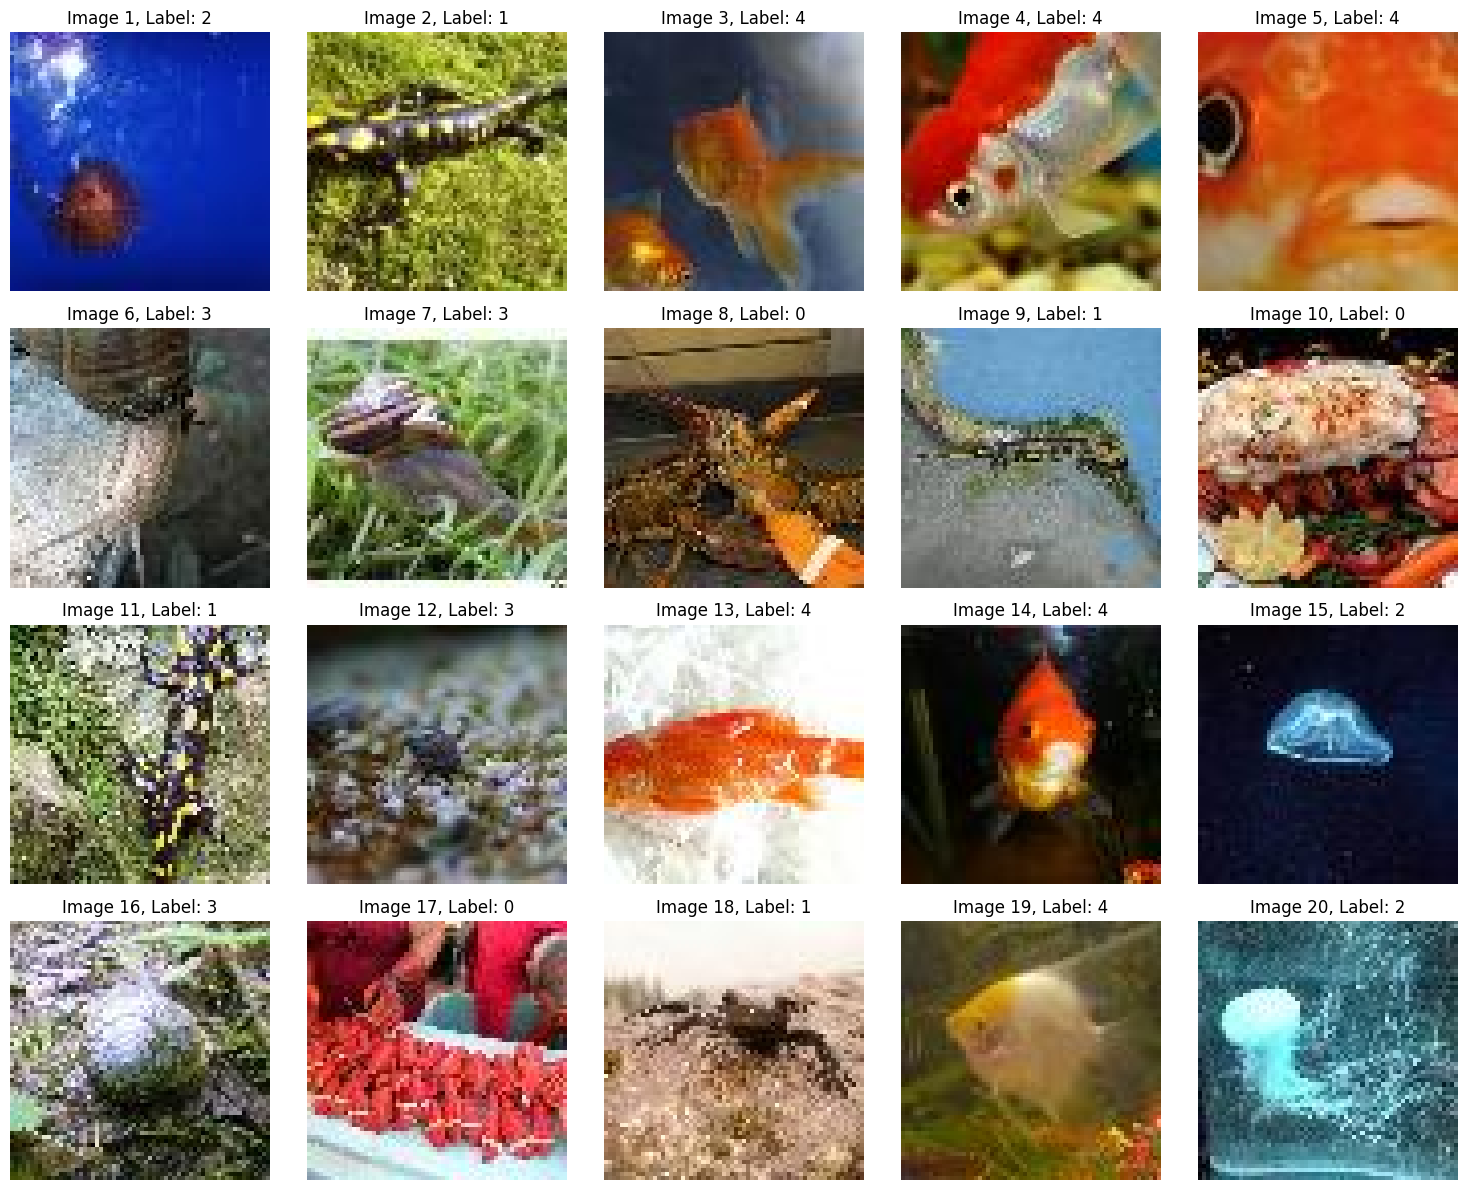

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
acuity transformation applied!
Loading 20 images from val set
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130547_acuity_images.png


<Figure size 640x480 with 0 Axes>

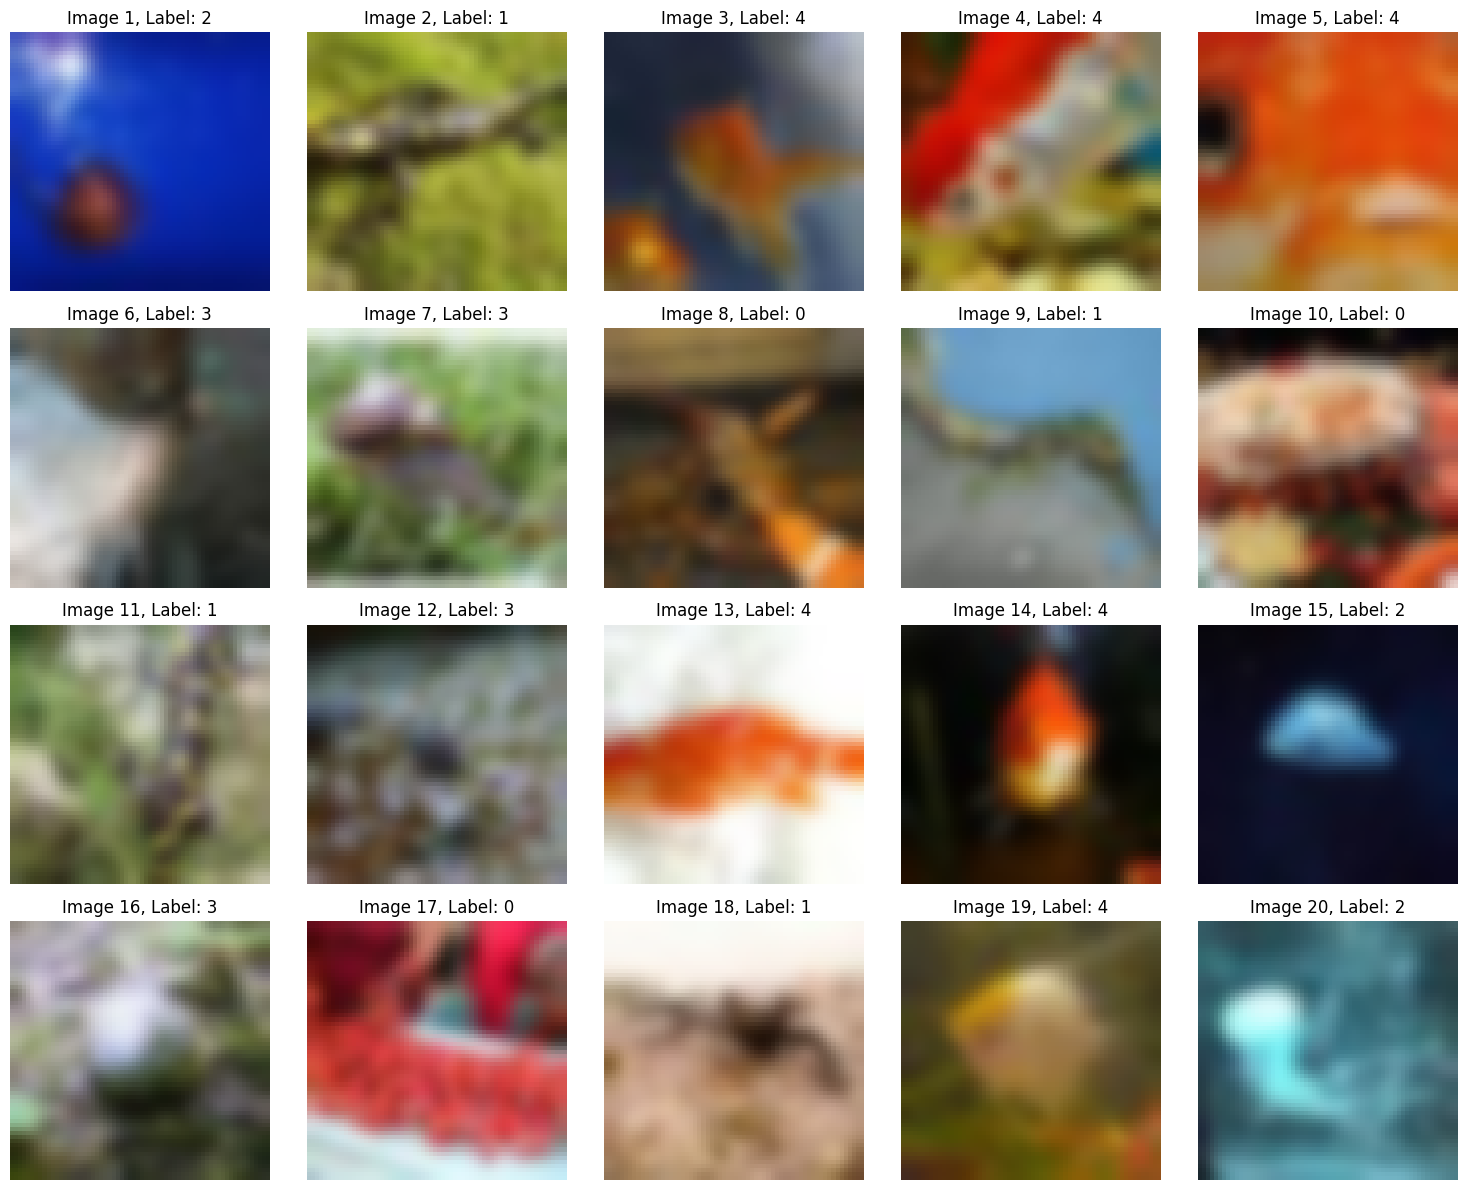

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
cs transformation applied!
Loading 20 images from val set
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130549_cs_images.png


<Figure size 640x480 with 0 Axes>

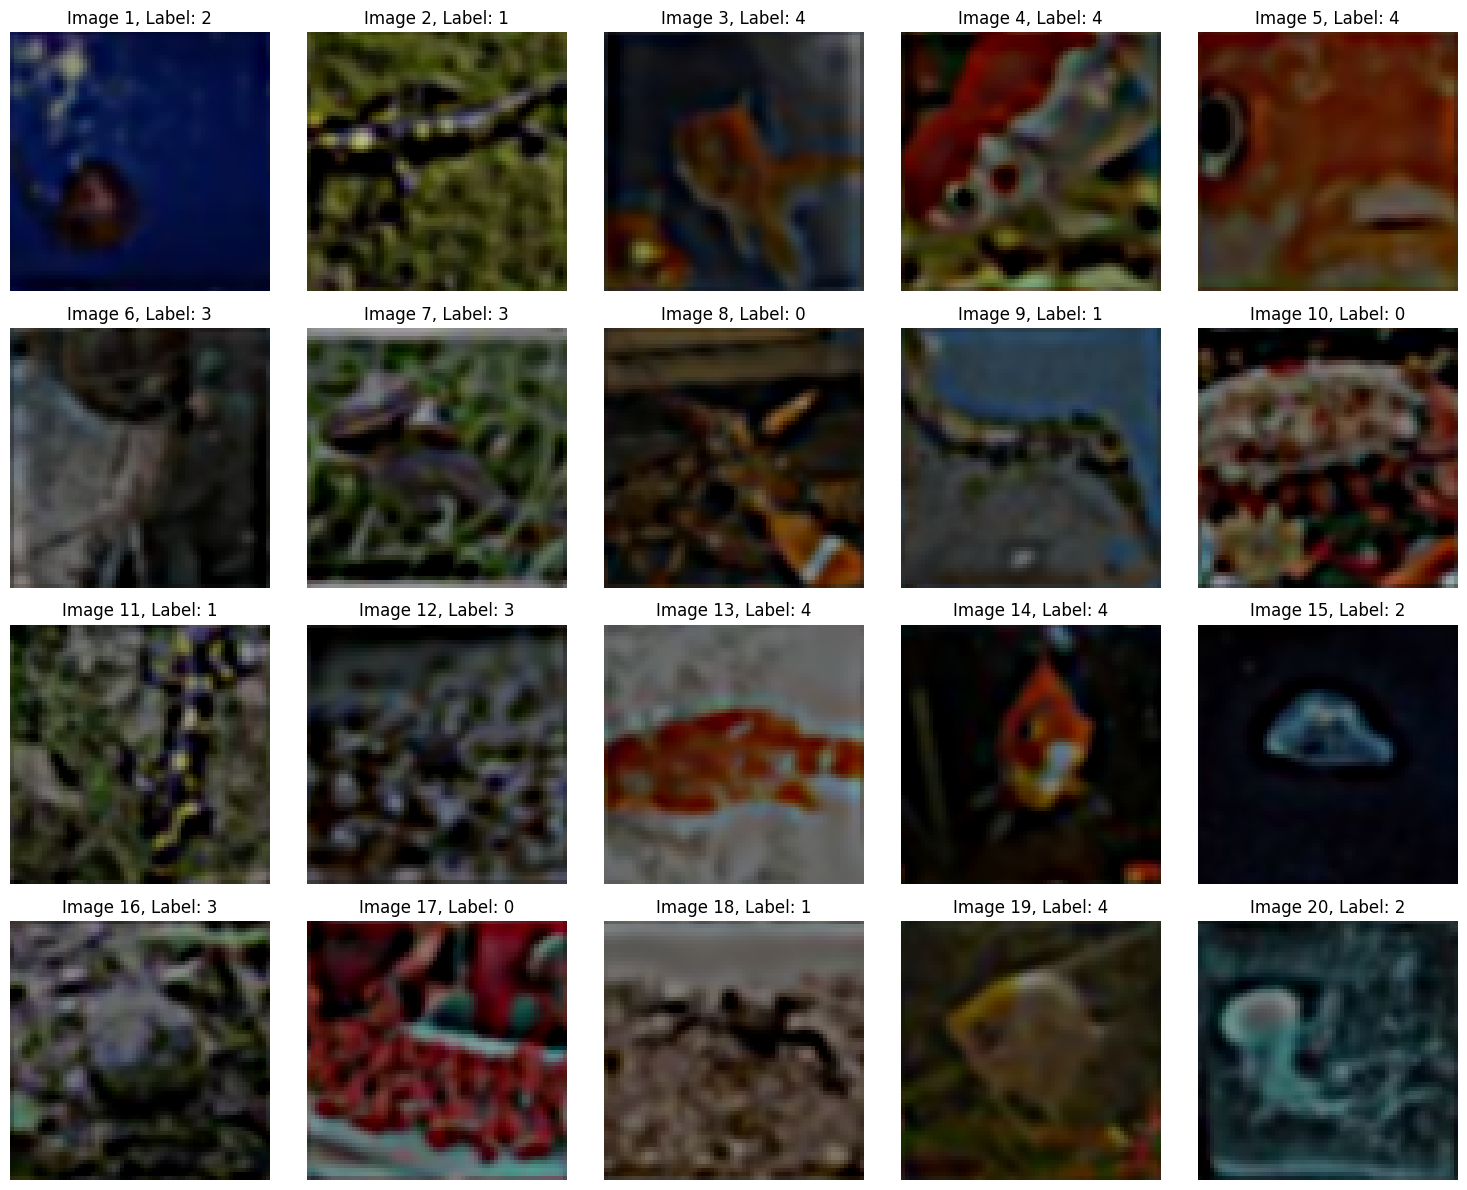

Layer activations for features0:
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130553_features0_activations.png


<Figure size 640x480 with 0 Axes>

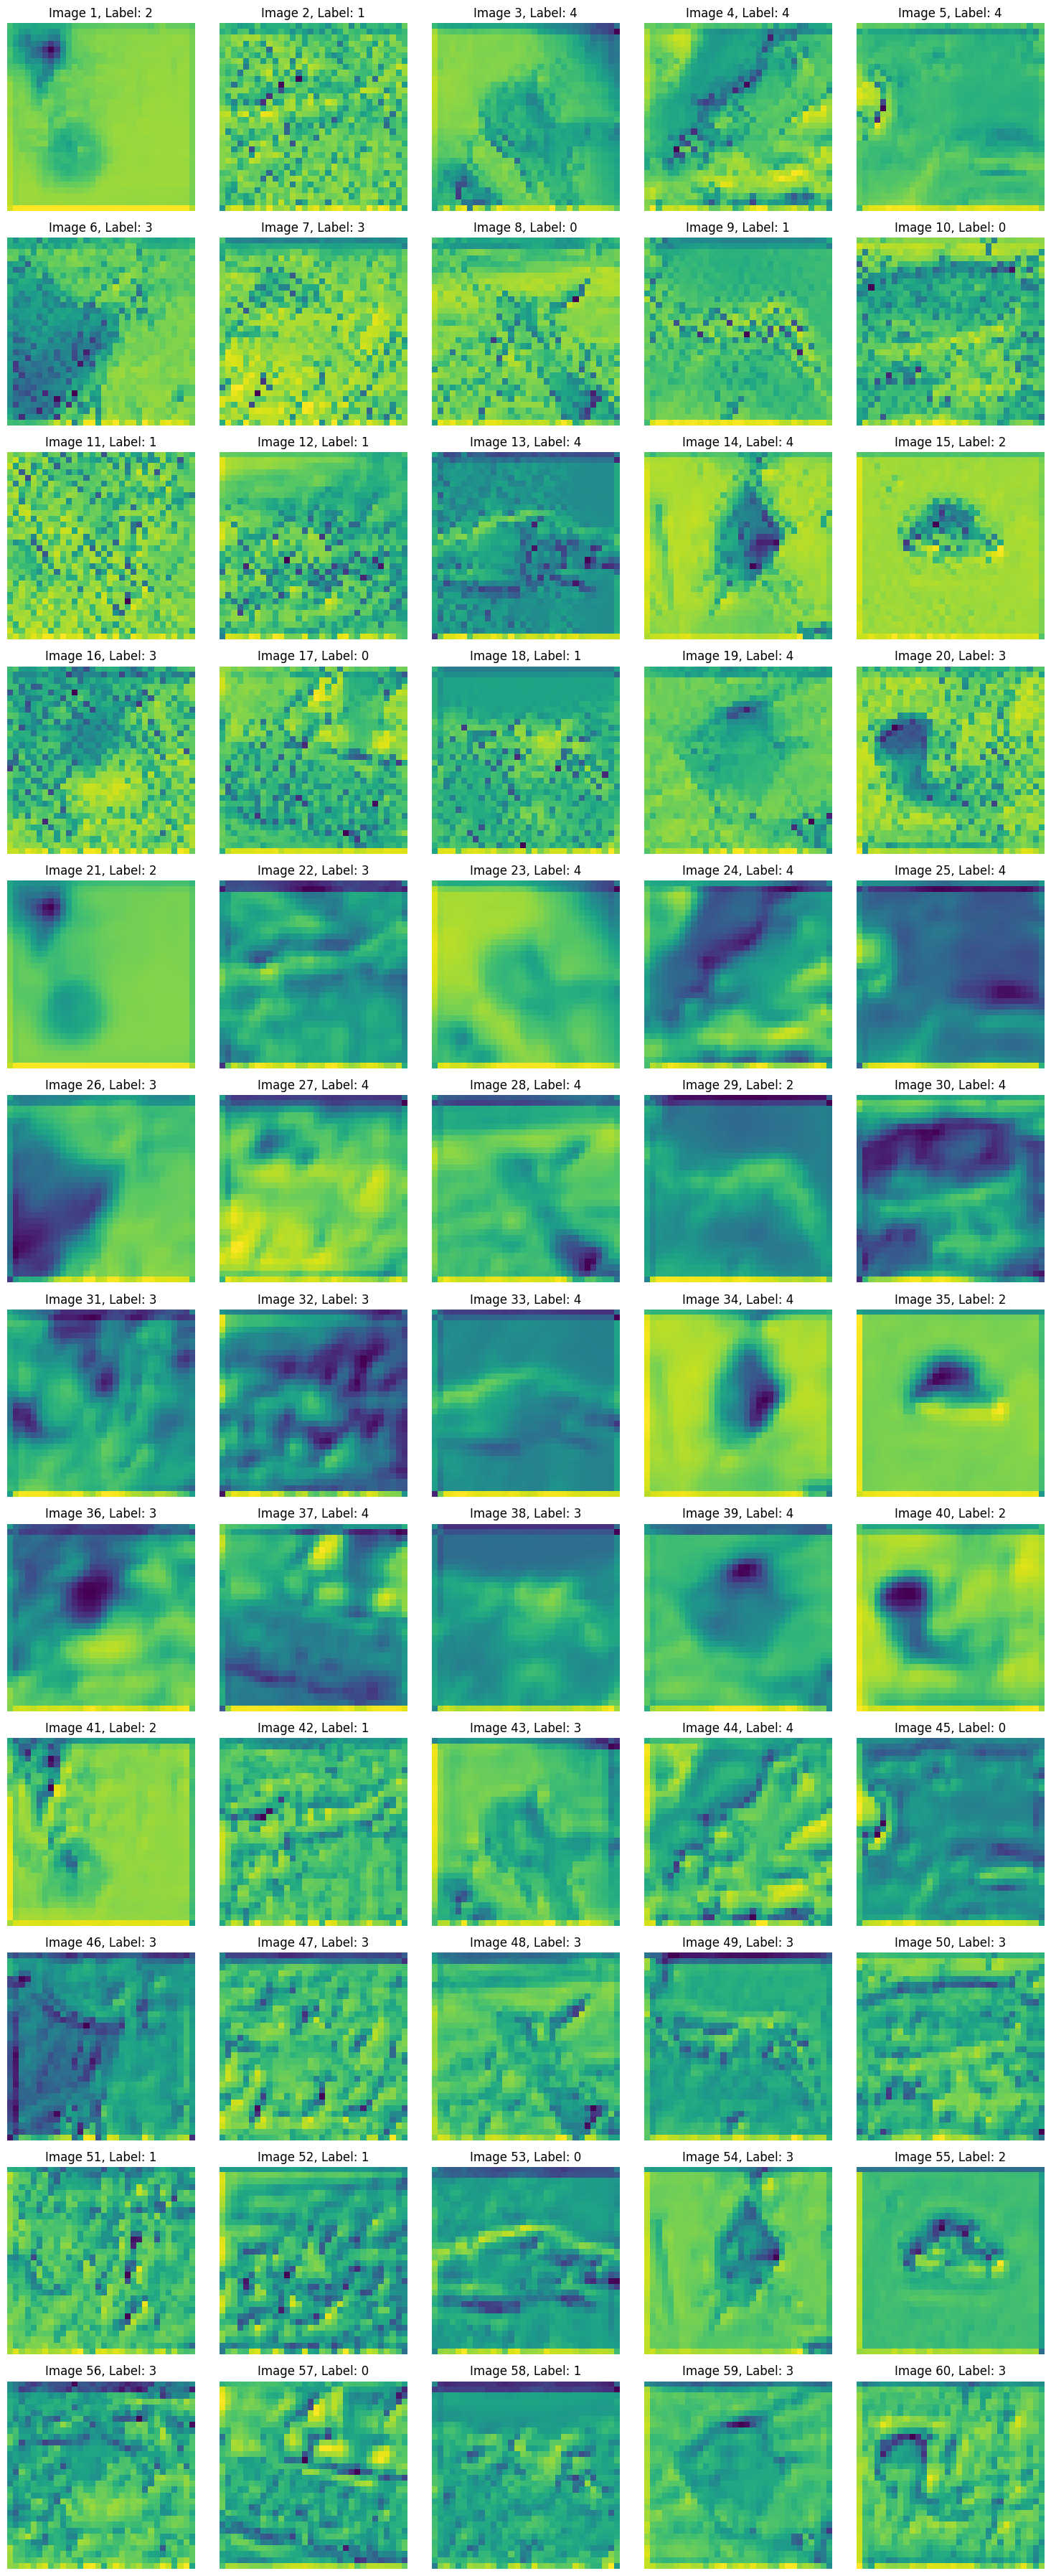

Layer activations for features1:
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130559_features1_activations.png


<Figure size 640x480 with 0 Axes>

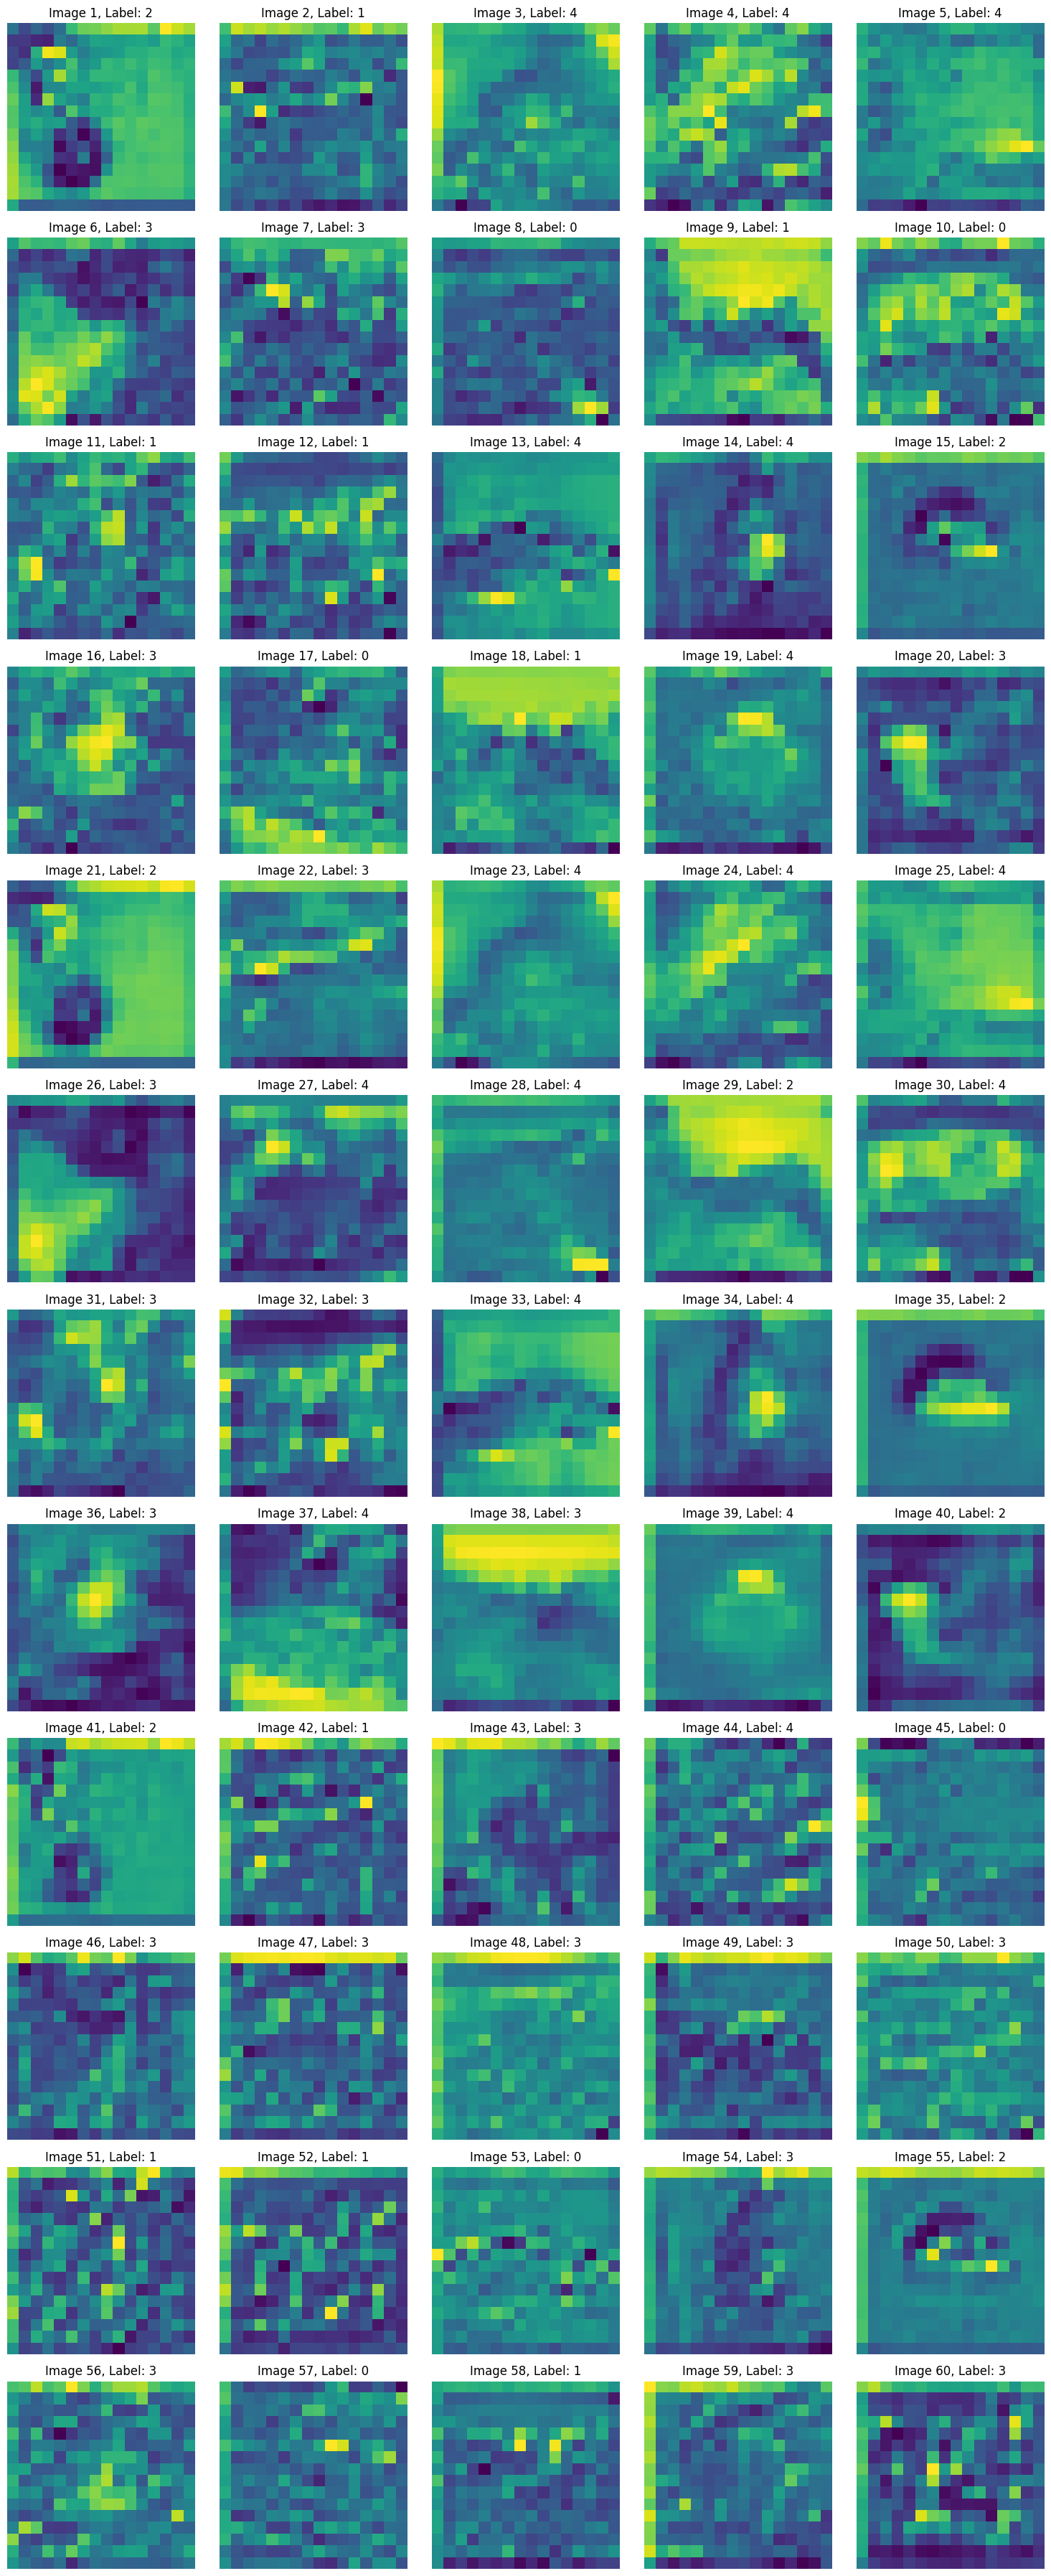

Layer activations for features2:
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130606_features2_activations.png


<Figure size 640x480 with 0 Axes>

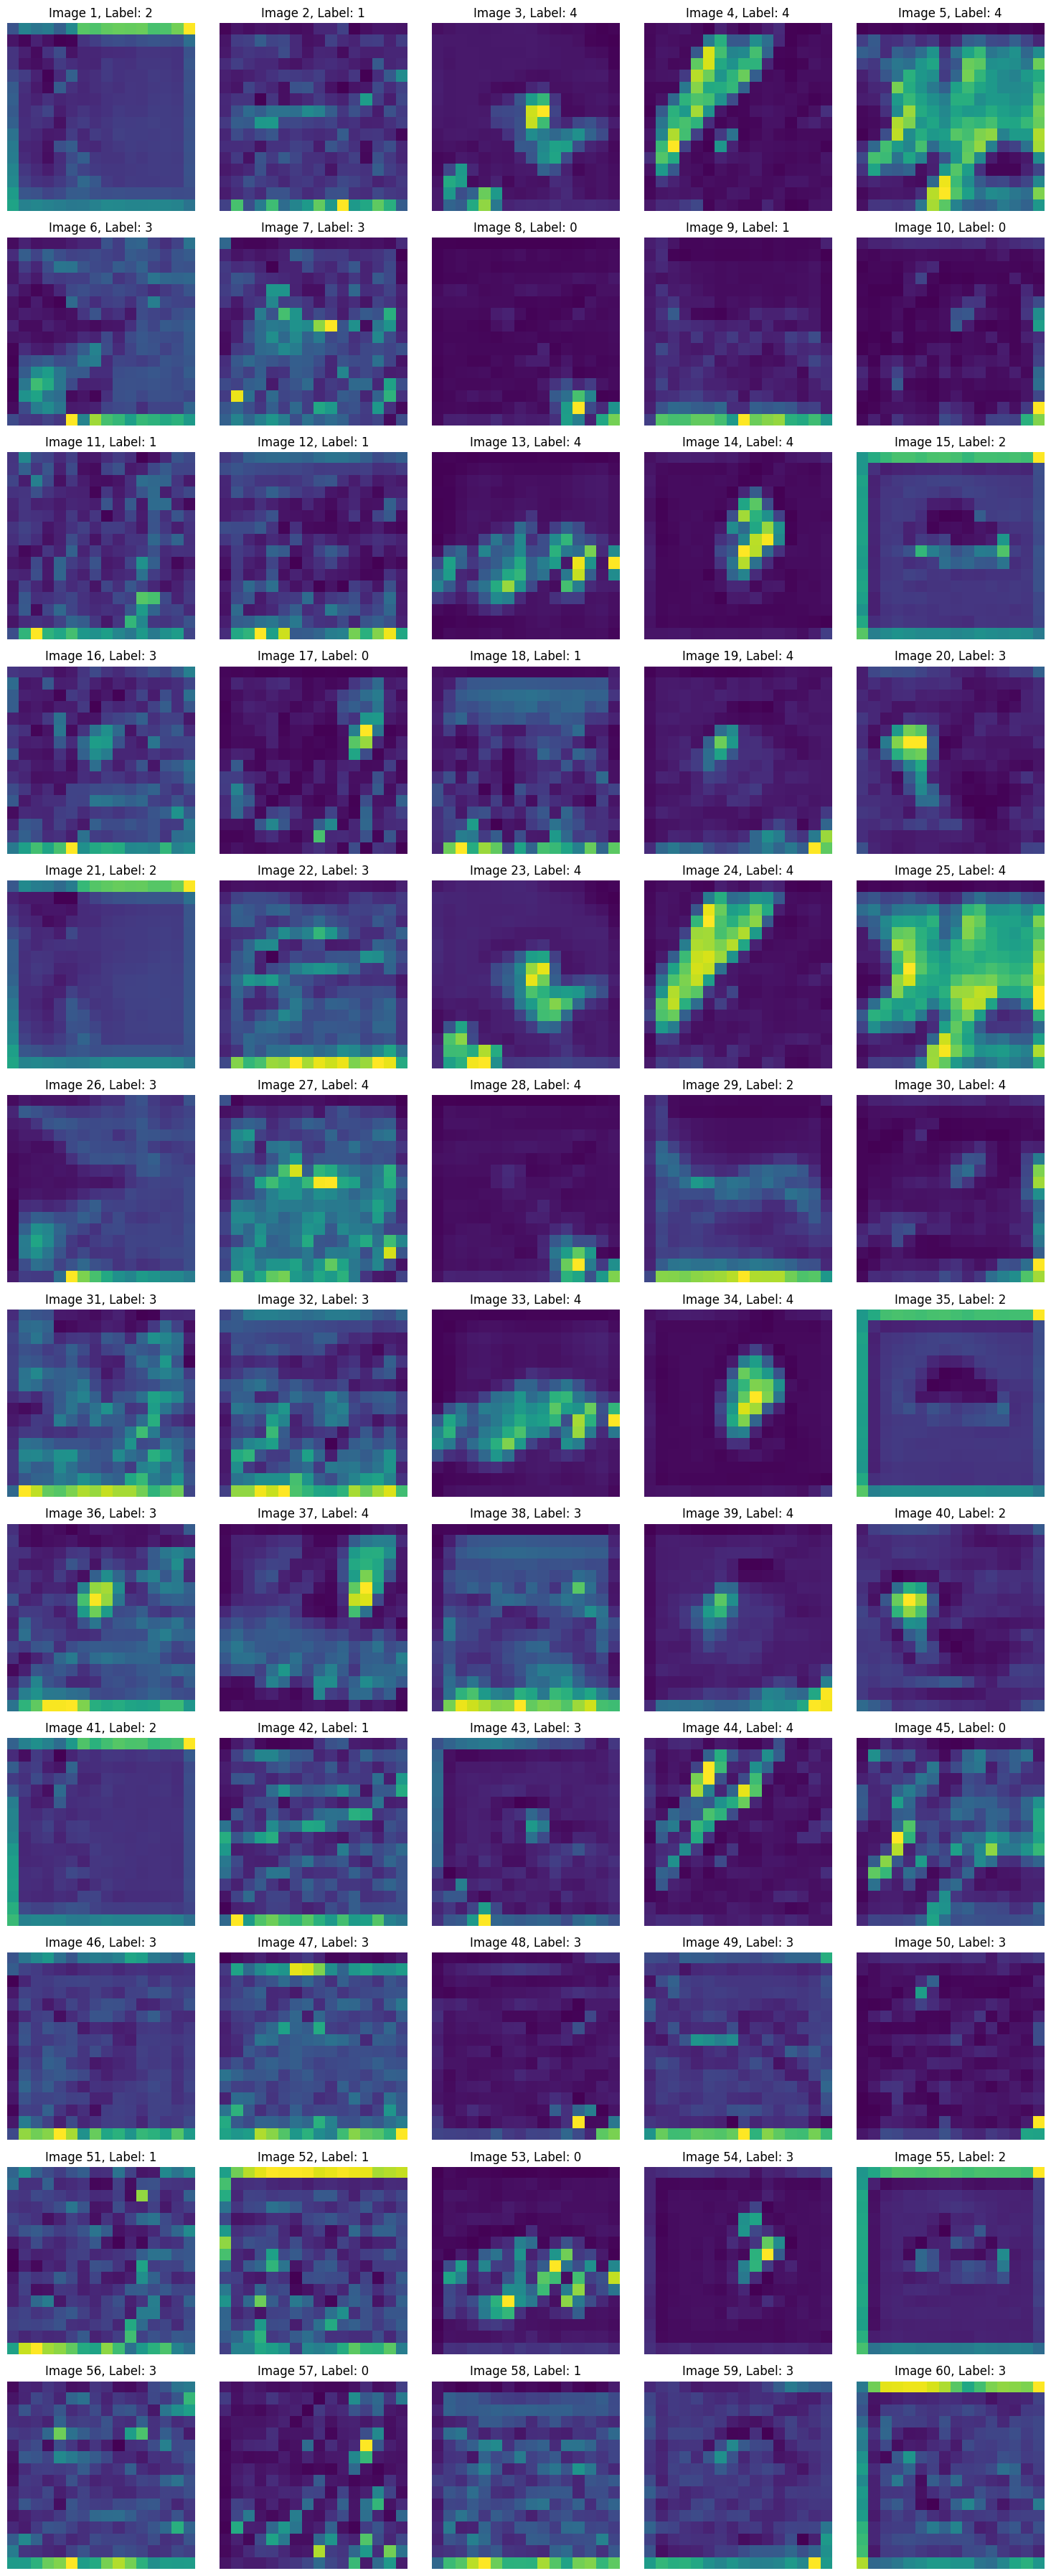

images folder renamed to M1
Loading model from /content/drive/MyDrive/Colab Notebooks/5M2acuity_1_3_5_48.pth
valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
none transformation applied!
Loading 20 images from val set
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130612_none_images.png


<Figure size 640x480 with 0 Axes>

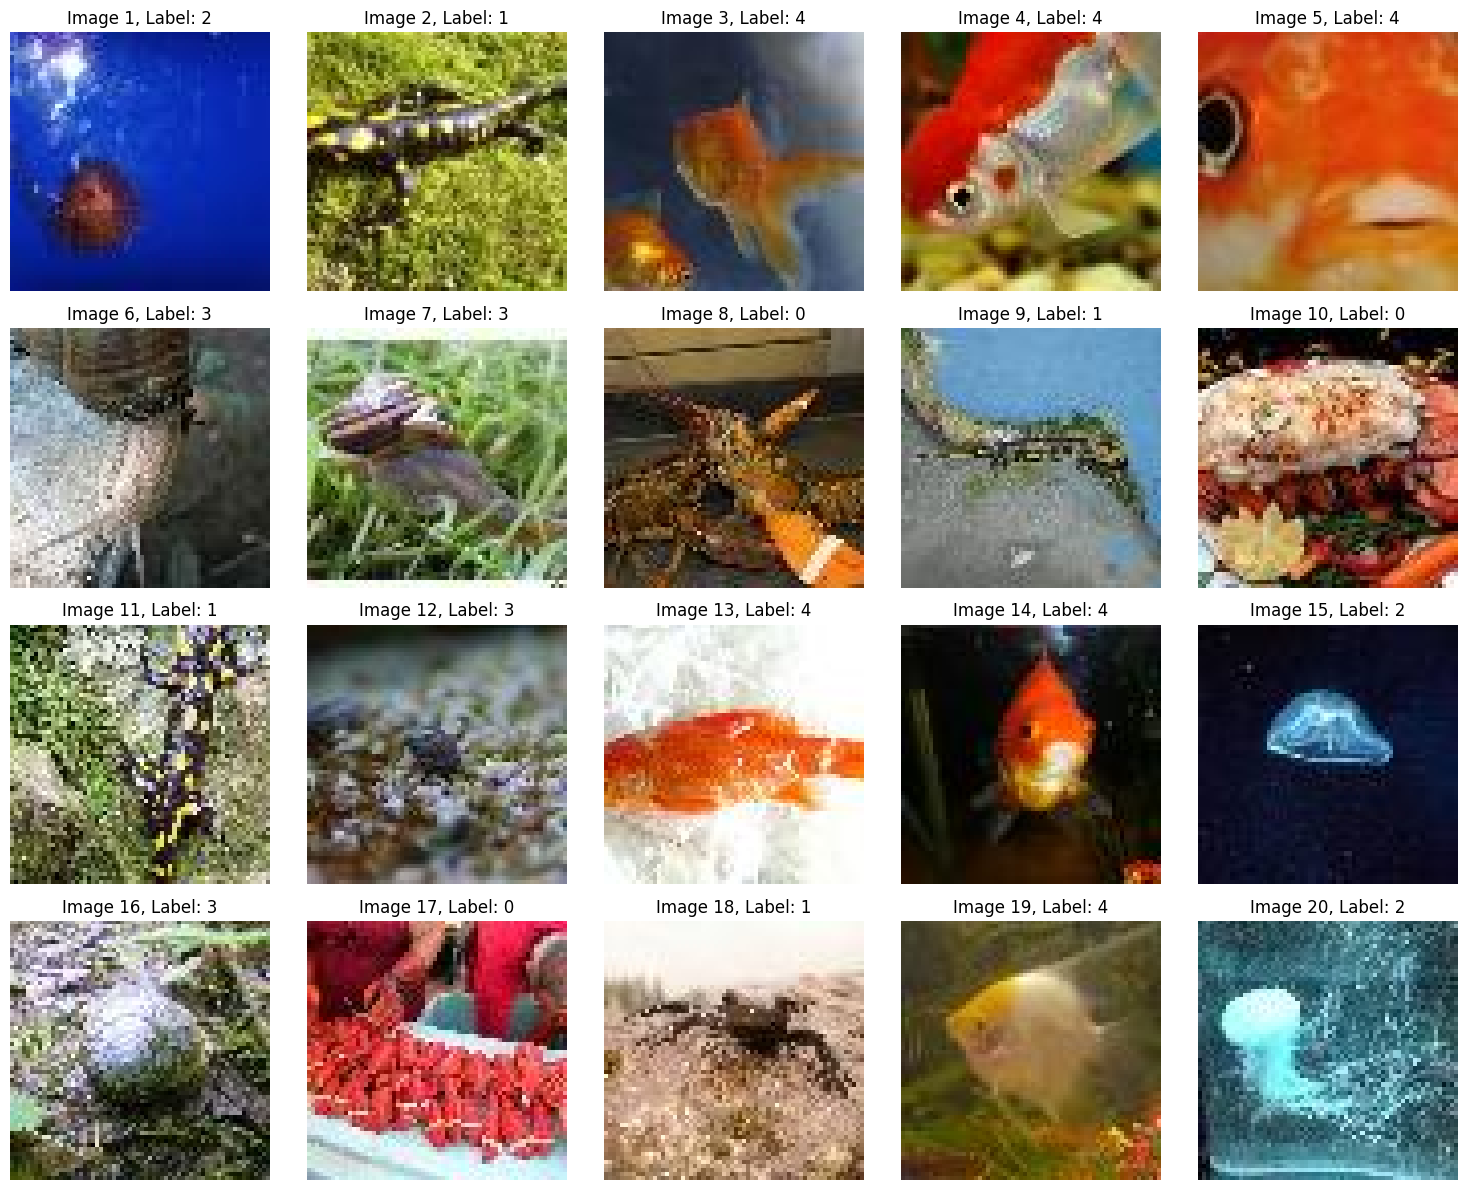

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
acuity transformation applied!
Loading 20 images from val set
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130614_acuity_images.png


<Figure size 640x480 with 0 Axes>

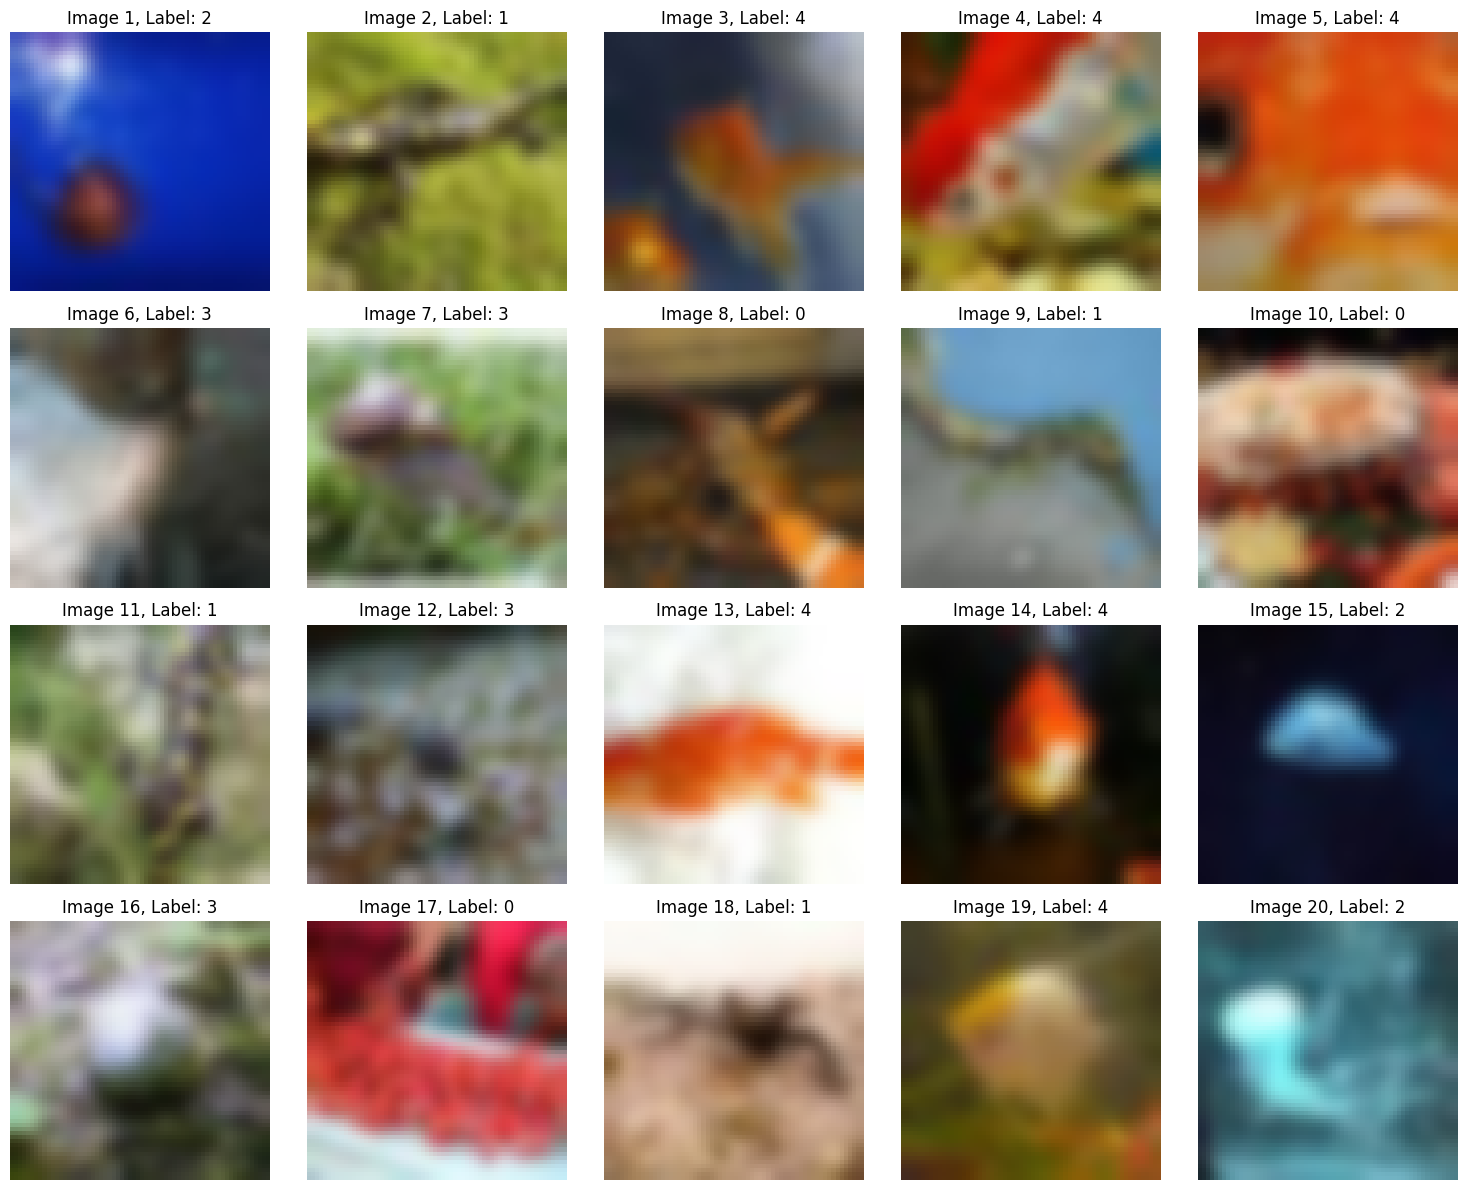

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
cs transformation applied!
Loading 20 images from val set
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130617_cs_images.png


<Figure size 640x480 with 0 Axes>

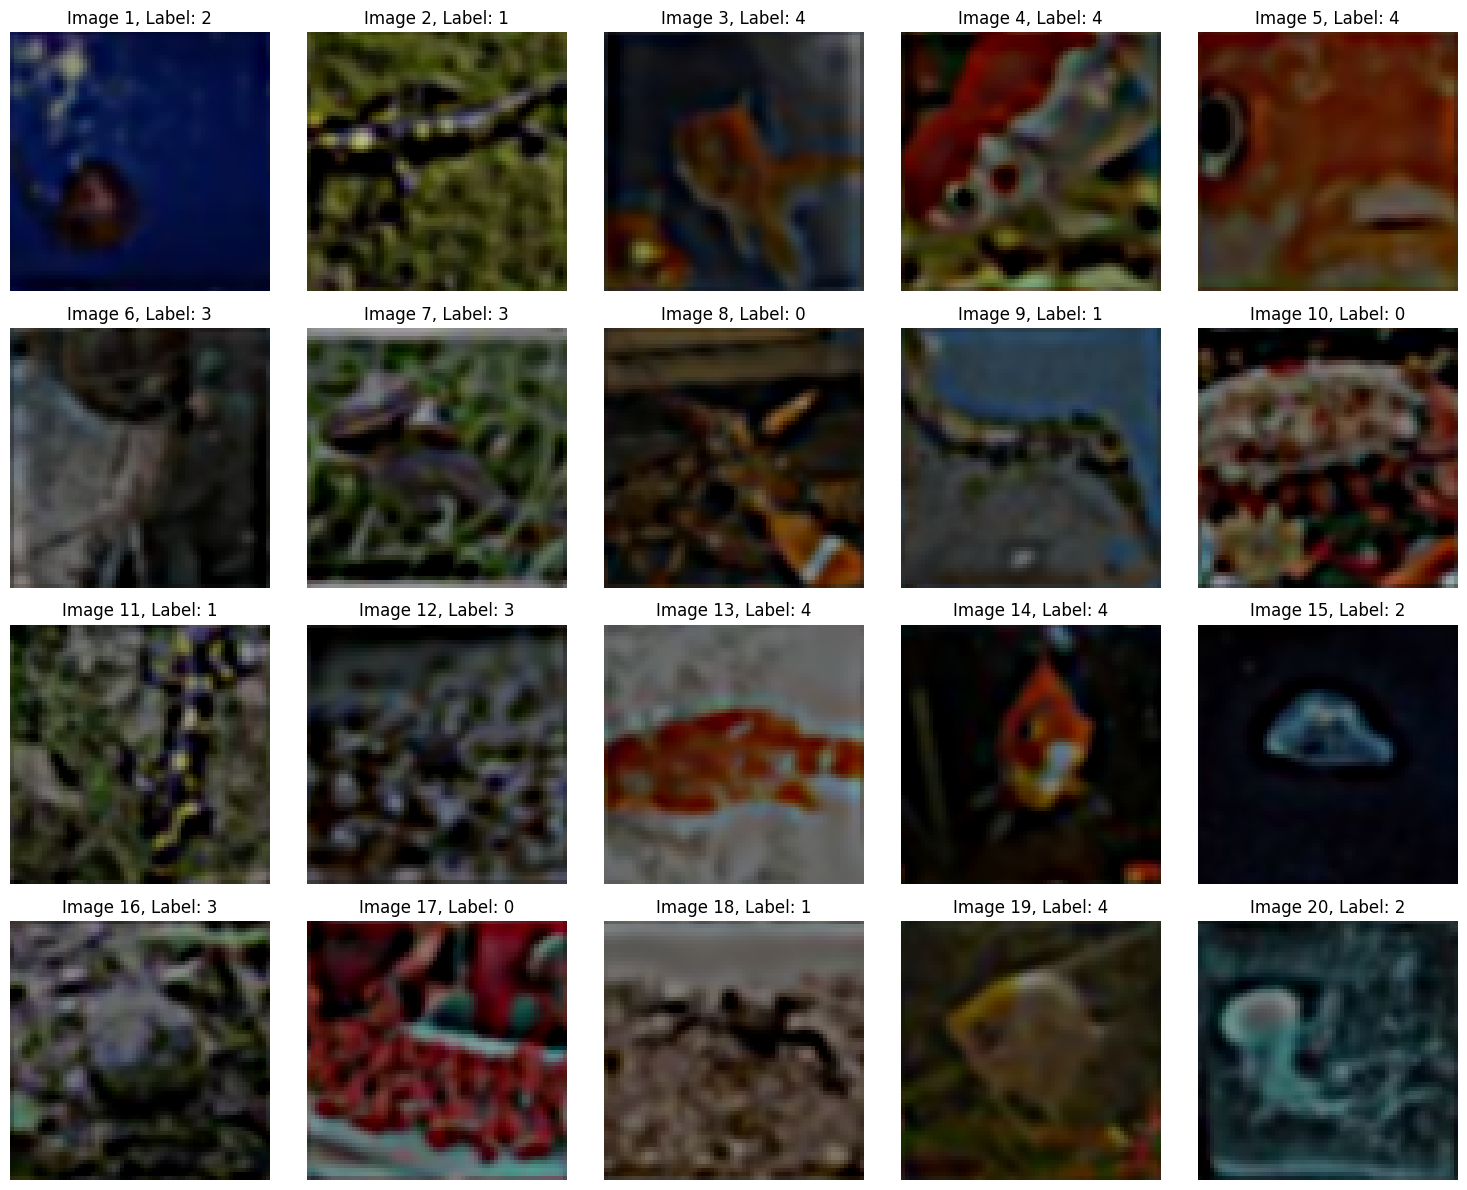

Layer activations for features0:
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130620_features0_activations.png


<Figure size 640x480 with 0 Axes>

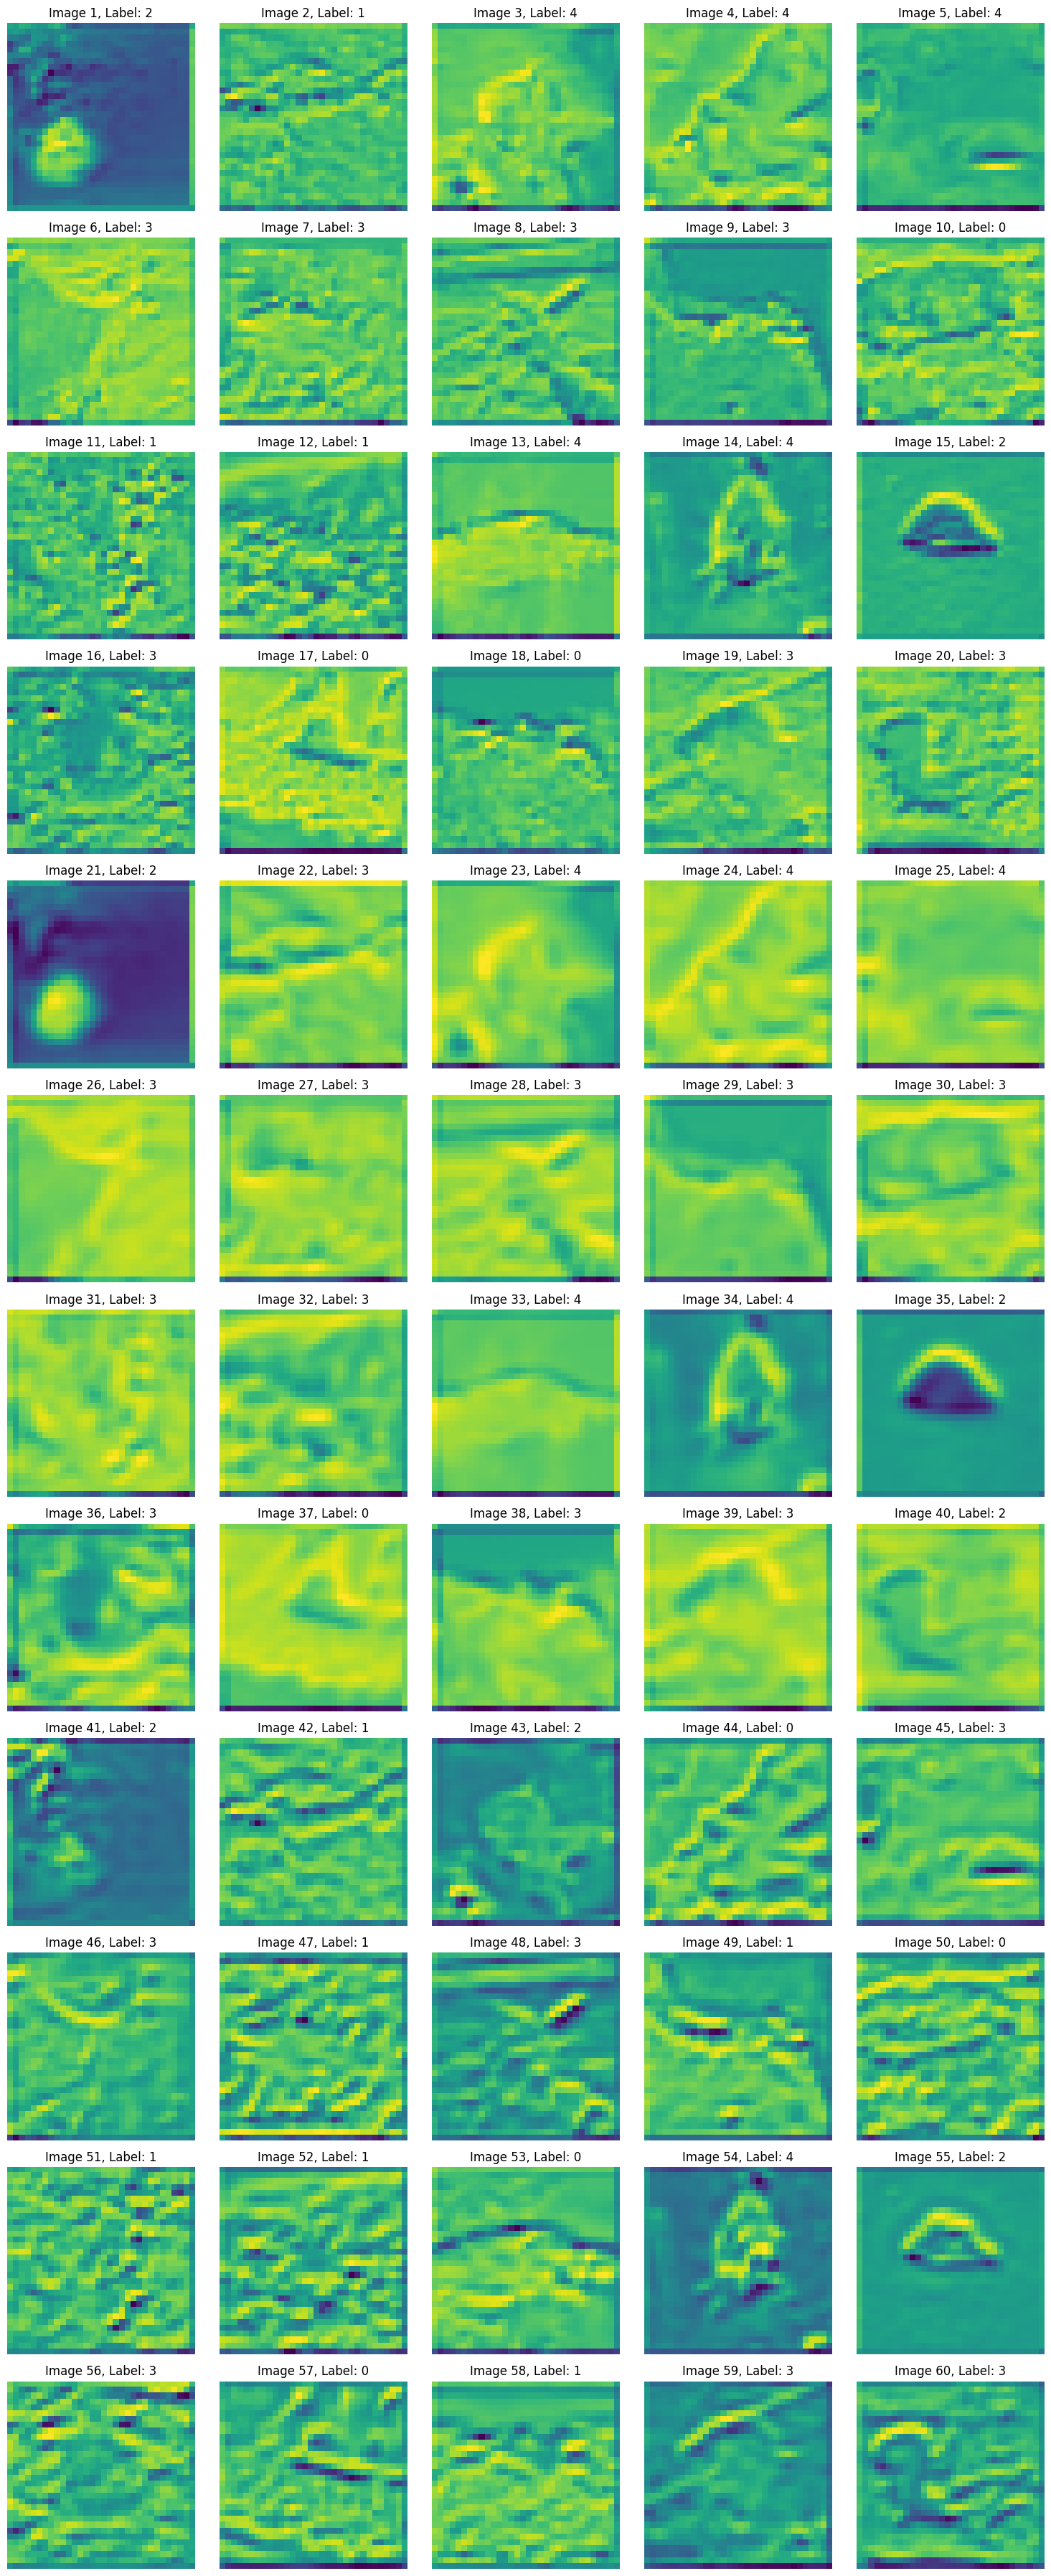

Layer activations for features1:
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130627_features1_activations.png


<Figure size 640x480 with 0 Axes>

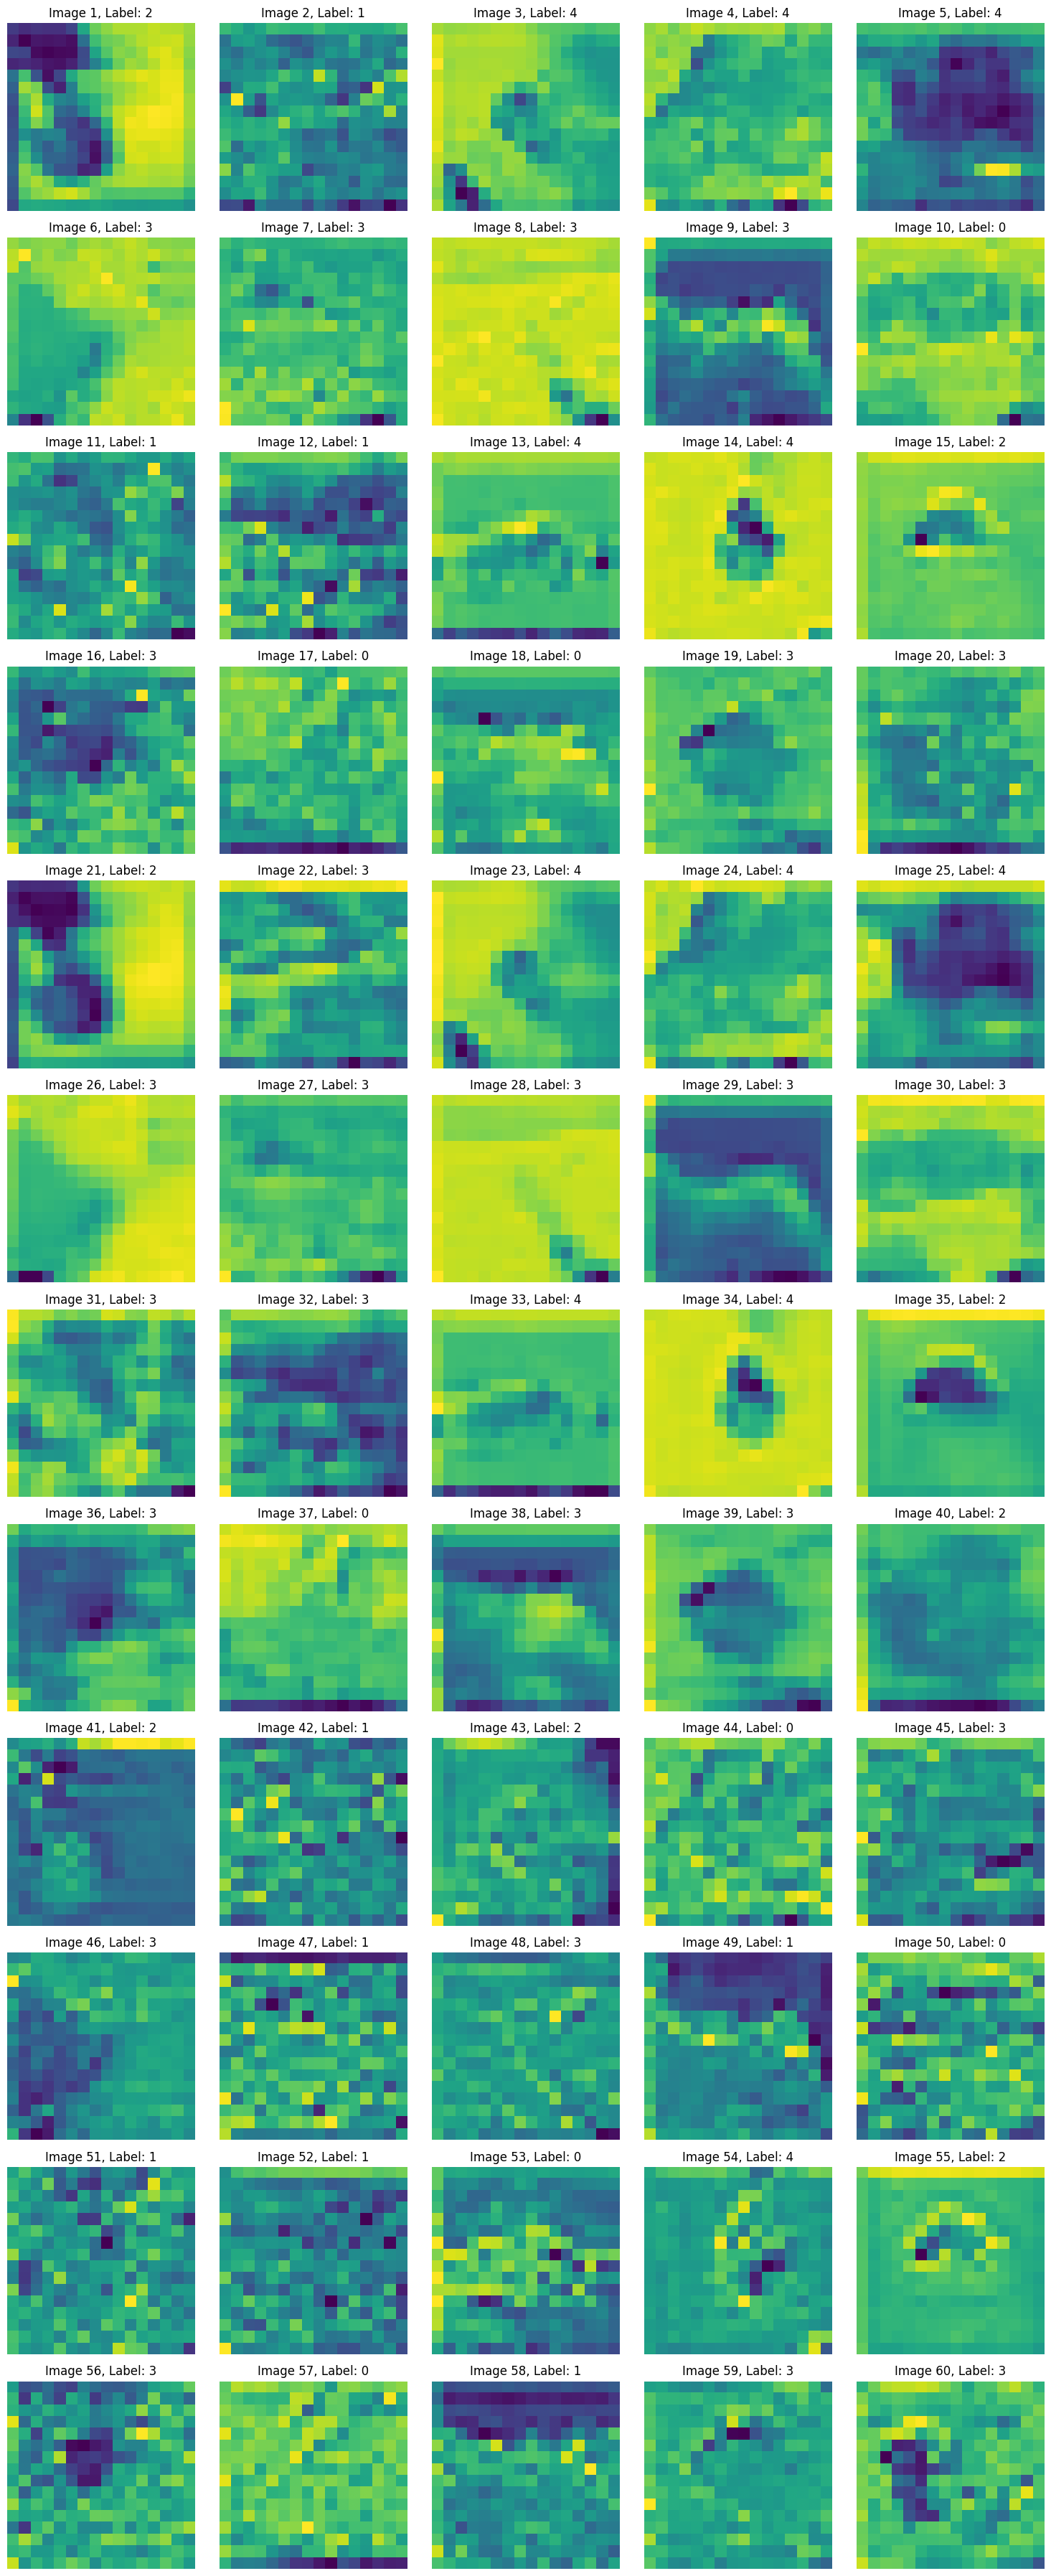

Layer activations for features2:
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130634_features2_activations.png


<Figure size 640x480 with 0 Axes>

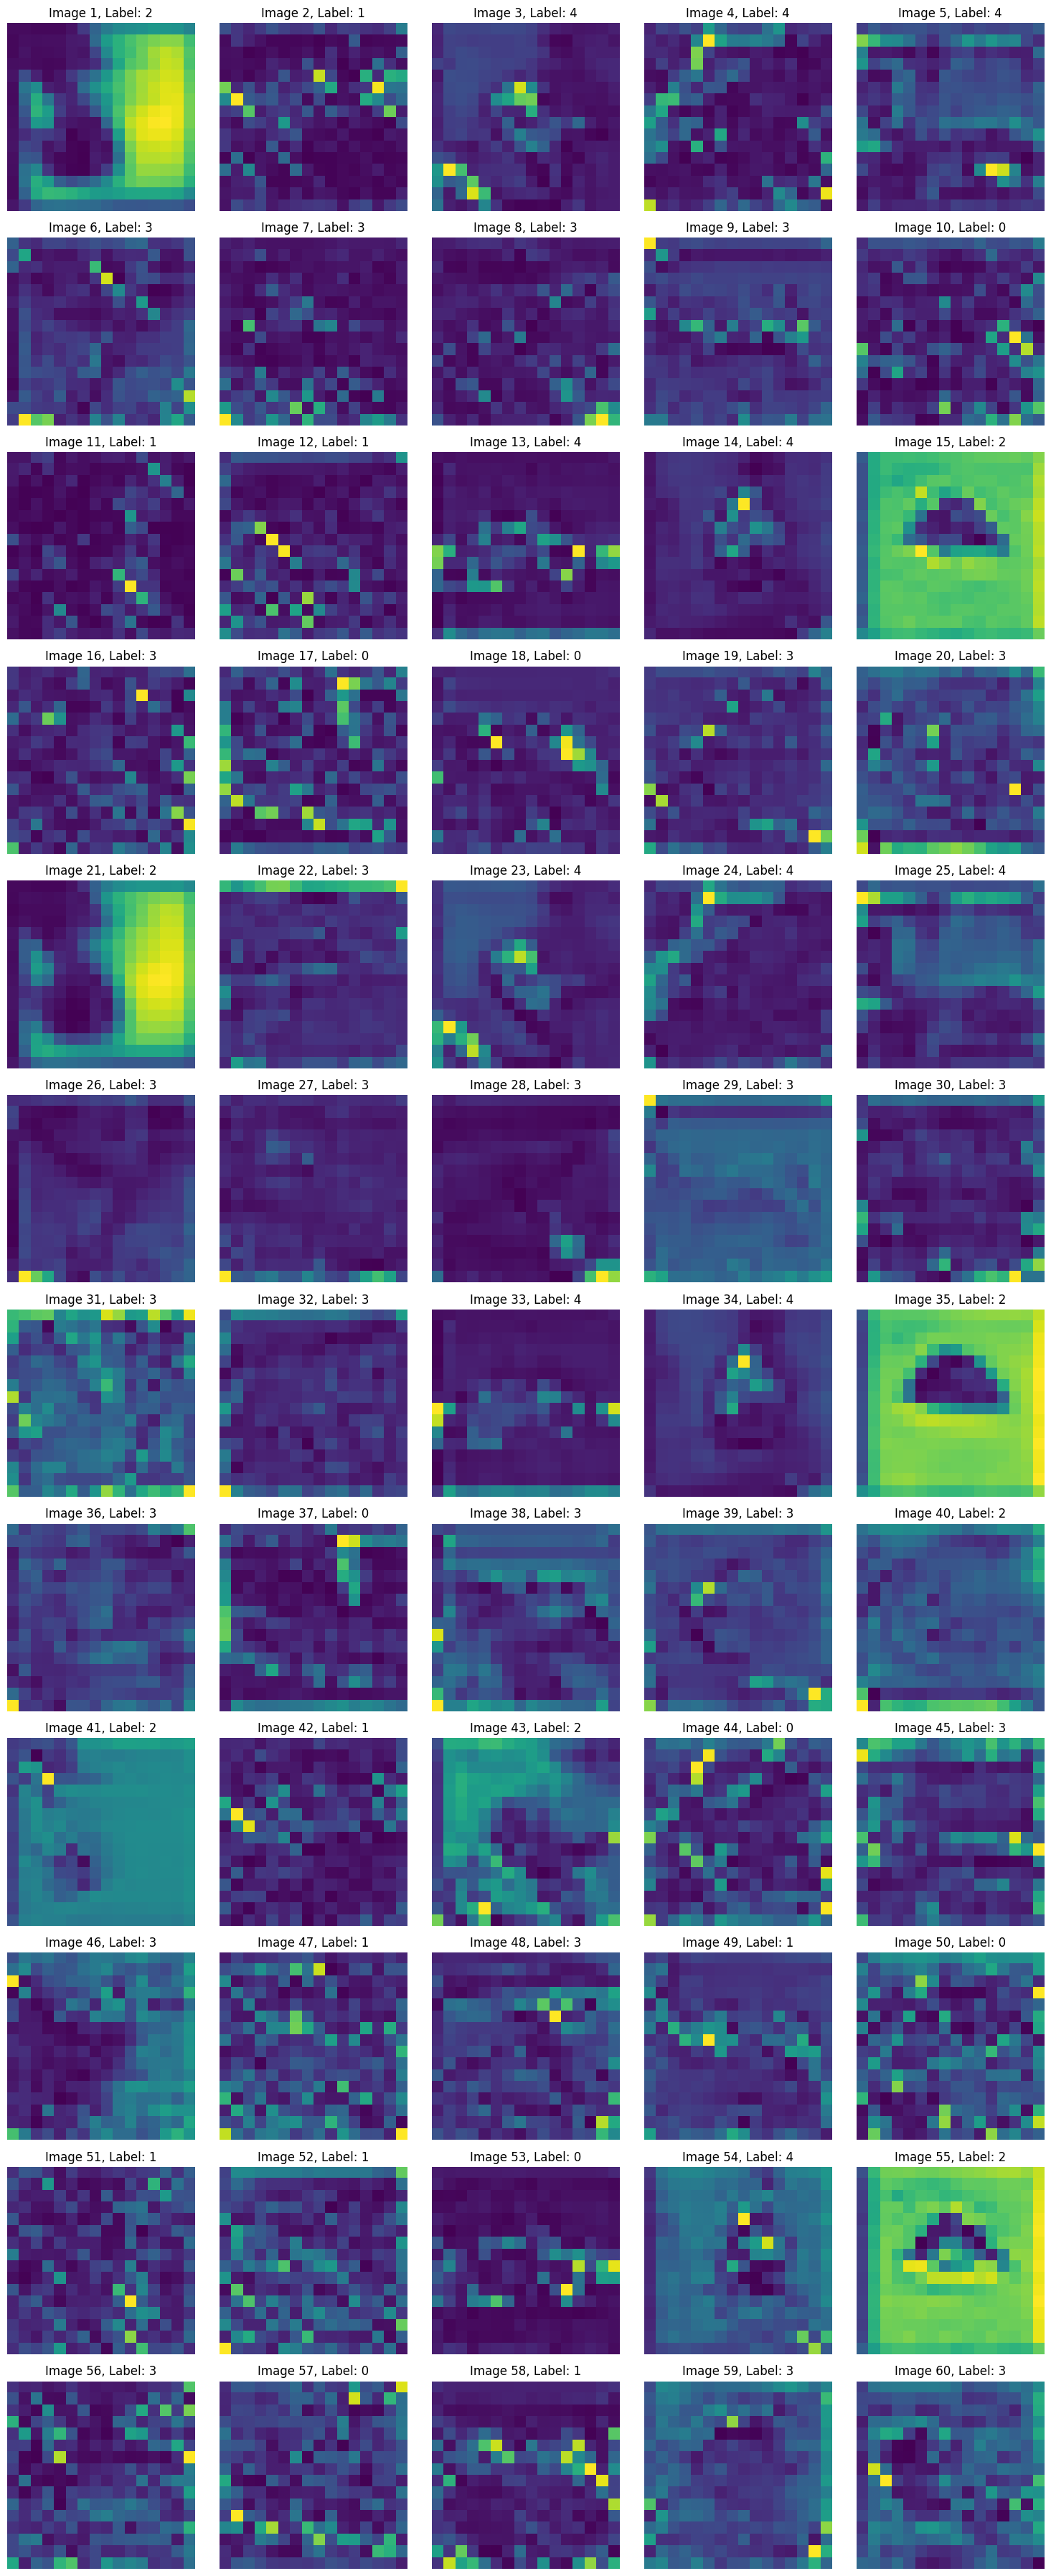

images folder renamed to M2
Loading model from /content/drive/MyDrive/Colab Notebooks/5M3cs_1_3_8_48.pth
valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
none transformation applied!
Loading 20 images from val set
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130641_none_images.png


<Figure size 640x480 with 0 Axes>

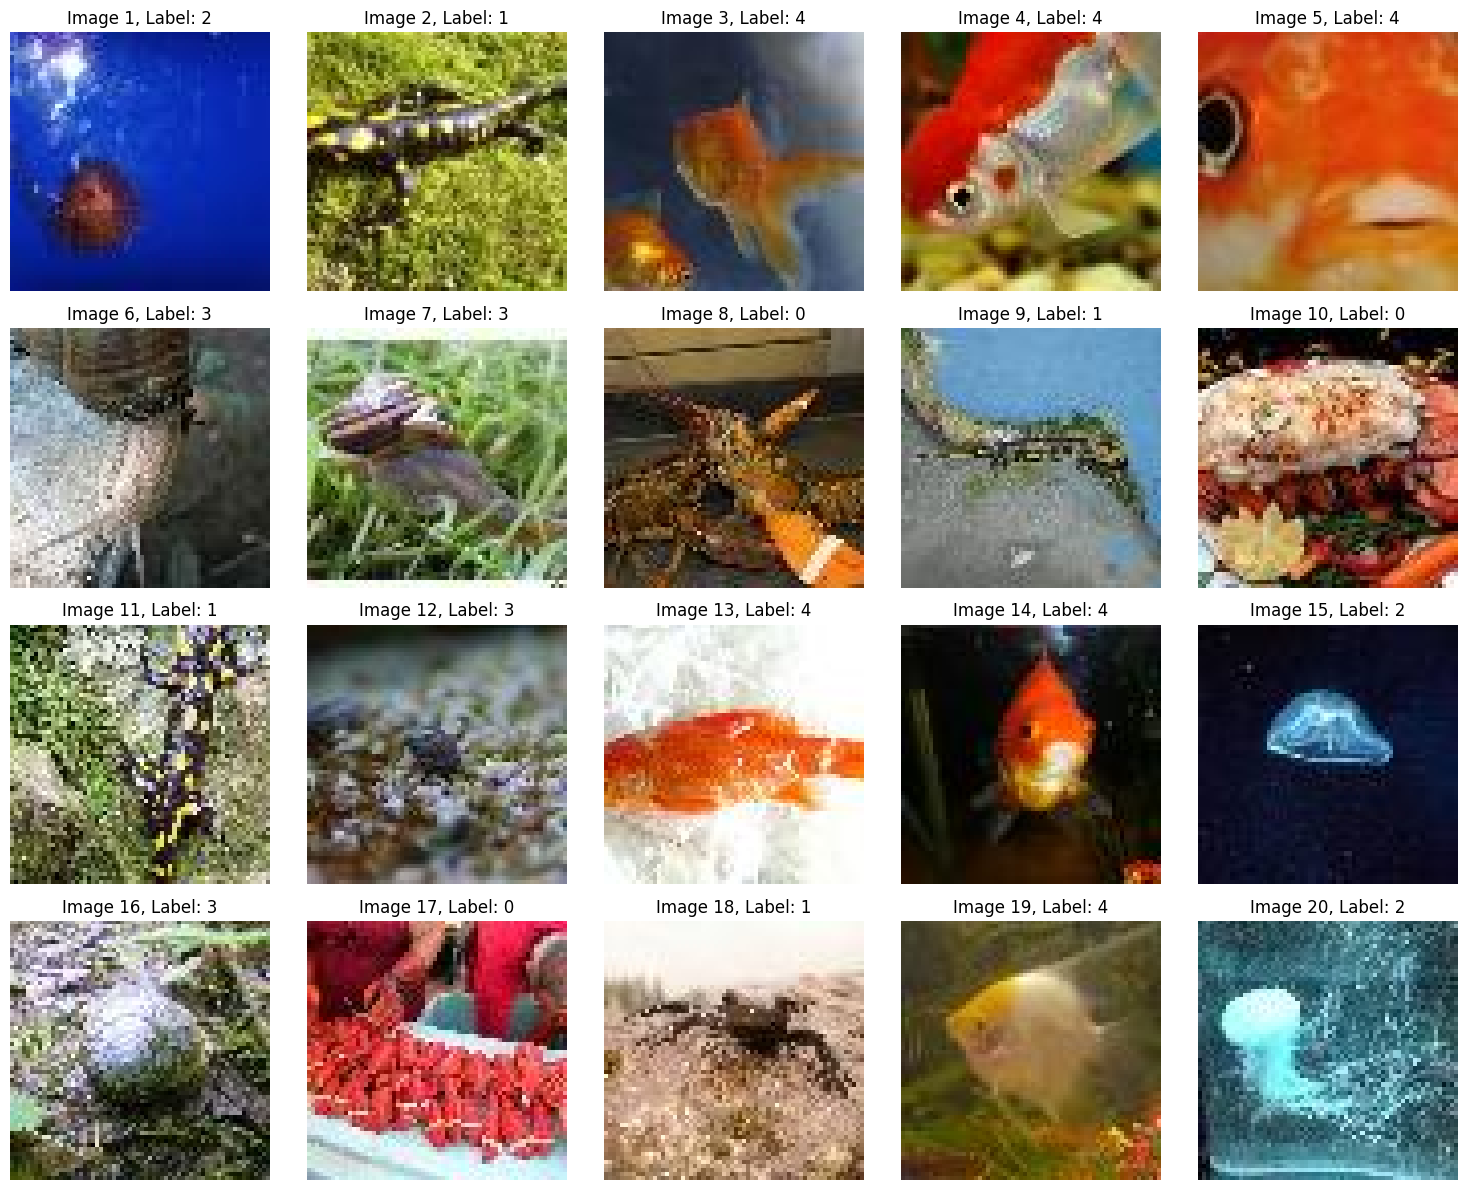

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
acuity transformation applied!
Loading 20 images from val set
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130643_acuity_images.png


<Figure size 640x480 with 0 Axes>

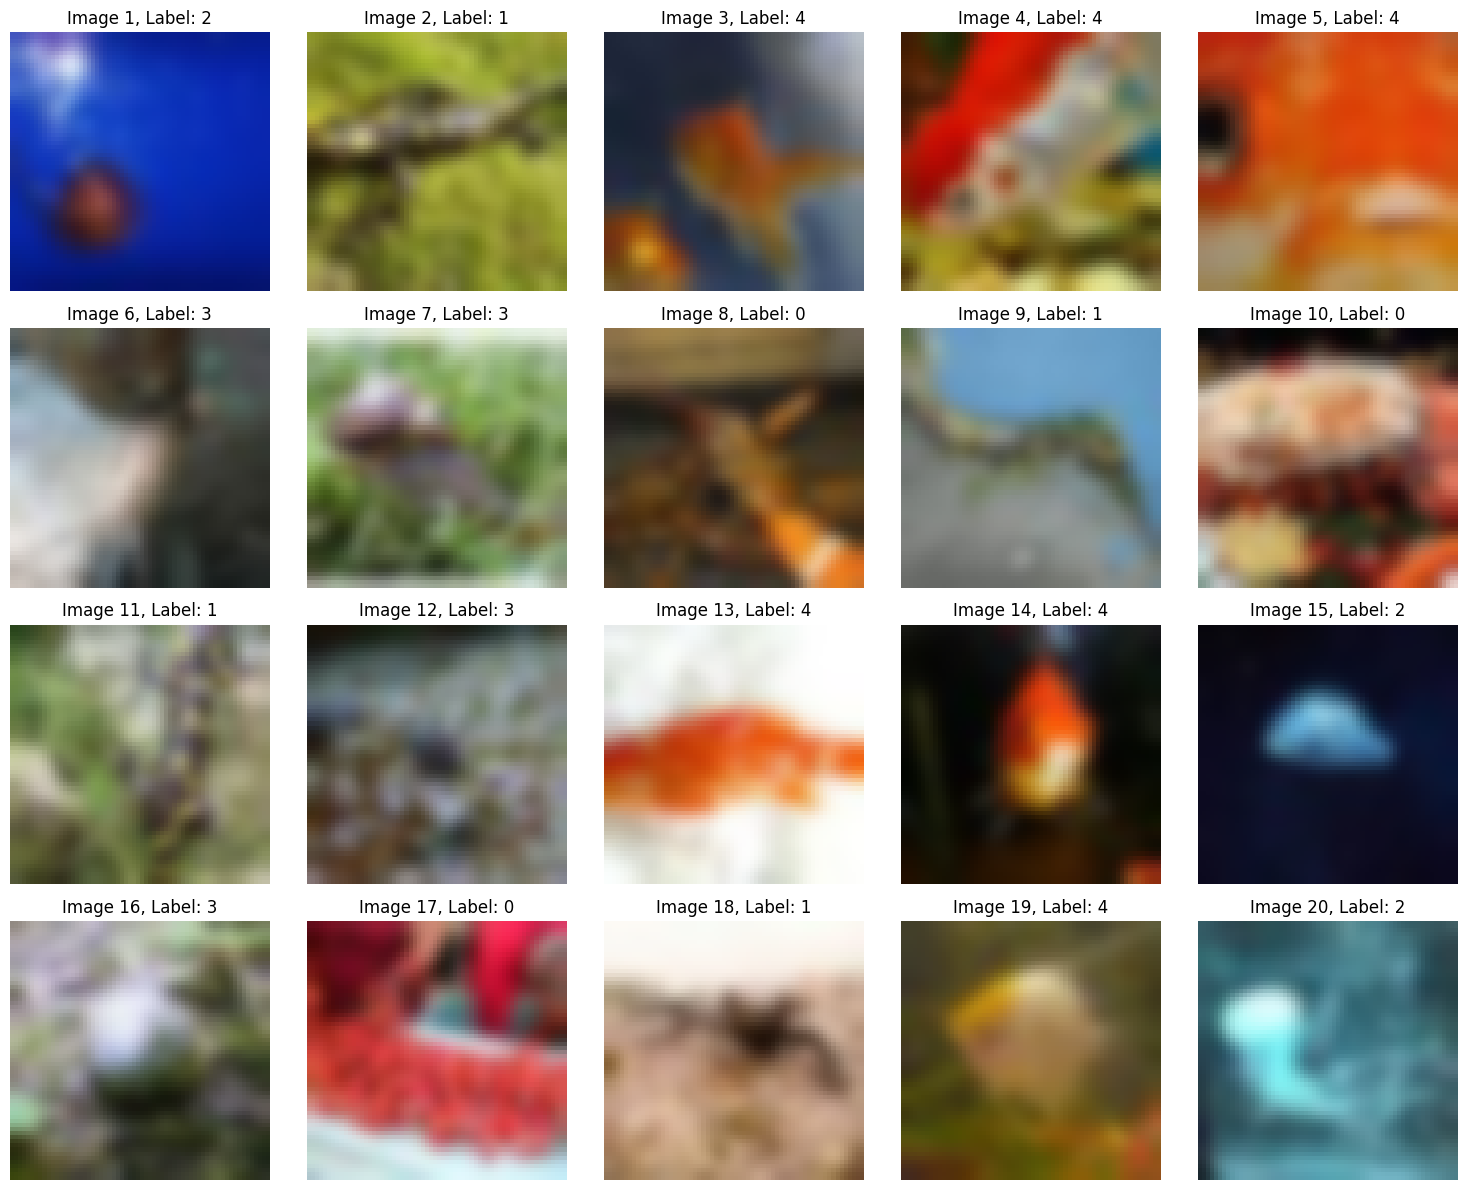

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
cs transformation applied!
Loading 20 images from val set
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130645_cs_images.png


<Figure size 640x480 with 0 Axes>

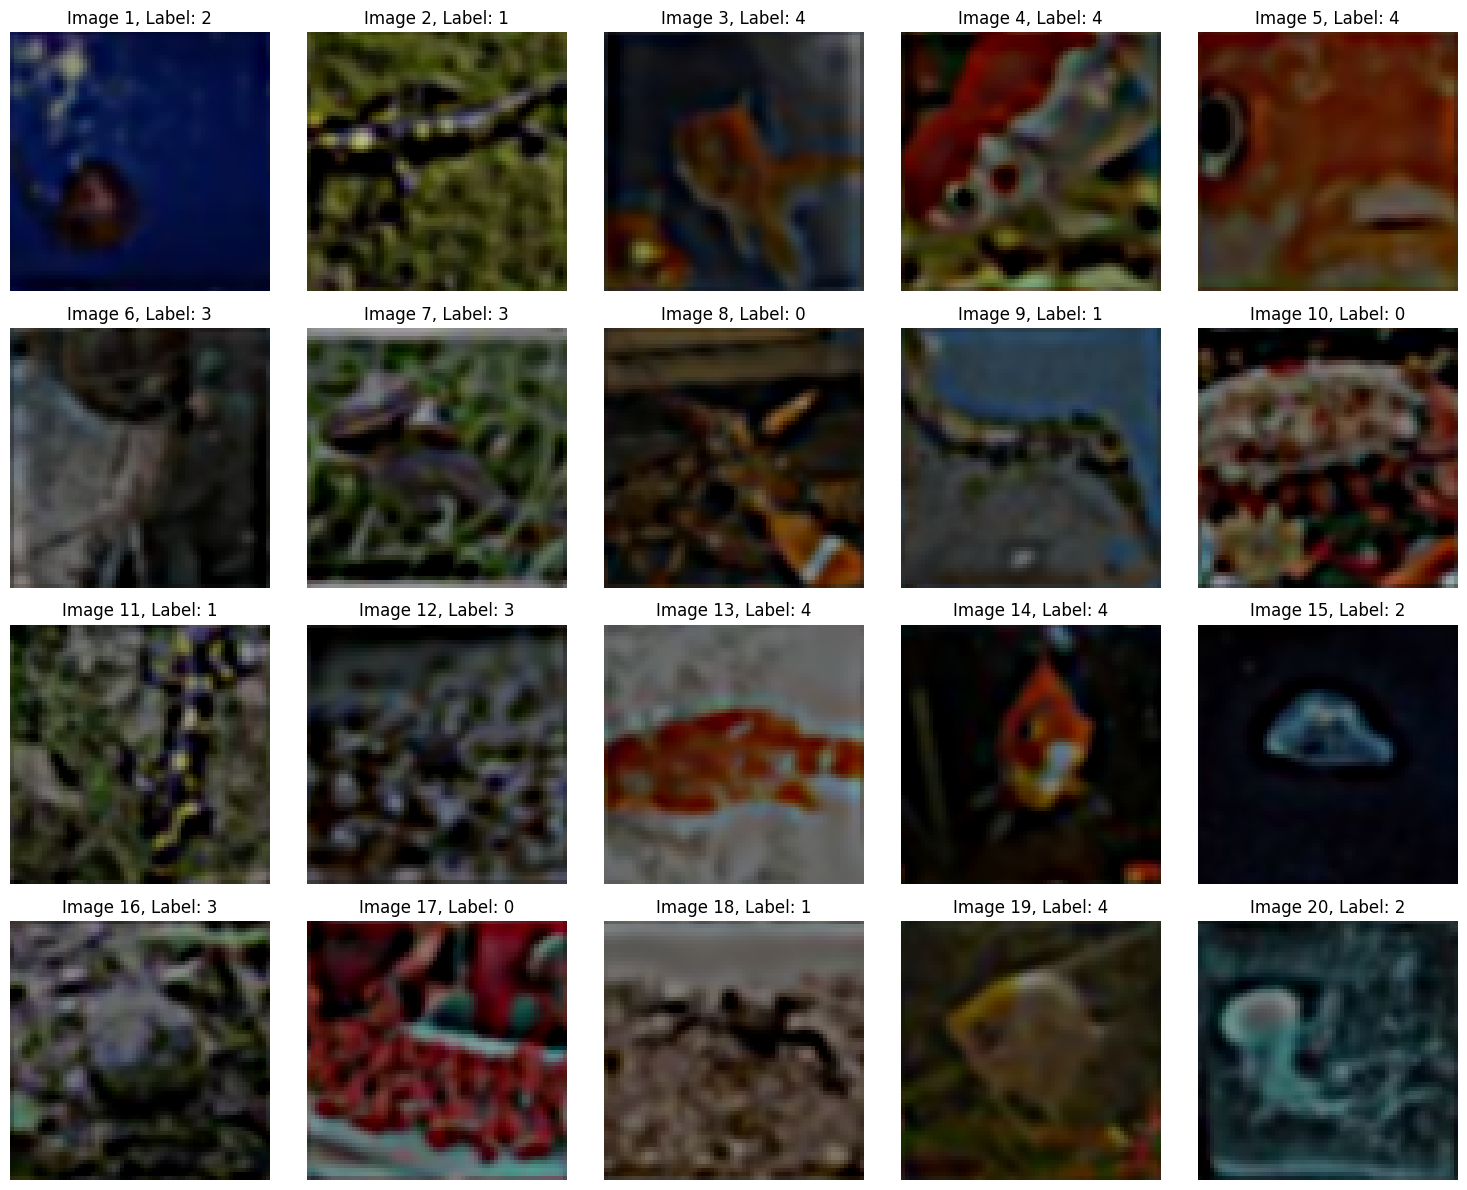

Layer activations for features0:
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130649_features0_activations.png


<Figure size 640x480 with 0 Axes>

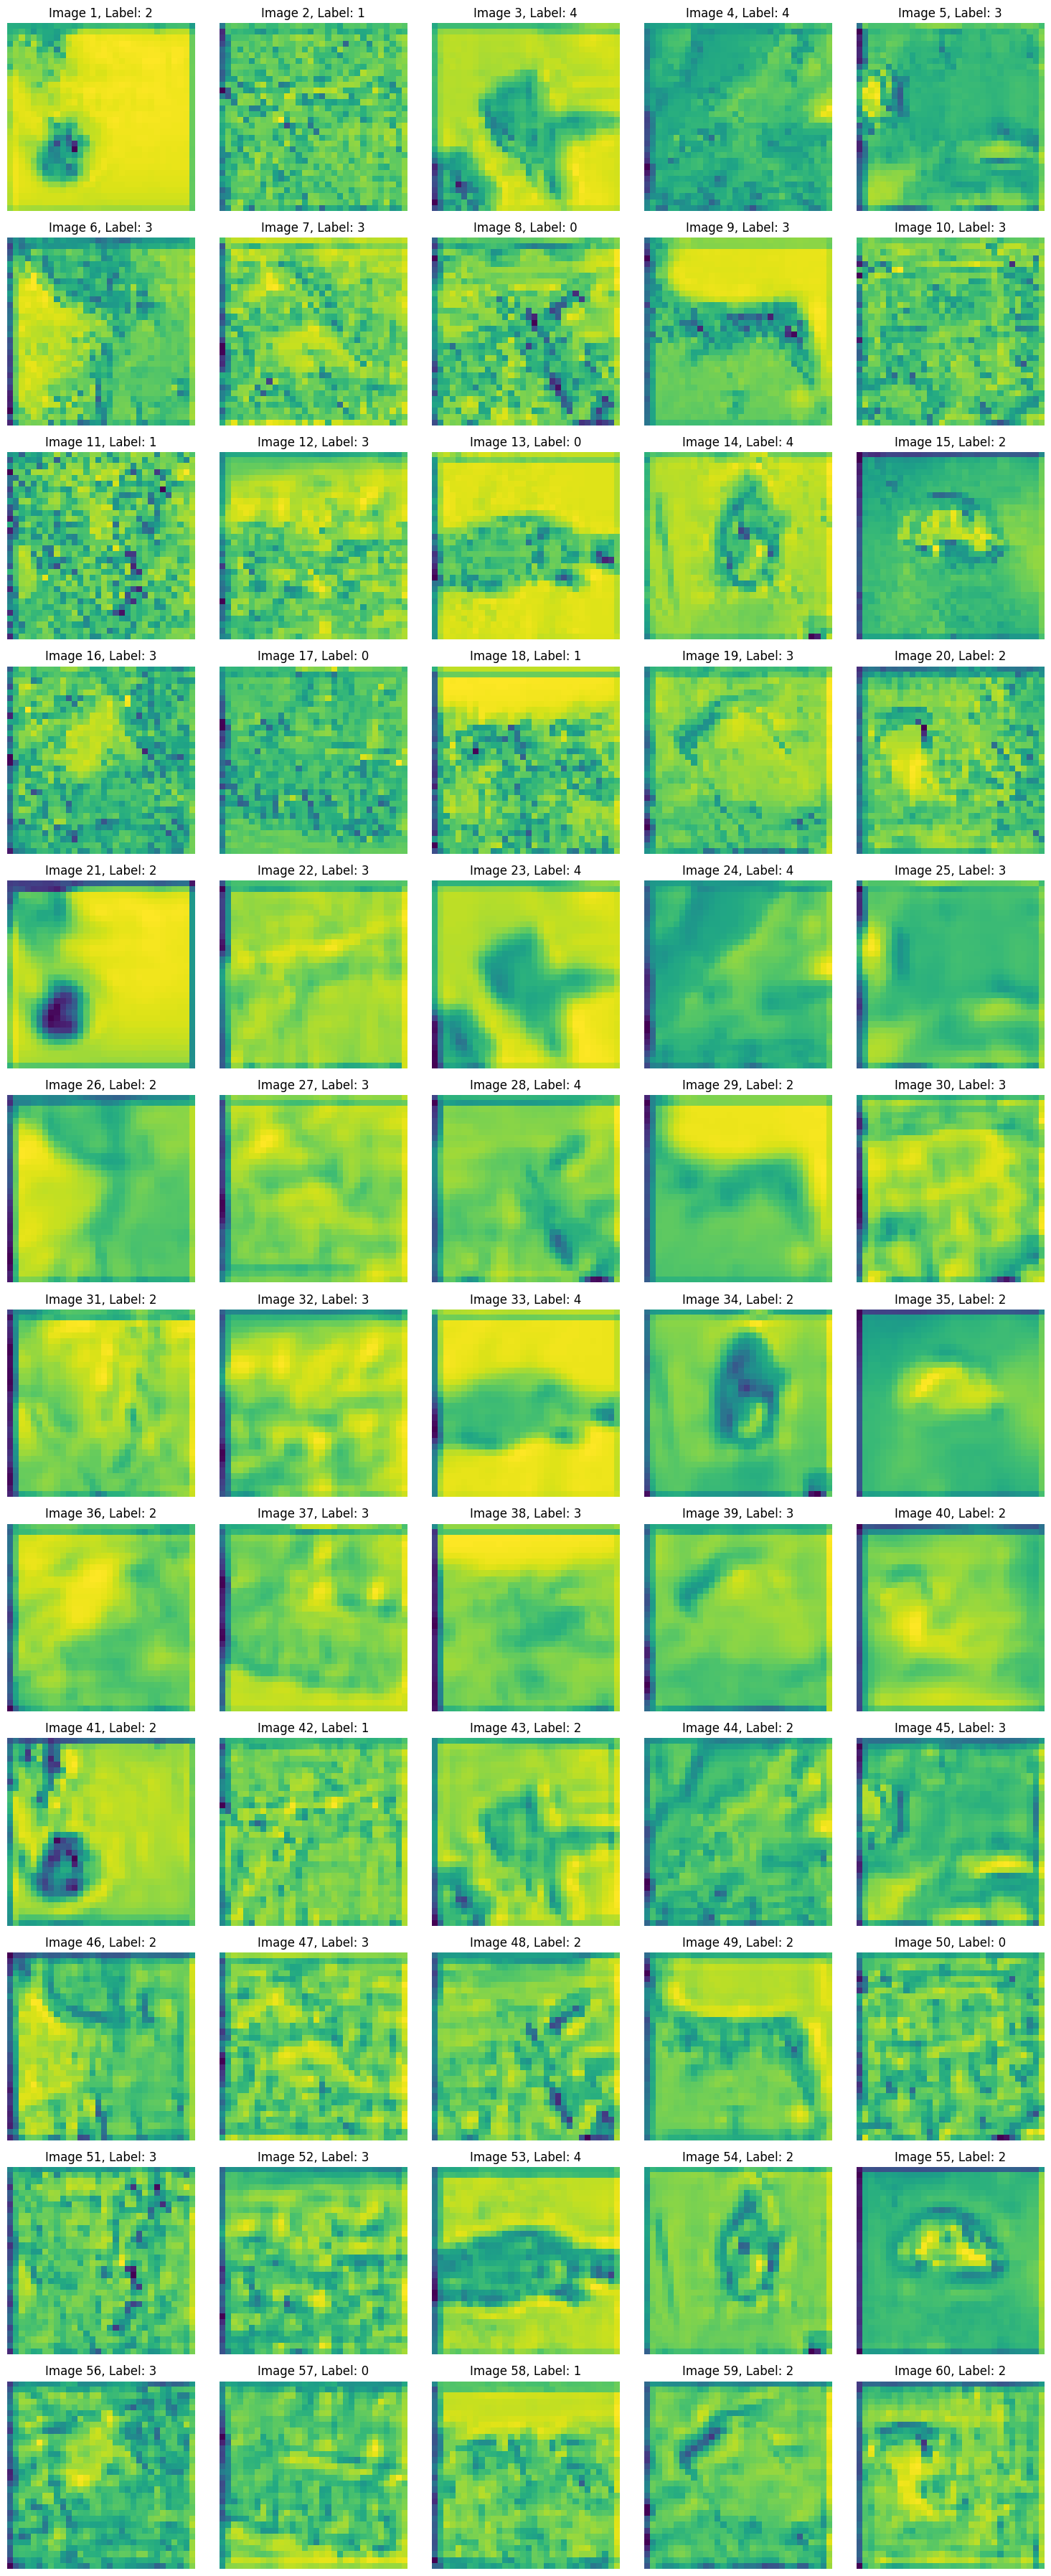

Layer activations for features1:
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130656_features1_activations.png


<Figure size 640x480 with 0 Axes>

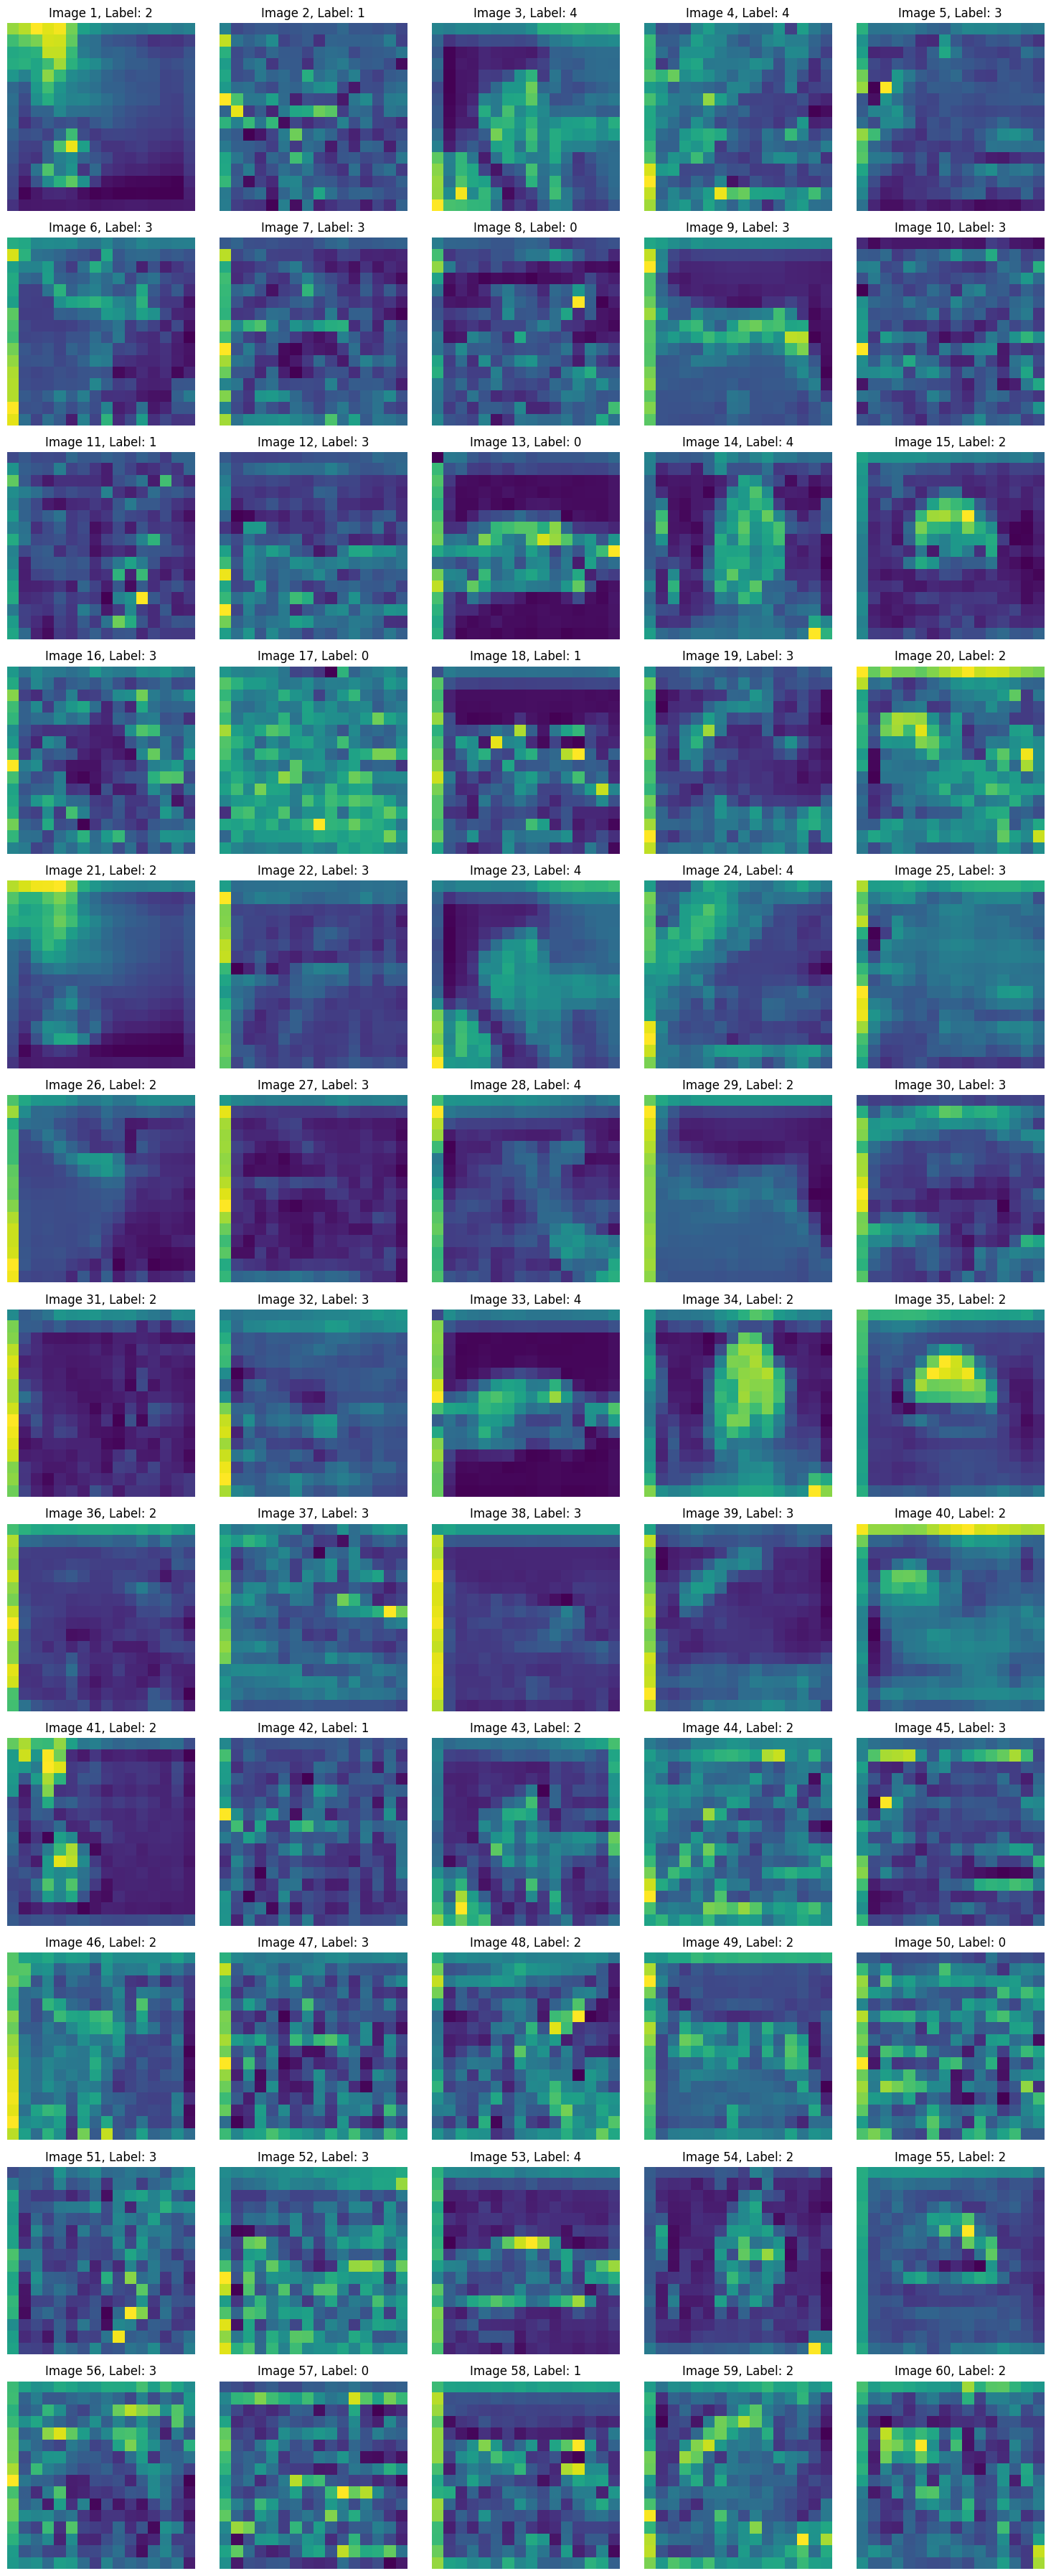

Layer activations for features2:
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130704_features2_activations.png


<Figure size 640x480 with 0 Axes>

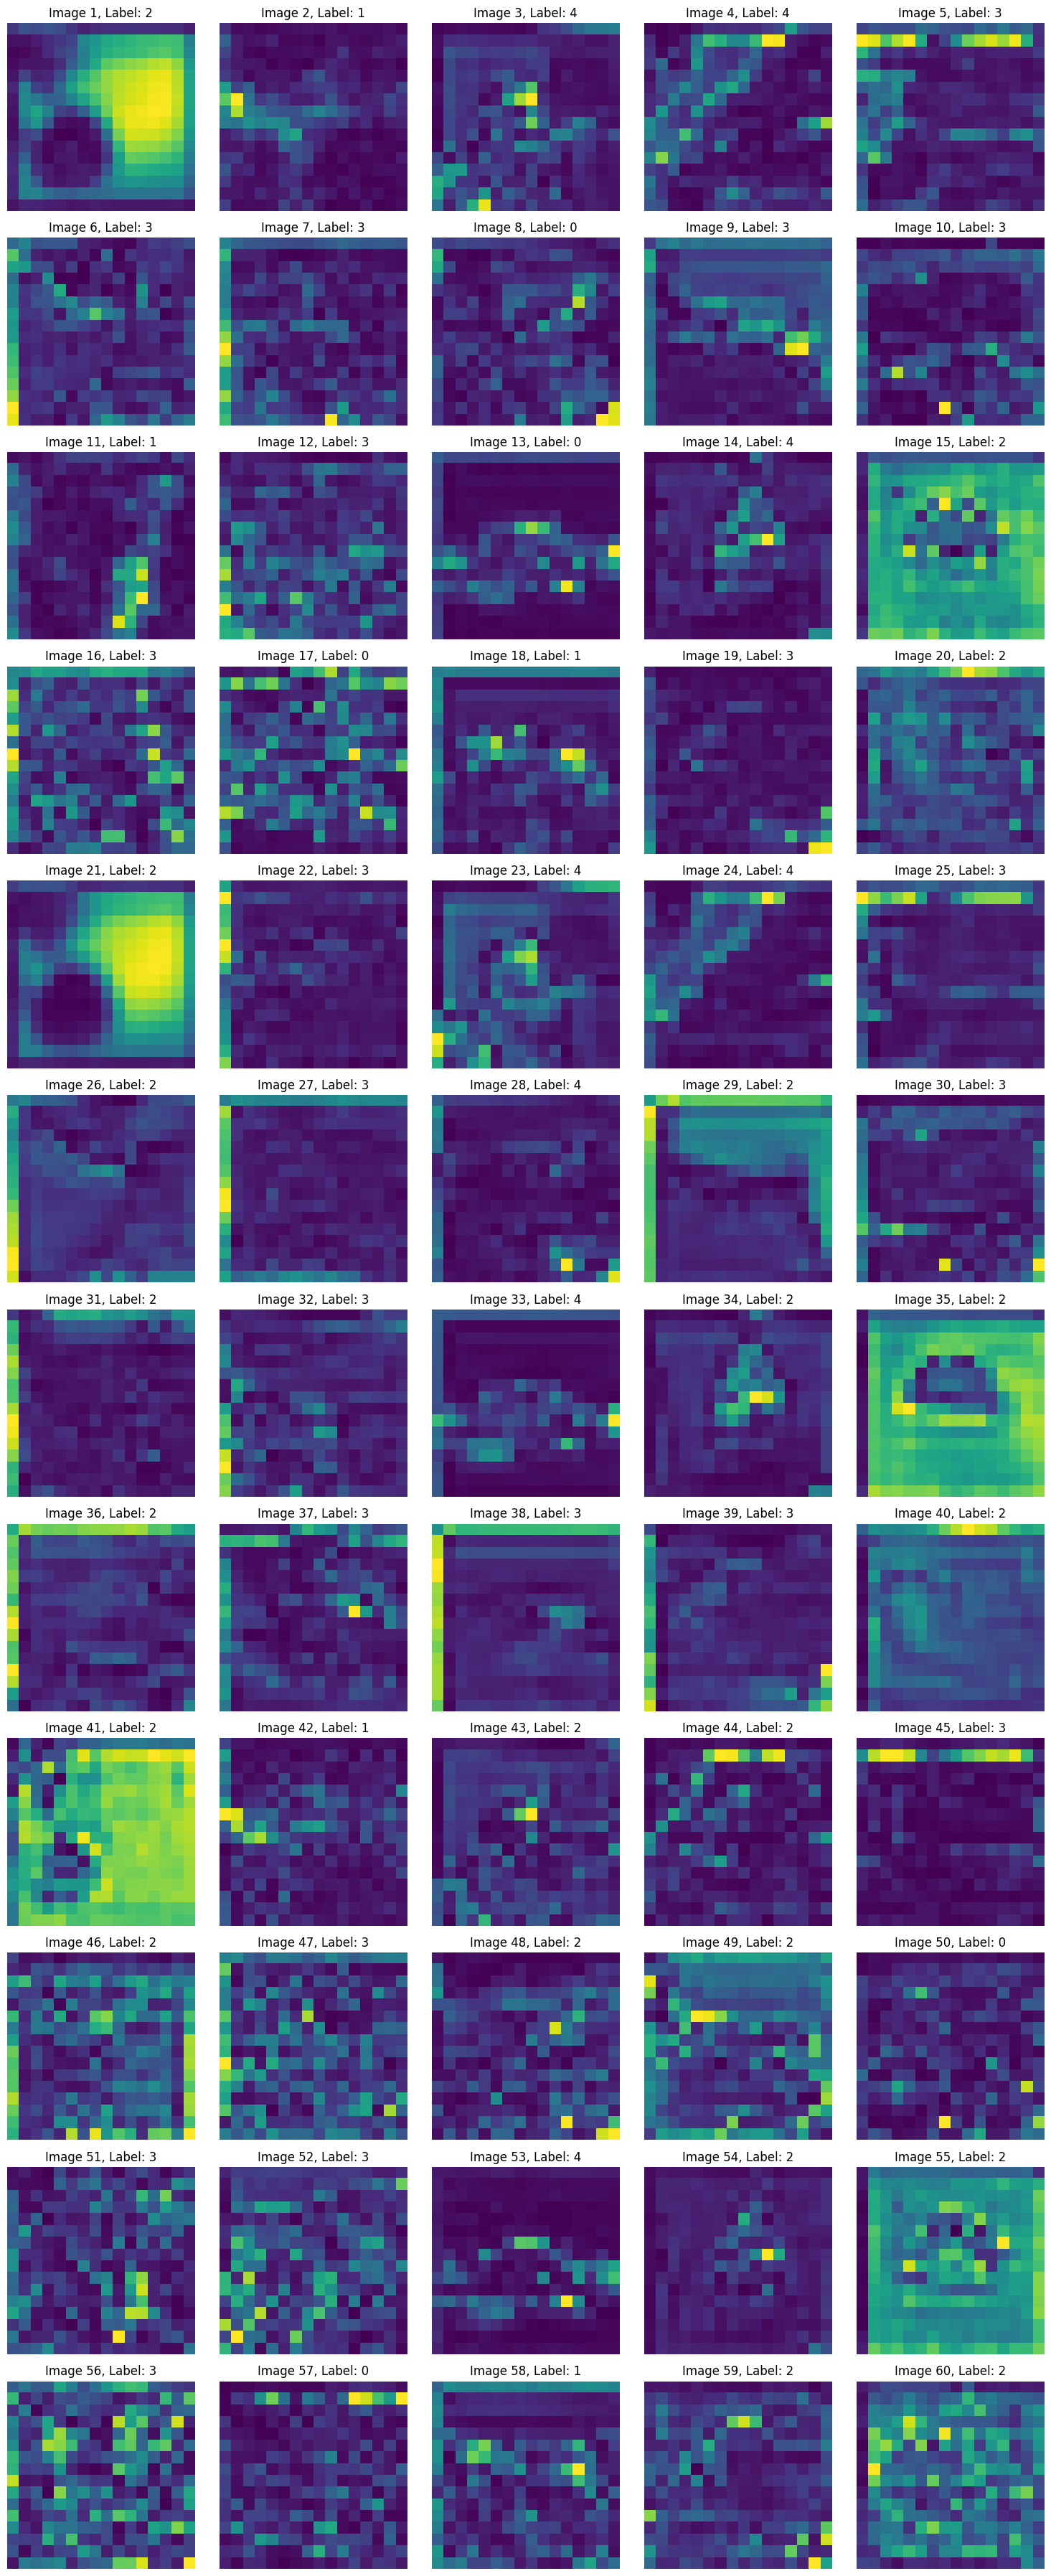

images folder renamed to M3
Loading model from /content/drive/MyDrive/Colab Notebooks/5M4acuity_cs_1_3_48.pth
valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
none transformation applied!
Loading 20 images from val set
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130710_none_images.png


<Figure size 640x480 with 0 Axes>

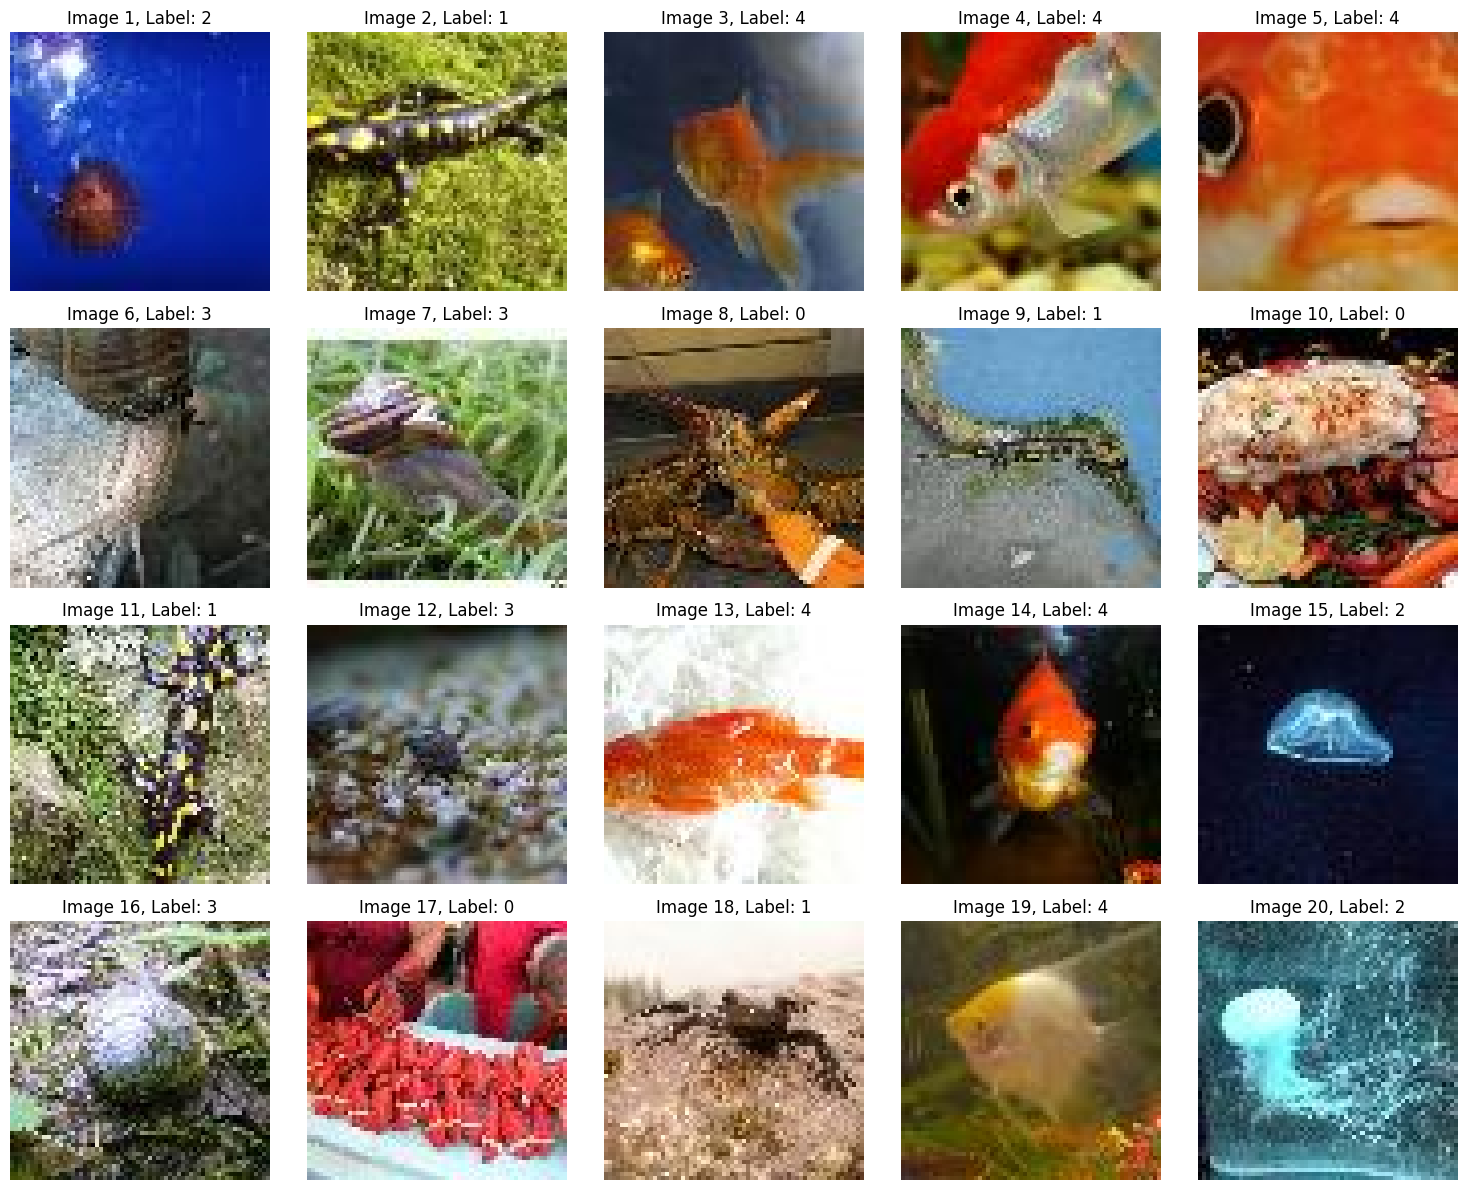

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
acuity transformation applied!
Loading 20 images from val set
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130713_acuity_images.png


<Figure size 640x480 with 0 Axes>

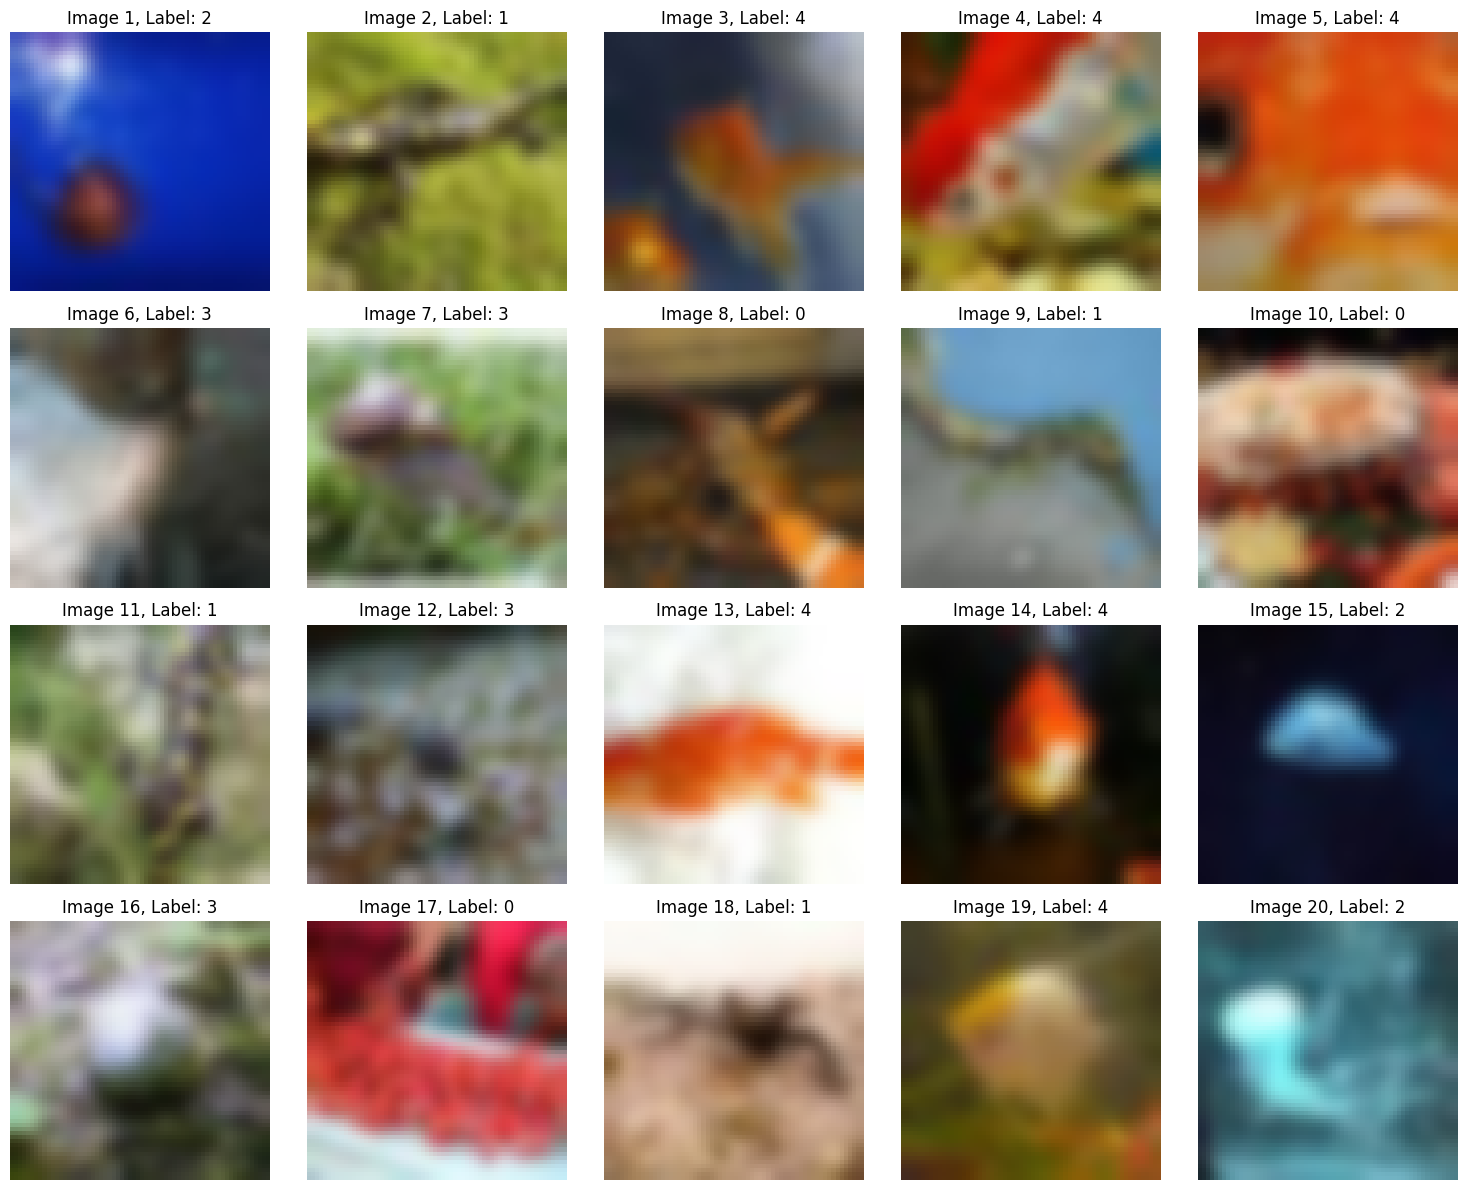

valDataset is fetched!
Data structure: [(PIL Image, Label)]
Length of val data: 250
cs transformation applied!
Loading 20 images from val set
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130716_cs_images.png


<Figure size 640x480 with 0 Axes>

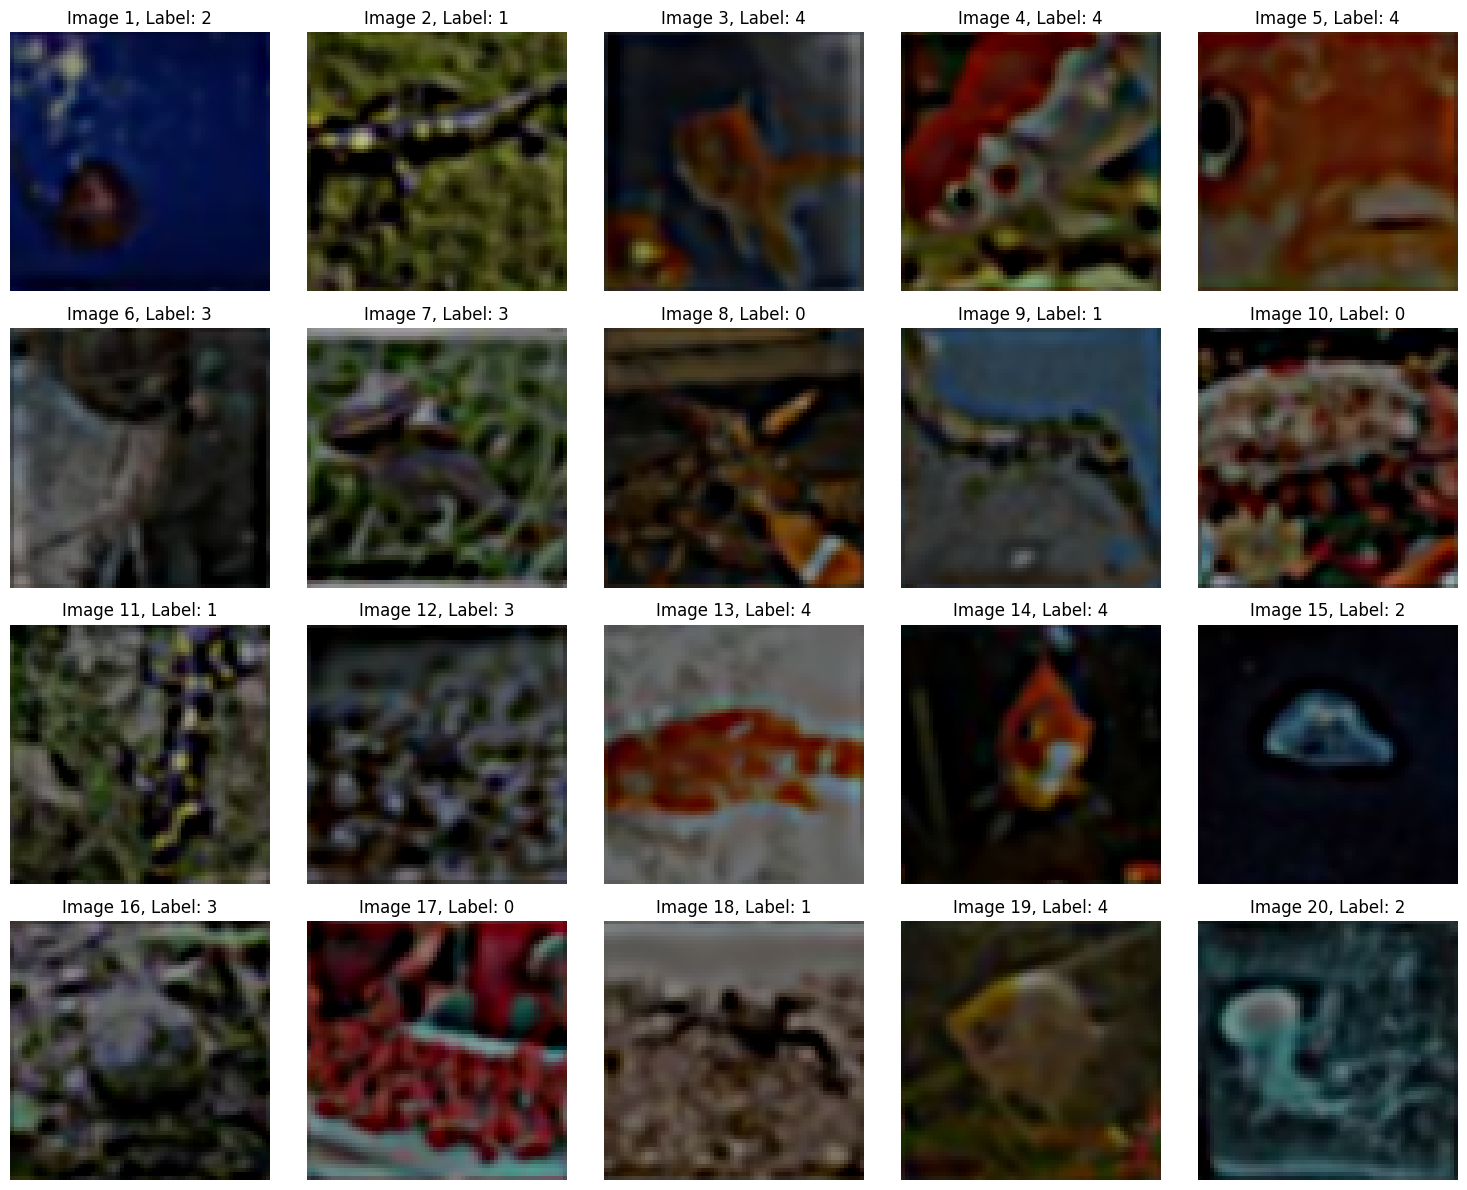

Layer activations for features0:
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130719_features0_activations.png


<Figure size 640x480 with 0 Axes>

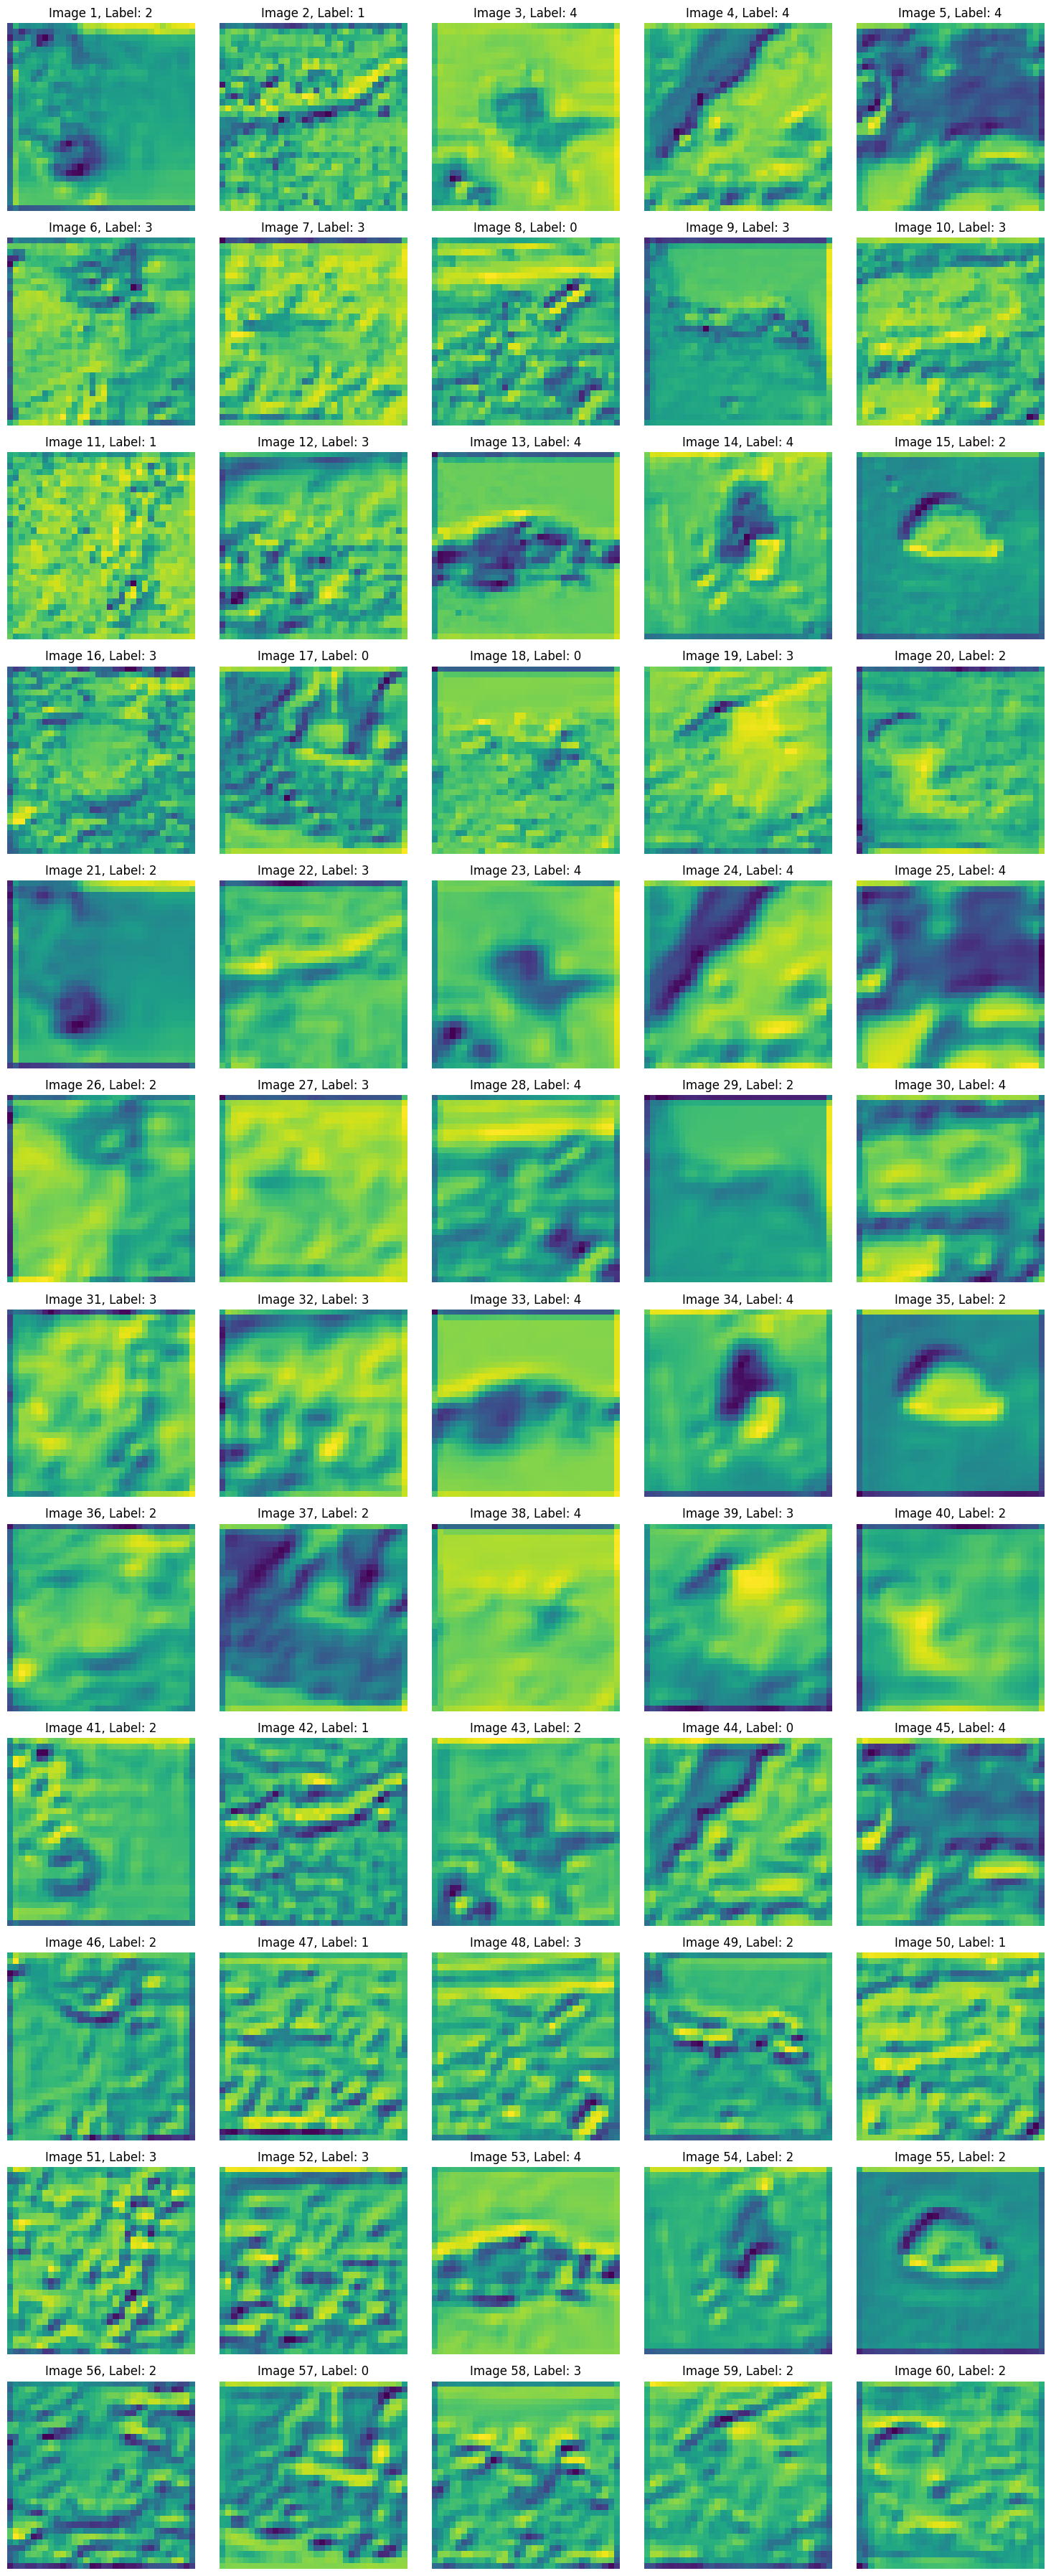

Layer activations for features1:
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130725_features1_activations.png


<Figure size 640x480 with 0 Axes>

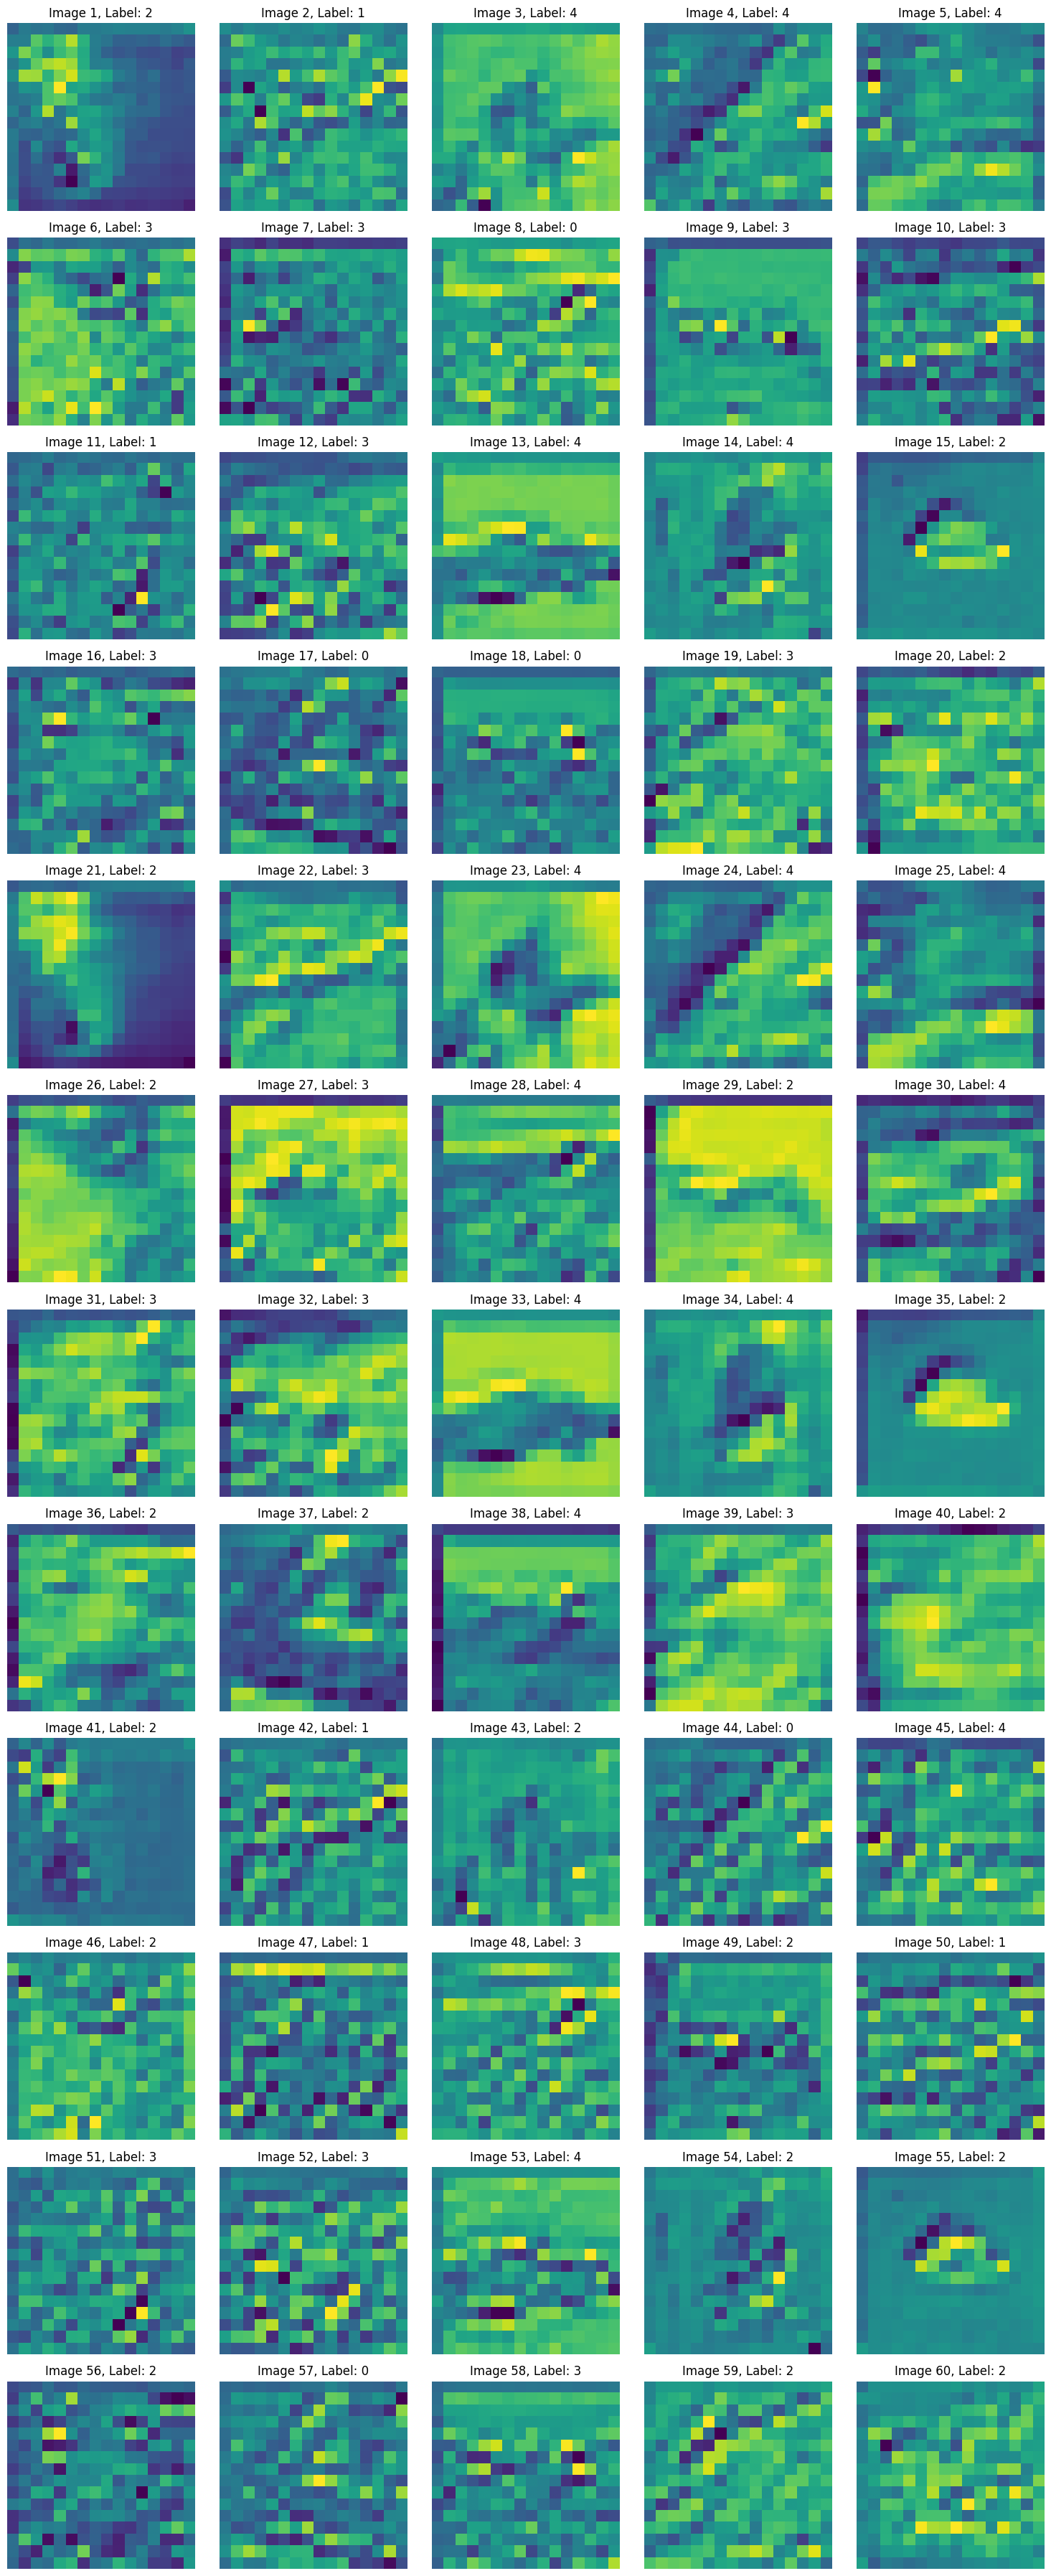

Layer activations for features2:
Saved figure to: /content/drive/MyDrive/Colab Notebooks/images/20250421_130733_features2_activations.png


<Figure size 640x480 with 0 Axes>

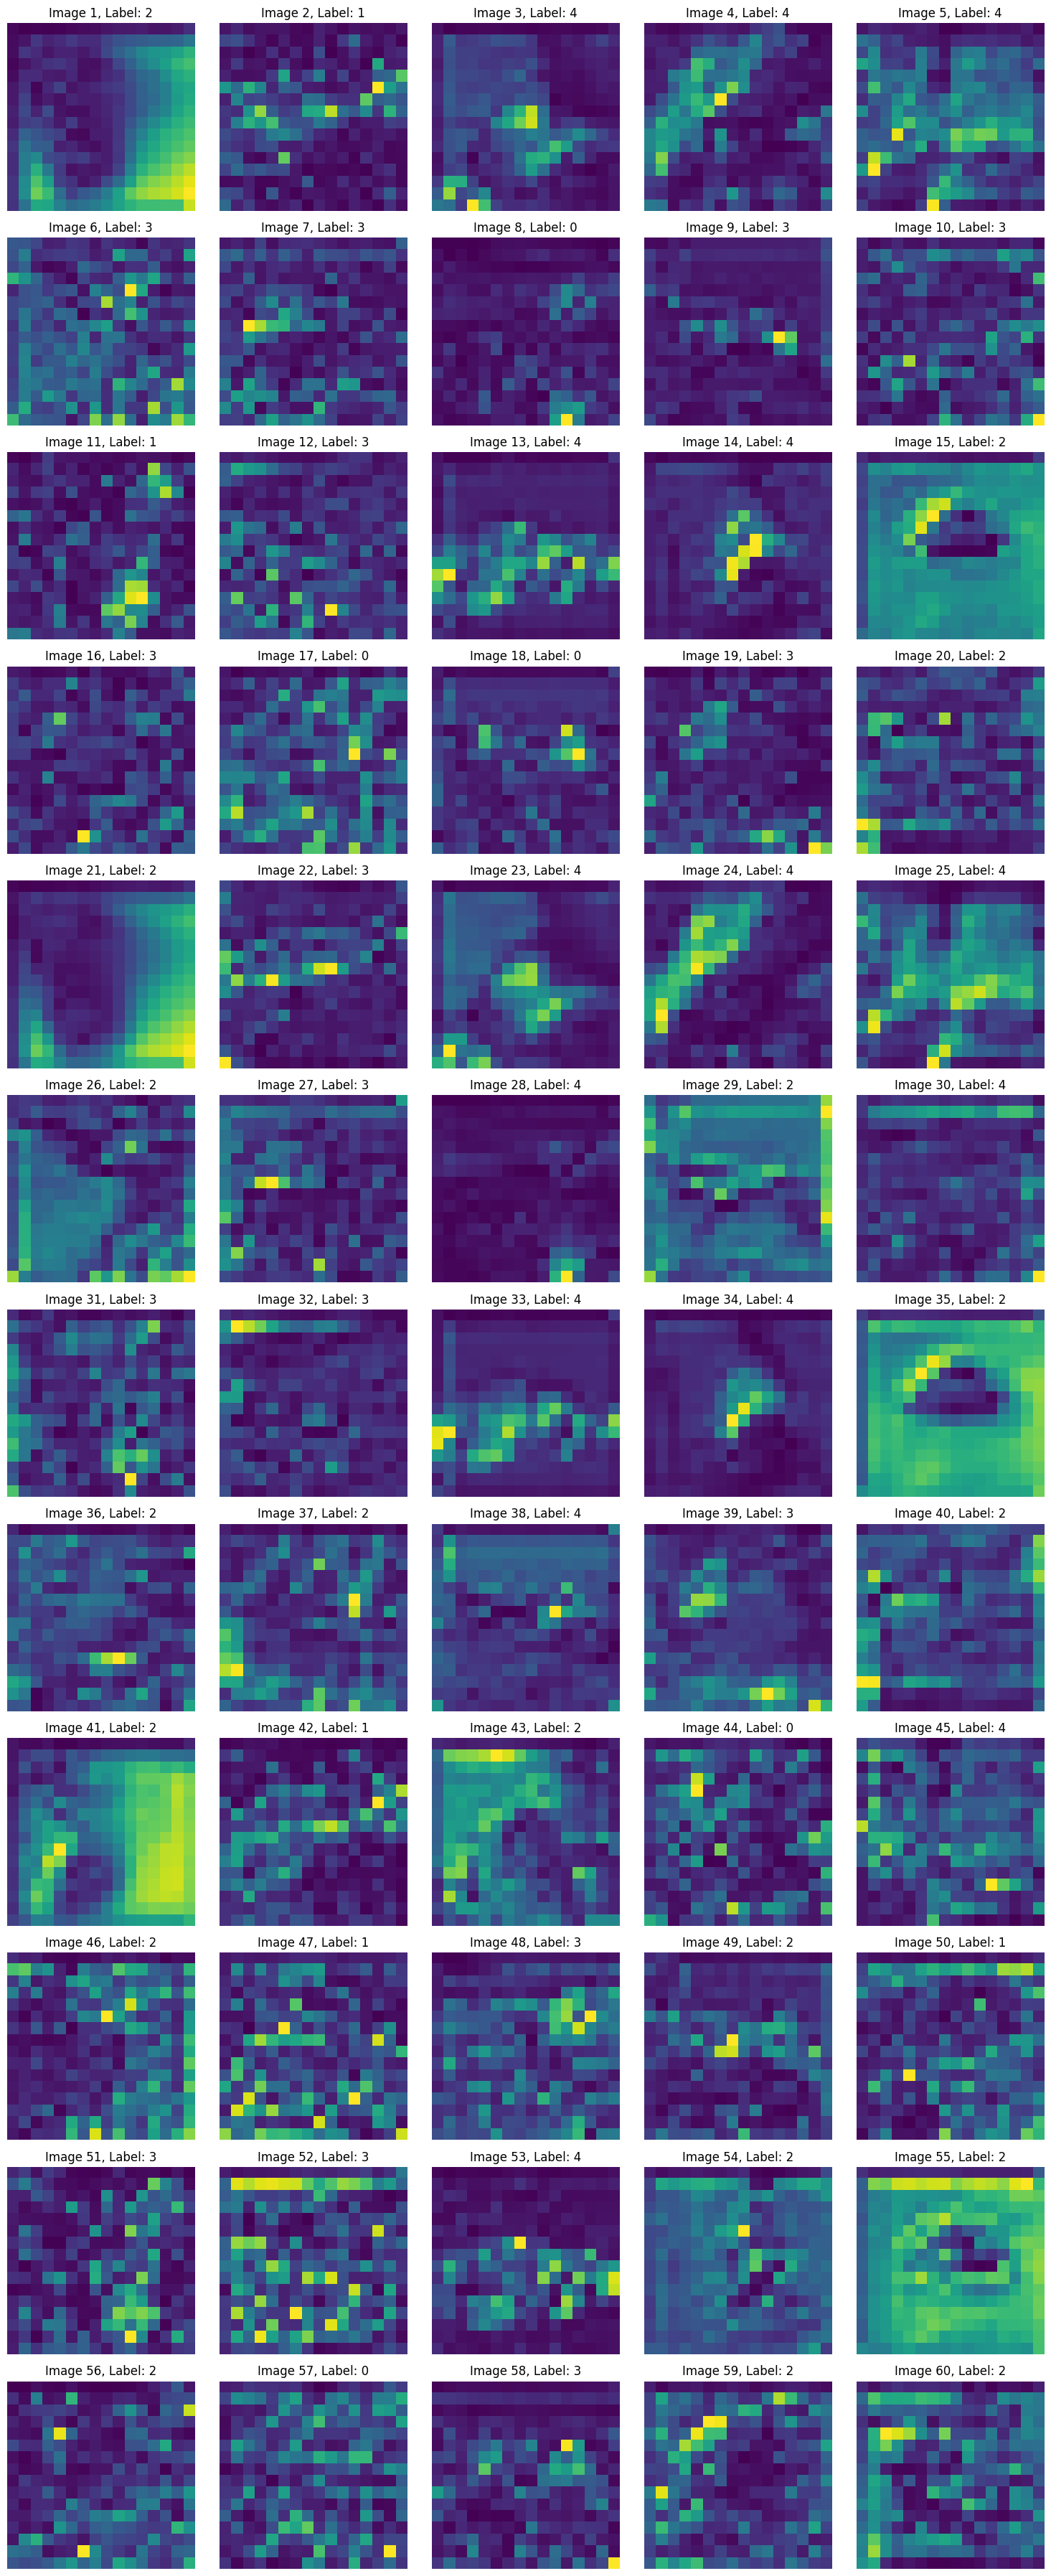

images folder renamed to M4
Displaying heatmaps for the RDMs...


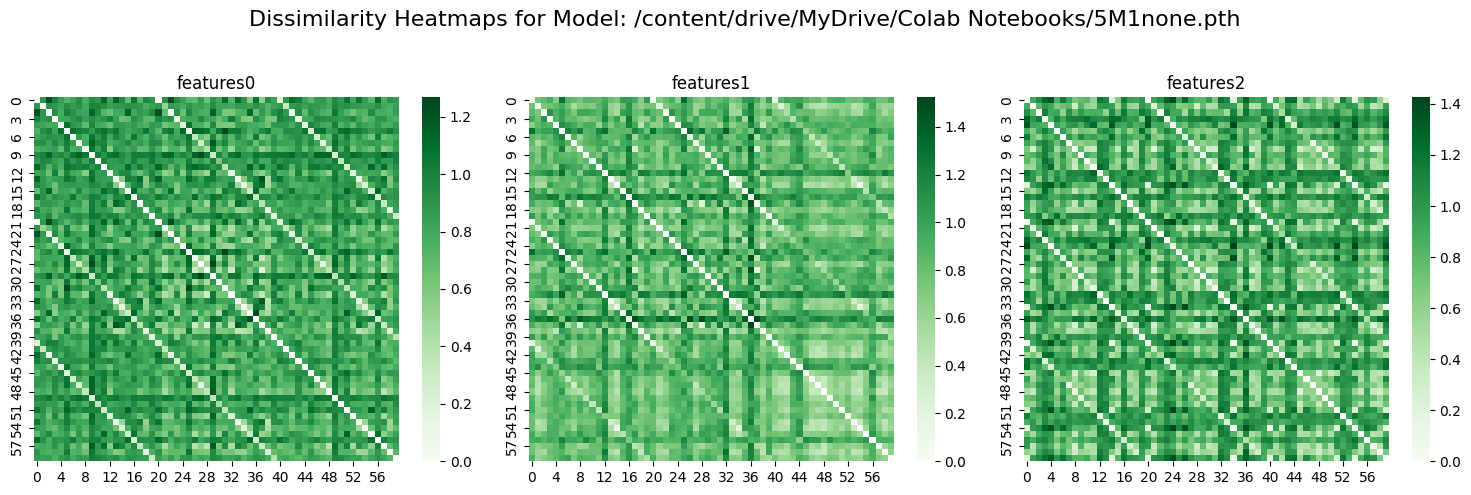

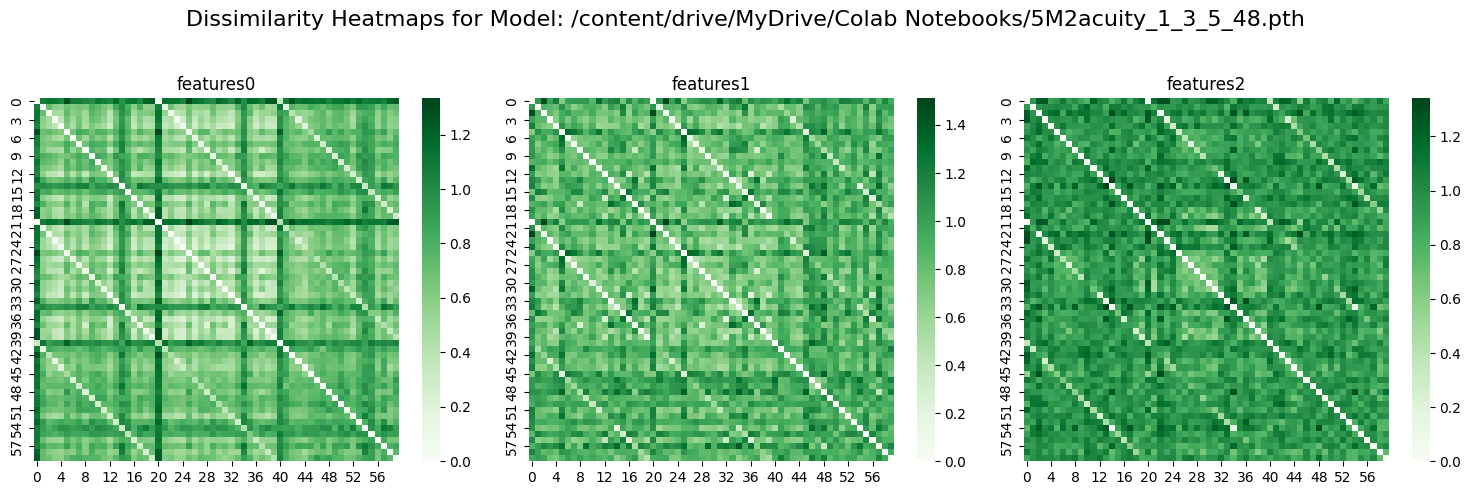

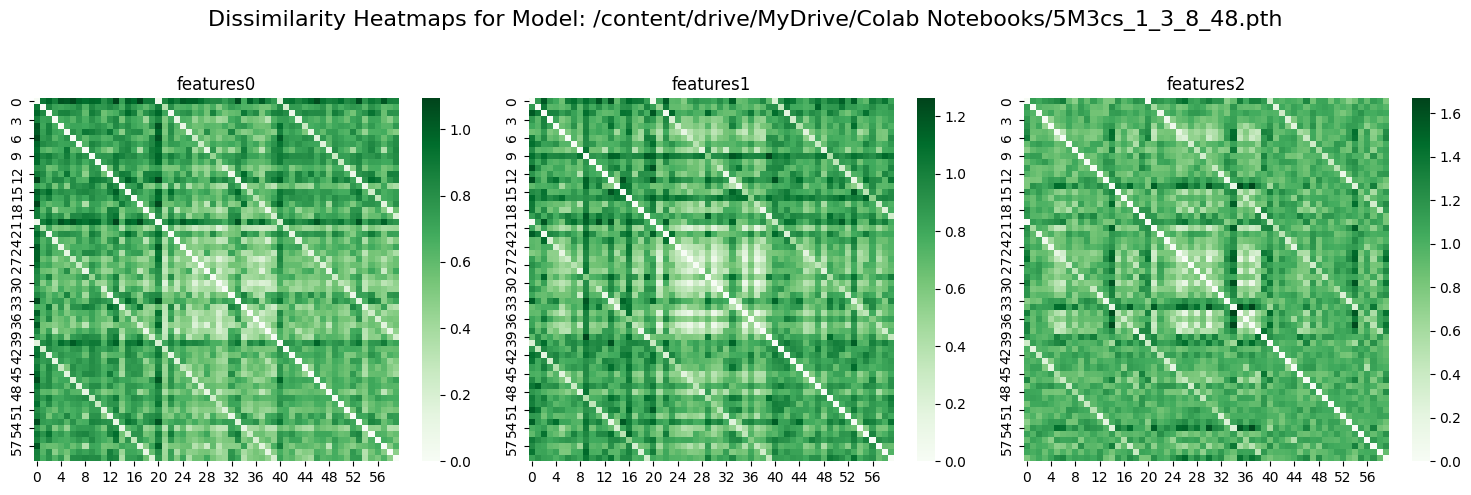

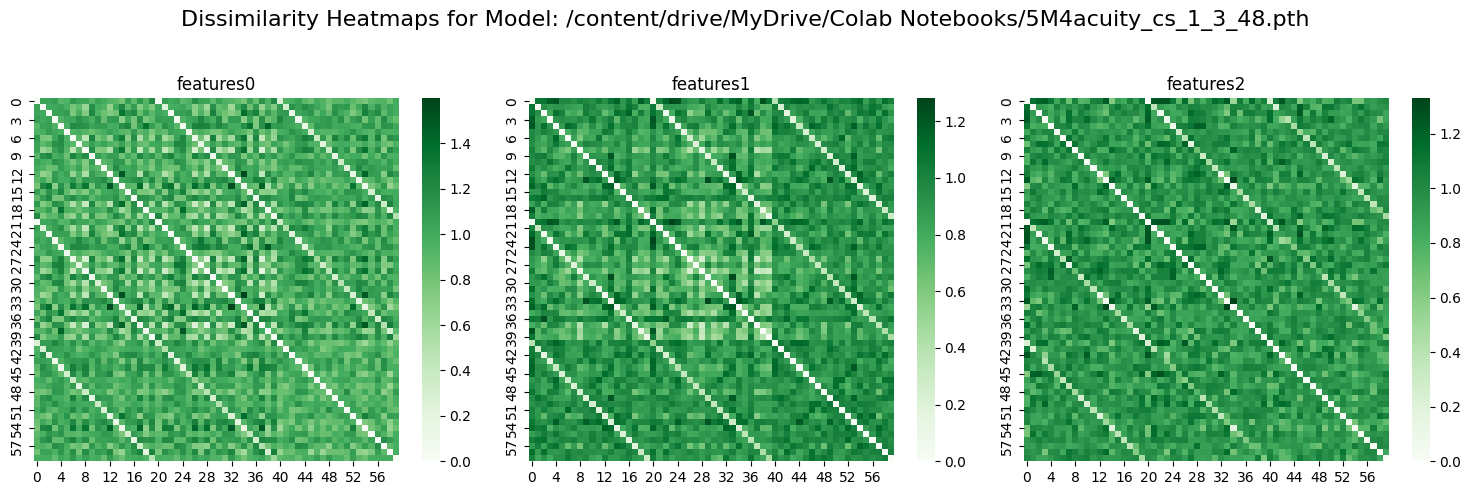

In [21]:
rdms = {}
rdvs = {}
for path in PTH_PATHS:
    print(f"Loading model from {path}")
    # Load the model and its evaluation metrics
    model, eval = load_model(path)

    imgs1 = load_images(int(NUM_IMGS/3))
    imgs2 = load_images(int(NUM_IMGS/3), "acuity")
    imgs3 = load_images(int(NUM_IMGS/3), "cs")
    imgs = imgs1 + imgs2 + imgs3

    # layer indices to compute the RDM
    layer_indices = ['features0', 'features1', 'features2']
    rdvec = {}
    rdmatrix = {}

    for index in layer_indices:
        rdmatrix[index] = RDM(imgs, index)

        # extract lower triangular part of the matrix excluding the diagonal
        lower_tri = torch.tril(rdmatrix[index], diagonal=-1)
        # Flatten the non-zero values
        flattened = lower_tri[lower_tri != 0]
        rdvec[index] = flattened

    # store the RDM and lower-triangle flattened vector for each model
    rdms[path] = rdmatrix
    rdvs[path] = rdvec

    if os.path.isdir(SAVE_PATH+ "/images"):
      os.rename(SAVE_PATH+"/images", SAVE_PATH+f"/M{PTH_PATHS.index(path)+1}")
      print(f"images folder renamed to M{PTH_PATHS.index(path)+1}")

# display the heatmaps for the RDMs
print("Displaying heatmaps for the RDMs...")
display_heatmaps(rdms)